In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("ready_datasets/final_dataset_for_modeling.csv", index_col="Unnamed: 0")

In [3]:
# Drop rows remained without "role" (not a great problem, they all belong to players who never played in that particular season)

data = data[data.role.notna()]

# Drop rows remained without "price" (around 5% of players in each season, but in season 2019 they are 200 out of 705 unique players)
# This is why we decided to train only on 2016,2017 and test on 2018 instead

data = data[data.price.notna()]

In [4]:
data.head()

,player,season,matchweek,team,match_date,home_team,away_team,score,status,player_status,id,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,coach,coach_score,price,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,final_score_next_week,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4
0,AARONS,2017,23,VERONA,2018-02-04,VERONA,ROMA,0:1,LM,played in the game,2661.0,M,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PECCHIA,5.0,5.0,ROMA,1771.0,2114.0,0.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.3,4.0,1.571429,4.0,0.75,2.0,1.6,4.0,1.571429,4.0,2.00,4.0,-3.0,-1.0,-2.0,0.9,3.0,0.714286,1.0,0.50,1.0,0.8,2.0,0.857143,2.0,1.25,2.0,0.0,-1.0,-3.0,1,5.0,5.5,5.000000,5.0,5.000000,5.0,5.000000,5.0
1,AARONS,2017,24,VERONA,2018-02-11,SAMPDORIA,VERONA,2:0,RW,played in the game,2661.0,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PECCHIA,6.0,5.0,SAMPDORIA,1767.0,1935.0,0.0,5.250000,5.5,5.250000,5.5,5.250000,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.5,4.0,1.428571,4.0,0.75,2.0,1.4,4.0,1.571429,4.0,2.00,4.0,-1.0,-1.0,-2.0,1.7,3.0,2.000000,3.0,1.50,3.0,1.2,2.0,1.000000,2.0,0.75,1.0,2.0,4.0,1.0,0,5.5,5.5,5.250000,5.5,5.250000,5.5,5.250000,5.5
2,AARONS,2017,25,VERONA,2018-02-19,LAZIO,VERONA,2:0,NaN,error_status,2661.0,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PECCHIA,5.0,5.0,LAZIO,1762.0,2032.0,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.7,4.0,1.142857,2.0,1.25,2.0,1.3,4.0,1.571429,4.0,1.25,4.0,1.0,-1.0,0.0,2.4,5.0,2.285714,5.0,2.25,4.0,1.6,5.0,1.428571,5.0,1.00,2.0,2.0,2.0,2.0,0,5.5,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5
3,AARONS,2017,26,VERONA,2018-02-25,VERONA,TORINO,2:1,on the bench,on the bench,2661.0,M,0.0,0.0,0.

In [5]:
# Drop variables we don't want to use

data = data.drop(["match_date", "score", "status", "player_status", "id", "coach", "coach_score"], axis=1)

# HyperParameter Tuning

## Goalkeepers

In [6]:
goal_keepers = data[data.role == "G"]

In [7]:
train_df = goal_keepers[(goal_keepers.season == 2016) | (goal_keepers.season == 2017) | ((goal_keepers.season == 2018) & (goal_keepers.matchweek < 19))]

In [8]:
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y = train_df["final_score_next_week"]
X = train_df.drop(["final_score_next_week", "price"], axis=1)

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

pool_train = Pool(X, y, cat_features=cat_features)

In [9]:
# Define parameters for grid search

params = {'depth':[7,8],
          'learning_rate':[0.1], 
          'l2_leaf_reg':[2,3,4]}

In [10]:
# Perform Grid Search

catboost = CatBoostRegressor(random_state=42)
grid_search_results = catboost.grid_search(params, pool_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.3705397	test: 3.1815215	best: 3.1815215 (0)	total: 199ms	remaining: 3m 18s
1:	learn: 3.1504947	test: 2.9727901	best: 2.9727901 (1)	total: 278ms	remaining: 2m 18s
2:	learn: 2.9612624	test: 2.7973219	best: 2.7973219 (2)	total: 399ms	remaining: 2m 12s
3:	learn: 2.7939063	test: 2.6429039	best: 2.6429039 (3)	total: 540ms	remaining: 2m 14s
4:	learn: 2.6531088	test: 2.5117510	best: 2.5117510 (4)	total: 580ms	remaining: 1m 55s
5:	learn: 2.5273631	test: 2.3961635	best: 2.3961635 (5)	total: 663ms	remaining: 1m 49s
6:	learn: 2.4190924	test: 2.2962563	best: 2.2962563 (6)	total: 724ms	remaining: 1m 42s
7:	learn: 2.3279066	test: 2.2101818	best: 2.2101818 (7)	total: 809ms	remaining: 1m 40s
8:	learn: 2.2490710	test: 2.1414545	best: 2.1414545 (8)	total: 892ms	remaining: 1m 38s
9:	learn: 2.1841145	test: 2.0849410	best: 2.0849410 (9)	total: 1.01s	remaining: 1m 40s
10:	learn: 2.1287336	test: 2.0370276	best: 2.0370276 (10)	total: 1.09s	remaining: 1m 37s
11:	learn: 2.0826358	test: 1.9956249	best

95:	learn: 1.5257969	test: 1.6459038	best: 1.6459038 (95)	total: 7.34s	remaining: 1m 9s
96:	learn: 1.5218679	test: 1.6462388	best: 1.6459038 (95)	total: 7.38s	remaining: 1m 8s
97:	learn: 1.5193194	test: 1.6469178	best: 1.6459038 (95)	total: 7.42s	remaining: 1m 8s
98:	learn: 1.5175343	test: 1.6470098	best: 1.6459038 (95)	total: 7.48s	remaining: 1m 8s
99:	learn: 1.5119516	test: 1.6486482	best: 1.6459038 (95)	total: 7.52s	remaining: 1m 7s
100:	learn: 1.5067770	test: 1.6480568	best: 1.6459038 (95)	total: 7.55s	remaining: 1m 7s
101:	learn: 1.5052116	test: 1.6482242	best: 1.6459038 (95)	total: 7.6s	remaining: 1m 6s
102:	learn: 1.5007008	test: 1.6469633	best: 1.6459038 (95)	total: 7.64s	remaining: 1m 6s
103:	learn: 1.4992248	test: 1.6473819	best: 1.6459038 (95)	total: 7.67s	remaining: 1m 6s
104:	learn: 1.4967175	test: 1.6474451	best: 1.6459038 (95)	total: 7.71s	remaining: 1m 5s
105:	learn: 1.4917174	test: 1.6430536	best: 1.6430536 (105)	total: 7.76s	remaining: 1m 5s
106:	learn: 1.4889170	test

187:	learn: 1.2771485	test: 1.6172300	best: 1.6168856 (186)	total: 11.7s	remaining: 50.5s
188:	learn: 1.2745665	test: 1.6165653	best: 1.6165653 (188)	total: 11.7s	remaining: 50.3s
189:	learn: 1.2732073	test: 1.6165738	best: 1.6165653 (188)	total: 11.8s	remaining: 50.2s
190:	learn: 1.2718888	test: 1.6162077	best: 1.6162077 (190)	total: 11.8s	remaining: 50s
191:	learn: 1.2694851	test: 1.6169254	best: 1.6162077 (190)	total: 11.9s	remaining: 49.9s
192:	learn: 1.2676426	test: 1.6168634	best: 1.6162077 (190)	total: 11.9s	remaining: 49.8s
193:	learn: 1.2647717	test: 1.6181578	best: 1.6162077 (190)	total: 12s	remaining: 49.7s
194:	learn: 1.2640309	test: 1.6183816	best: 1.6162077 (190)	total: 12s	remaining: 49.6s
195:	learn: 1.2614457	test: 1.6189338	best: 1.6162077 (190)	total: 12.1s	remaining: 49.5s
196:	learn: 1.2593273	test: 1.6193971	best: 1.6162077 (190)	total: 12.1s	remaining: 49.4s
197:	learn: 1.2565004	test: 1.6199915	best: 1.6162077 (190)	total: 12.2s	remaining: 49.3s
198:	learn: 1.25

283:	learn: 1.0677973	test: 1.6237116	best: 1.6136005 (213)	total: 18.7s	remaining: 47.1s
284:	learn: 1.0662120	test: 1.6242489	best: 1.6136005 (213)	total: 18.7s	remaining: 47s
285:	learn: 1.0646207	test: 1.6235667	best: 1.6136005 (213)	total: 18.8s	remaining: 46.8s
286:	learn: 1.0630176	test: 1.6228308	best: 1.6136005 (213)	total: 18.8s	remaining: 46.7s
287:	learn: 1.0601795	test: 1.6230724	best: 1.6136005 (213)	total: 18.9s	remaining: 46.6s
288:	learn: 1.0584886	test: 1.6226039	best: 1.6136005 (213)	total: 19s	remaining: 46.7s
289:	learn: 1.0559896	test: 1.6232721	best: 1.6136005 (213)	total: 19.1s	remaining: 46.8s
290:	learn: 1.0550672	test: 1.6230723	best: 1.6136005 (213)	total: 19.2s	remaining: 46.7s
291:	learn: 1.0531672	test: 1.6230908	best: 1.6136005 (213)	total: 19.2s	remaining: 46.7s
292:	learn: 1.0497822	test: 1.6235193	best: 1.6136005 (213)	total: 19.3s	remaining: 46.6s
293:	learn: 1.0484462	test: 1.6244743	best: 1.6136005 (213)	total: 19.4s	remaining: 46.6s
294:	learn: 1.

375:	learn: 0.9116645	test: 1.6281485	best: 1.6136005 (213)	total: 22.7s	remaining: 37.7s
376:	learn: 0.9088283	test: 1.6285574	best: 1.6136005 (213)	total: 22.7s	remaining: 37.5s
377:	learn: 0.9056911	test: 1.6285473	best: 1.6136005 (213)	total: 22.8s	remaining: 37.5s
378:	learn: 0.9050124	test: 1.6285003	best: 1.6136005 (213)	total: 22.8s	remaining: 37.4s
379:	learn: 0.9041391	test: 1.6288489	best: 1.6136005 (213)	total: 22.8s	remaining: 37.3s
380:	learn: 0.9023845	test: 1.6284170	best: 1.6136005 (213)	total: 22.9s	remaining: 37.2s
381:	learn: 0.9009416	test: 1.6283148	best: 1.6136005 (213)	total: 22.9s	remaining: 37.1s
382:	learn: 0.9002335	test: 1.6282490	best: 1.6136005 (213)	total: 23s	remaining: 37s
383:	learn: 0.8981690	test: 1.6287684	best: 1.6136005 (213)	total: 23.1s	remaining: 37.1s
384:	learn: 0.8971201	test: 1.6285503	best: 1.6136005 (213)	total: 23.2s	remaining: 37.1s
385:	learn: 0.8945748	test: 1.6283500	best: 1.6136005 (213)	total: 23.3s	remaining: 37s
386:	learn: 0.89

470:	learn: 0.7902214	test: 1.6353573	best: 1.6136005 (213)	total: 26.5s	remaining: 29.7s
471:	learn: 0.7886757	test: 1.6353328	best: 1.6136005 (213)	total: 26.5s	remaining: 29.7s
472:	learn: 0.7865064	test: 1.6356892	best: 1.6136005 (213)	total: 26.5s	remaining: 29.6s
473:	learn: 0.7858491	test: 1.6356805	best: 1.6136005 (213)	total: 26.6s	remaining: 29.5s
474:	learn: 0.7838067	test: 1.6363673	best: 1.6136005 (213)	total: 26.6s	remaining: 29.4s
475:	learn: 0.7836874	test: 1.6363659	best: 1.6136005 (213)	total: 26.6s	remaining: 29.3s
476:	learn: 0.7822216	test: 1.6369415	best: 1.6136005 (213)	total: 26.7s	remaining: 29.2s
477:	learn: 0.7814918	test: 1.6371210	best: 1.6136005 (213)	total: 26.7s	remaining: 29.1s
478:	learn: 0.7798767	test: 1.6373270	best: 1.6136005 (213)	total: 26.7s	remaining: 29.1s
479:	learn: 0.7790275	test: 1.6370745	best: 1.6136005 (213)	total: 26.8s	remaining: 29s
480:	learn: 0.7784165	test: 1.6370849	best: 1.6136005 (213)	total: 26.8s	remaining: 28.9s
481:	learn: 

566:	learn: 0.6881576	test: 1.6399740	best: 1.6136005 (213)	total: 30s	remaining: 22.9s
567:	learn: 0.6863779	test: 1.6396303	best: 1.6136005 (213)	total: 30s	remaining: 22.8s
568:	learn: 0.6844898	test: 1.6399178	best: 1.6136005 (213)	total: 30s	remaining: 22.8s
569:	learn: 0.6826783	test: 1.6395875	best: 1.6136005 (213)	total: 30.1s	remaining: 22.7s
570:	learn: 0.6815324	test: 1.6399903	best: 1.6136005 (213)	total: 30.1s	remaining: 22.6s
571:	learn: 0.6803450	test: 1.6402719	best: 1.6136005 (213)	total: 30.1s	remaining: 22.5s
572:	learn: 0.6783291	test: 1.6406283	best: 1.6136005 (213)	total: 30.2s	remaining: 22.5s
573:	learn: 0.6776184	test: 1.6406181	best: 1.6136005 (213)	total: 30.2s	remaining: 22.4s
574:	learn: 0.6768837	test: 1.6406181	best: 1.6136005 (213)	total: 30.3s	remaining: 22.4s
575:	learn: 0.6755437	test: 1.6408559	best: 1.6136005 (213)	total: 30.3s	remaining: 22.3s
576:	learn: 0.6752165	test: 1.6410709	best: 1.6136005 (213)	total: 30.3s	remaining: 22.2s
577:	learn: 0.67

659:	learn: 0.6046898	test: 1.6434785	best: 1.6136005 (213)	total: 33.5s	remaining: 17.2s
660:	learn: 0.6038889	test: 1.6430100	best: 1.6136005 (213)	total: 33.5s	remaining: 17.2s
661:	learn: 0.6030424	test: 1.6426685	best: 1.6136005 (213)	total: 33.5s	remaining: 17.1s
662:	learn: 0.6016478	test: 1.6427195	best: 1.6136005 (213)	total: 33.5s	remaining: 17.1s
663:	learn: 0.6012607	test: 1.6430961	best: 1.6136005 (213)	total: 33.6s	remaining: 17s
664:	learn: 0.6000213	test: 1.6430597	best: 1.6136005 (213)	total: 33.6s	remaining: 16.9s
665:	learn: 0.5997153	test: 1.6429940	best: 1.6136005 (213)	total: 33.6s	remaining: 16.9s
666:	learn: 0.5986890	test: 1.6434609	best: 1.6136005 (213)	total: 33.7s	remaining: 16.8s
667:	learn: 0.5982119	test: 1.6435906	best: 1.6136005 (213)	total: 33.7s	remaining: 16.7s
668:	learn: 0.5975141	test: 1.6434947	best: 1.6136005 (213)	total: 33.7s	remaining: 16.7s
669:	learn: 0.5972288	test: 1.6435867	best: 1.6136005 (213)	total: 33.8s	remaining: 16.6s
670:	learn: 

756:	learn: 0.5252307	test: 1.6457926	best: 1.6136005 (213)	total: 37s	remaining: 11.9s
757:	learn: 0.5243750	test: 1.6456769	best: 1.6136005 (213)	total: 37s	remaining: 11.8s
758:	learn: 0.5234212	test: 1.6456725	best: 1.6136005 (213)	total: 37s	remaining: 11.8s
759:	learn: 0.5223554	test: 1.6457814	best: 1.6136005 (213)	total: 37.1s	remaining: 11.7s
760:	learn: 0.5209926	test: 1.6456161	best: 1.6136005 (213)	total: 37.1s	remaining: 11.7s
761:	learn: 0.5199262	test: 1.6458325	best: 1.6136005 (213)	total: 37.2s	remaining: 11.6s
762:	learn: 0.5187470	test: 1.6456763	best: 1.6136005 (213)	total: 37.2s	remaining: 11.6s
763:	learn: 0.5172004	test: 1.6451242	best: 1.6136005 (213)	total: 37.2s	remaining: 11.5s
764:	learn: 0.5163114	test: 1.6453064	best: 1.6136005 (213)	total: 37.3s	remaining: 11.5s
765:	learn: 0.5156095	test: 1.6457154	best: 1.6136005 (213)	total: 37.3s	remaining: 11.4s
766:	learn: 0.5152273	test: 1.6453516	best: 1.6136005 (213)	total: 37.3s	remaining: 11.3s
767:	learn: 0.51

849:	learn: 0.4649670	test: 1.6472331	best: 1.6136005 (213)	total: 40.5s	remaining: 7.14s
850:	learn: 0.4648830	test: 1.6471898	best: 1.6136005 (213)	total: 40.5s	remaining: 7.09s
851:	learn: 0.4648784	test: 1.6472014	best: 1.6136005 (213)	total: 40.5s	remaining: 7.04s
852:	learn: 0.4640880	test: 1.6469428	best: 1.6136005 (213)	total: 40.5s	remaining: 6.99s
853:	learn: 0.4635815	test: 1.6468166	best: 1.6136005 (213)	total: 40.6s	remaining: 6.93s
854:	learn: 0.4629013	test: 1.6466511	best: 1.6136005 (213)	total: 40.6s	remaining: 6.88s
855:	learn: 0.4617441	test: 1.6466104	best: 1.6136005 (213)	total: 40.6s	remaining: 6.83s
856:	learn: 0.4617015	test: 1.6466188	best: 1.6136005 (213)	total: 40.7s	remaining: 6.78s
857:	learn: 0.4615330	test: 1.6466107	best: 1.6136005 (213)	total: 40.7s	remaining: 6.73s
858:	learn: 0.4607845	test: 1.6461953	best: 1.6136005 (213)	total: 40.7s	remaining: 6.68s
859:	learn: 0.4605065	test: 1.6460527	best: 1.6136005 (213)	total: 40.8s	remaining: 6.64s
860:	learn

944:	learn: 0.4200836	test: 1.6499367	best: 1.6136005 (213)	total: 43.8s	remaining: 2.55s
945:	learn: 0.4199366	test: 1.6499569	best: 1.6136005 (213)	total: 43.9s	remaining: 2.5s
946:	learn: 0.4197831	test: 1.6500660	best: 1.6136005 (213)	total: 43.9s	remaining: 2.46s
947:	learn: 0.4191716	test: 1.6499541	best: 1.6136005 (213)	total: 43.9s	remaining: 2.41s
948:	learn: 0.4189651	test: 1.6499715	best: 1.6136005 (213)	total: 44s	remaining: 2.36s
949:	learn: 0.4182555	test: 1.6499551	best: 1.6136005 (213)	total: 44s	remaining: 2.32s
950:	learn: 0.4175967	test: 1.6497547	best: 1.6136005 (213)	total: 44.1s	remaining: 2.27s
951:	learn: 0.4166081	test: 1.6499363	best: 1.6136005 (213)	total: 44.1s	remaining: 2.22s
952:	learn: 0.4156925	test: 1.6501263	best: 1.6136005 (213)	total: 44.1s	remaining: 2.18s
953:	learn: 0.4152900	test: 1.6498053	best: 1.6136005 (213)	total: 44.2s	remaining: 2.13s
954:	learn: 0.4146938	test: 1.6497564	best: 1.6136005 (213)	total: 44.2s	remaining: 2.08s
955:	learn: 0.4

40:	learn: 1.7196800	test: 1.7161906	best: 1.7161906 (40)	total: 1.6s	remaining: 37.4s
41:	learn: 1.7120390	test: 1.7039955	best: 1.7039955 (41)	total: 1.63s	remaining: 37.2s
42:	learn: 1.7094359	test: 1.7039300	best: 1.7039300 (42)	total: 1.68s	remaining: 37.3s
43:	learn: 1.7073250	test: 1.7032067	best: 1.7032067 (43)	total: 1.72s	remaining: 37.4s
44:	learn: 1.7019859	test: 1.7032147	best: 1.7032067 (43)	total: 1.77s	remaining: 37.6s
45:	learn: 1.6950102	test: 1.6972718	best: 1.6972718 (45)	total: 1.8s	remaining: 37.3s
46:	learn: 1.6850126	test: 1.6880167	best: 1.6880167 (46)	total: 1.86s	remaining: 37.7s
47:	learn: 1.6843890	test: 1.6875608	best: 1.6875608 (47)	total: 1.9s	remaining: 37.6s
48:	learn: 1.6820060	test: 1.6874479	best: 1.6874479 (48)	total: 1.93s	remaining: 37.5s
49:	learn: 1.6786106	test: 1.6881551	best: 1.6874479 (48)	total: 1.97s	remaining: 37.4s
50:	learn: 1.6687160	test: 1.6738225	best: 1.6738225 (50)	total: 2.01s	remaining: 37.5s
51:	learn: 1.6631303	test: 1.673069

136:	learn: 1.4307422	test: 1.6057389	best: 1.6057389 (136)	total: 5.04s	remaining: 31.8s
137:	learn: 1.4257452	test: 1.6047025	best: 1.6047025 (137)	total: 5.08s	remaining: 31.7s
138:	learn: 1.4234473	test: 1.6057115	best: 1.6047025 (137)	total: 5.11s	remaining: 31.7s
139:	learn: 1.4207627	test: 1.6070041	best: 1.6047025 (137)	total: 5.15s	remaining: 31.6s
140:	learn: 1.4193575	test: 1.6065264	best: 1.6047025 (137)	total: 5.21s	remaining: 31.7s
141:	learn: 1.4177735	test: 1.6064242	best: 1.6047025 (137)	total: 5.24s	remaining: 31.7s
142:	learn: 1.4166937	test: 1.6068628	best: 1.6047025 (137)	total: 5.32s	remaining: 31.9s
143:	learn: 1.4125577	test: 1.6060783	best: 1.6047025 (137)	total: 5.35s	remaining: 31.8s
144:	learn: 1.4081424	test: 1.6010461	best: 1.6010461 (144)	total: 5.38s	remaining: 31.7s
145:	learn: 1.4043169	test: 1.6006171	best: 1.6006171 (145)	total: 5.41s	remaining: 31.6s
146:	learn: 1.4020945	test: 1.6002865	best: 1.6002865 (146)	total: 5.43s	remaining: 31.5s
147:	learn

234:	learn: 1.2238035	test: 1.5981149	best: 1.5957362 (153)	total: 8.51s	remaining: 27.7s
235:	learn: 1.2210127	test: 1.5978584	best: 1.5957362 (153)	total: 8.54s	remaining: 27.6s
236:	learn: 1.2194132	test: 1.5978668	best: 1.5957362 (153)	total: 8.57s	remaining: 27.6s
237:	learn: 1.2174746	test: 1.5963973	best: 1.5957362 (153)	total: 8.59s	remaining: 27.5s
238:	learn: 1.2146077	test: 1.5959611	best: 1.5957362 (153)	total: 8.62s	remaining: 27.5s
239:	learn: 1.2119452	test: 1.5959596	best: 1.5957362 (153)	total: 8.65s	remaining: 27.4s
240:	learn: 1.2103942	test: 1.5959805	best: 1.5957362 (153)	total: 8.7s	remaining: 27.4s
241:	learn: 1.2089707	test: 1.5965291	best: 1.5957362 (153)	total: 8.74s	remaining: 27.4s
242:	learn: 1.2062772	test: 1.5953581	best: 1.5953581 (242)	total: 8.79s	remaining: 27.4s
243:	learn: 1.2027890	test: 1.5952516	best: 1.5952516 (243)	total: 8.82s	remaining: 27.3s
244:	learn: 1.2009913	test: 1.5949122	best: 1.5949122 (244)	total: 8.85s	remaining: 27.3s
245:	learn:

326:	learn: 1.0494655	test: 1.5998078	best: 1.5948016 (245)	total: 11.8s	remaining: 24.2s
327:	learn: 1.0481142	test: 1.6001043	best: 1.5948016 (245)	total: 11.8s	remaining: 24.2s
328:	learn: 1.0463801	test: 1.5998834	best: 1.5948016 (245)	total: 11.8s	remaining: 24.1s
329:	learn: 1.0445246	test: 1.6001425	best: 1.5948016 (245)	total: 11.9s	remaining: 24.1s
330:	learn: 1.0429009	test: 1.5998342	best: 1.5948016 (245)	total: 11.9s	remaining: 24s
331:	learn: 1.0420731	test: 1.5998077	best: 1.5948016 (245)	total: 11.9s	remaining: 24s
332:	learn: 1.0408213	test: 1.6001881	best: 1.5948016 (245)	total: 11.9s	remaining: 23.9s
333:	learn: 1.0394159	test: 1.6006318	best: 1.5948016 (245)	total: 12s	remaining: 23.9s
334:	learn: 1.0383477	test: 1.6010739	best: 1.5948016 (245)	total: 12s	remaining: 23.9s
335:	learn: 1.0371929	test: 1.6010000	best: 1.5948016 (245)	total: 12.1s	remaining: 23.8s
336:	learn: 1.0343976	test: 1.5997709	best: 1.5948016 (245)	total: 12.1s	remaining: 23.8s
337:	learn: 1.0317

418:	learn: 0.9257524	test: 1.6023909	best: 1.5948016 (245)	total: 15s	remaining: 20.8s
419:	learn: 0.9248843	test: 1.6032606	best: 1.5948016 (245)	total: 15s	remaining: 20.8s
420:	learn: 0.9242575	test: 1.6034702	best: 1.5948016 (245)	total: 15.1s	remaining: 20.7s
421:	learn: 0.9234876	test: 1.6032107	best: 1.5948016 (245)	total: 15.1s	remaining: 20.7s
422:	learn: 0.9221014	test: 1.6038106	best: 1.5948016 (245)	total: 15.1s	remaining: 20.7s
423:	learn: 0.9202805	test: 1.6038097	best: 1.5948016 (245)	total: 15.2s	remaining: 20.6s
424:	learn: 0.9186682	test: 1.6046858	best: 1.5948016 (245)	total: 15.2s	remaining: 20.6s
425:	learn: 0.9186215	test: 1.6046865	best: 1.5948016 (245)	total: 15.2s	remaining: 20.5s
426:	learn: 0.9169679	test: 1.6044541	best: 1.5948016 (245)	total: 15.3s	remaining: 20.5s
427:	learn: 0.9165697	test: 1.6046730	best: 1.5948016 (245)	total: 15.3s	remaining: 20.5s
428:	learn: 0.9145445	test: 1.6048376	best: 1.5948016 (245)	total: 15.3s	remaining: 20.4s
429:	learn: 0.

511:	learn: 0.8183578	test: 1.6111526	best: 1.5948016 (245)	total: 18.2s	remaining: 17.4s
512:	learn: 0.8173445	test: 1.6110321	best: 1.5948016 (245)	total: 18.3s	remaining: 17.4s
513:	learn: 0.8162611	test: 1.6113401	best: 1.5948016 (245)	total: 18.3s	remaining: 17.3s
514:	learn: 0.8152019	test: 1.6113840	best: 1.5948016 (245)	total: 18.3s	remaining: 17.3s
515:	learn: 0.8136941	test: 1.6111546	best: 1.5948016 (245)	total: 18.4s	remaining: 17.2s
516:	learn: 0.8133924	test: 1.6116312	best: 1.5948016 (245)	total: 18.4s	remaining: 17.2s
517:	learn: 0.8130144	test: 1.6116362	best: 1.5948016 (245)	total: 18.4s	remaining: 17.1s
518:	learn: 0.8119671	test: 1.6119227	best: 1.5948016 (245)	total: 18.5s	remaining: 17.1s
519:	learn: 0.8111169	test: 1.6118973	best: 1.5948016 (245)	total: 18.5s	remaining: 17.1s
520:	learn: 0.8100068	test: 1.6116856	best: 1.5948016 (245)	total: 18.6s	remaining: 17.1s
521:	learn: 0.8084540	test: 1.6120782	best: 1.5948016 (245)	total: 18.6s	remaining: 17.1s
522:	learn

609:	learn: 0.7252399	test: 1.6150038	best: 1.5948016 (245)	total: 21.8s	remaining: 13.9s
610:	learn: 0.7236037	test: 1.6148110	best: 1.5948016 (245)	total: 21.8s	remaining: 13.9s
611:	learn: 0.7221794	test: 1.6146844	best: 1.5948016 (245)	total: 21.8s	remaining: 13.8s
612:	learn: 0.7215035	test: 1.6145261	best: 1.5948016 (245)	total: 21.9s	remaining: 13.8s
613:	learn: 0.7206671	test: 1.6140696	best: 1.5948016 (245)	total: 21.9s	remaining: 13.8s
614:	learn: 0.7197589	test: 1.6144264	best: 1.5948016 (245)	total: 22s	remaining: 13.7s
615:	learn: 0.7187254	test: 1.6150175	best: 1.5948016 (245)	total: 22s	remaining: 13.7s
616:	learn: 0.7176414	test: 1.6149979	best: 1.5948016 (245)	total: 22s	remaining: 13.7s
617:	learn: 0.7163421	test: 1.6151894	best: 1.5948016 (245)	total: 22.1s	remaining: 13.6s
618:	learn: 0.7156334	test: 1.6150653	best: 1.5948016 (245)	total: 22.1s	remaining: 13.6s
619:	learn: 0.7145258	test: 1.6150963	best: 1.5948016 (245)	total: 22.2s	remaining: 13.6s
620:	learn: 0.71

705:	learn: 0.6457779	test: 1.6179691	best: 1.5948016 (245)	total: 25s	remaining: 10.4s
706:	learn: 0.6456765	test: 1.6181693	best: 1.5948016 (245)	total: 25.1s	remaining: 10.4s
707:	learn: 0.6453199	test: 1.6180499	best: 1.5948016 (245)	total: 25.1s	remaining: 10.4s
708:	learn: 0.6448347	test: 1.6178707	best: 1.5948016 (245)	total: 25.1s	remaining: 10.3s
709:	learn: 0.6432884	test: 1.6175479	best: 1.5948016 (245)	total: 25.2s	remaining: 10.3s
710:	learn: 0.6428802	test: 1.6173874	best: 1.5948016 (245)	total: 25.2s	remaining: 10.2s
711:	learn: 0.6428531	test: 1.6173847	best: 1.5948016 (245)	total: 25.2s	remaining: 10.2s
712:	learn: 0.6419973	test: 1.6175015	best: 1.5948016 (245)	total: 25.3s	remaining: 10.2s
713:	learn: 0.6415604	test: 1.6176429	best: 1.5948016 (245)	total: 25.3s	remaining: 10.1s
714:	learn: 0.6407188	test: 1.6178004	best: 1.5948016 (245)	total: 25.3s	remaining: 10.1s
715:	learn: 0.6406477	test: 1.6177888	best: 1.5948016 (245)	total: 25.4s	remaining: 10.1s
716:	learn: 

797:	learn: 0.5829415	test: 1.6184148	best: 1.5948016 (245)	total: 28.3s	remaining: 7.16s
798:	learn: 0.5811440	test: 1.6182449	best: 1.5948016 (245)	total: 28.3s	remaining: 7.12s
799:	learn: 0.5806894	test: 1.6183225	best: 1.5948016 (245)	total: 28.3s	remaining: 7.08s
800:	learn: 0.5803493	test: 1.6182354	best: 1.5948016 (245)	total: 28.4s	remaining: 7.05s
801:	learn: 0.5798153	test: 1.6180997	best: 1.5948016 (245)	total: 28.4s	remaining: 7.01s
802:	learn: 0.5794816	test: 1.6182091	best: 1.5948016 (245)	total: 28.5s	remaining: 6.98s
803:	learn: 0.5782262	test: 1.6174879	best: 1.5948016 (245)	total: 28.5s	remaining: 6.95s
804:	learn: 0.5773291	test: 1.6174756	best: 1.5948016 (245)	total: 28.5s	remaining: 6.92s
805:	learn: 0.5764989	test: 1.6179352	best: 1.5948016 (245)	total: 28.6s	remaining: 6.88s
806:	learn: 0.5755734	test: 1.6183569	best: 1.5948016 (245)	total: 28.6s	remaining: 6.84s
807:	learn: 0.5750547	test: 1.6182087	best: 1.5948016 (245)	total: 28.6s	remaining: 6.81s
808:	learn

894:	learn: 0.5235612	test: 1.6217747	best: 1.5948016 (245)	total: 31.8s	remaining: 3.73s
895:	learn: 0.5225626	test: 1.6217414	best: 1.5948016 (245)	total: 31.9s	remaining: 3.7s
896:	learn: 0.5223307	test: 1.6218289	best: 1.5948016 (245)	total: 31.9s	remaining: 3.66s
897:	learn: 0.5216845	test: 1.6214035	best: 1.5948016 (245)	total: 31.9s	remaining: 3.63s
898:	learn: 0.5211468	test: 1.6215694	best: 1.5948016 (245)	total: 32s	remaining: 3.59s
899:	learn: 0.5199160	test: 1.6217364	best: 1.5948016 (245)	total: 32s	remaining: 3.56s
900:	learn: 0.5189374	test: 1.6218728	best: 1.5948016 (245)	total: 32.1s	remaining: 3.52s
901:	learn: 0.5186881	test: 1.6218706	best: 1.5948016 (245)	total: 32.1s	remaining: 3.49s
902:	learn: 0.5179564	test: 1.6217910	best: 1.5948016 (245)	total: 32.1s	remaining: 3.45s
903:	learn: 0.5173122	test: 1.6215043	best: 1.5948016 (245)	total: 32.2s	remaining: 3.41s
904:	learn: 0.5167237	test: 1.6216806	best: 1.5948016 (245)	total: 32.2s	remaining: 3.38s
905:	learn: 0.5

990:	learn: 0.4703201	test: 1.6253267	best: 1.5948016 (245)	total: 35.4s	remaining: 322ms
991:	learn: 0.4702414	test: 1.6253604	best: 1.5948016 (245)	total: 35.5s	remaining: 286ms
992:	learn: 0.4692937	test: 1.6253619	best: 1.5948016 (245)	total: 35.5s	remaining: 250ms
993:	learn: 0.4687275	test: 1.6255623	best: 1.5948016 (245)	total: 35.5s	remaining: 214ms
994:	learn: 0.4685867	test: 1.6257239	best: 1.5948016 (245)	total: 35.5s	remaining: 179ms
995:	learn: 0.4676818	test: 1.6259497	best: 1.5948016 (245)	total: 35.6s	remaining: 143ms
996:	learn: 0.4676579	test: 1.6259496	best: 1.5948016 (245)	total: 35.6s	remaining: 107ms
997:	learn: 0.4674564	test: 1.6259524	best: 1.5948016 (245)	total: 35.7s	remaining: 71.5ms
998:	learn: 0.4670249	test: 1.6257949	best: 1.5948016 (245)	total: 35.7s	remaining: 35.7ms
999:	learn: 0.4664292	test: 1.6256632	best: 1.5948016 (245)	total: 35.8s	remaining: 0us

bestTest = 1.594801561
bestIteration = 245

1:	loss: 1.5948016	best: 1.5948016 (1)	total: 1m 22s	re

88:	learn: 1.5880002	test: 1.6422358	best: 1.6422358 (88)	total: 3.19s	remaining: 32.7s
89:	learn: 1.5877705	test: 1.6422456	best: 1.6422358 (88)	total: 3.22s	remaining: 32.6s
90:	learn: 1.5814176	test: 1.6427448	best: 1.6422358 (88)	total: 3.25s	remaining: 32.5s
91:	learn: 1.5753560	test: 1.6394692	best: 1.6394692 (91)	total: 3.29s	remaining: 32.4s
92:	learn: 1.5743375	test: 1.6399483	best: 1.6394692 (91)	total: 3.31s	remaining: 32.3s
93:	learn: 1.5740188	test: 1.6400285	best: 1.6394692 (91)	total: 3.34s	remaining: 32.2s
94:	learn: 1.5733955	test: 1.6399935	best: 1.6394692 (91)	total: 3.37s	remaining: 32.1s
95:	learn: 1.5694160	test: 1.6414388	best: 1.6394692 (91)	total: 3.4s	remaining: 32s
96:	learn: 1.5691216	test: 1.6418517	best: 1.6394692 (91)	total: 3.43s	remaining: 31.9s
97:	learn: 1.5667471	test: 1.6414021	best: 1.6394692 (91)	total: 3.47s	remaining: 31.9s
98:	learn: 1.5652493	test: 1.6420290	best: 1.6394692 (91)	total: 3.5s	remaining: 31.8s
99:	learn: 1.5629475	test: 1.6420658

187:	learn: 1.3715721	test: 1.6191968	best: 1.6191014 (183)	total: 6.49s	remaining: 28s
188:	learn: 1.3693054	test: 1.6204568	best: 1.6191014 (183)	total: 6.53s	remaining: 28s
189:	learn: 1.3662520	test: 1.6206318	best: 1.6191014 (183)	total: 6.58s	remaining: 28.1s
190:	learn: 1.3636639	test: 1.6208958	best: 1.6191014 (183)	total: 6.61s	remaining: 28s
191:	learn: 1.3615981	test: 1.6217559	best: 1.6191014 (183)	total: 6.64s	remaining: 28s
192:	learn: 1.3590847	test: 1.6205208	best: 1.6191014 (183)	total: 6.67s	remaining: 27.9s
193:	learn: 1.3574560	test: 1.6212110	best: 1.6191014 (183)	total: 6.71s	remaining: 27.9s
194:	learn: 1.3520326	test: 1.6208862	best: 1.6191014 (183)	total: 6.76s	remaining: 27.9s
195:	learn: 1.3498184	test: 1.6191607	best: 1.6191014 (183)	total: 6.8s	remaining: 27.9s
196:	learn: 1.3487565	test: 1.6192930	best: 1.6191014 (183)	total: 6.84s	remaining: 27.9s
197:	learn: 1.3485783	test: 1.6192972	best: 1.6191014 (183)	total: 6.88s	remaining: 27.9s
198:	learn: 1.34584

283:	learn: 1.1901780	test: 1.6311541	best: 1.6191014 (183)	total: 10s	remaining: 25.3s
284:	learn: 1.1895270	test: 1.6310775	best: 1.6191014 (183)	total: 10.1s	remaining: 25.3s
285:	learn: 1.1873690	test: 1.6304802	best: 1.6191014 (183)	total: 10.1s	remaining: 25.3s
286:	learn: 1.1851874	test: 1.6307364	best: 1.6191014 (183)	total: 10.1s	remaining: 25.2s
287:	learn: 1.1809870	test: 1.6312035	best: 1.6191014 (183)	total: 10.2s	remaining: 25.1s
288:	learn: 1.1783653	test: 1.6280056	best: 1.6191014 (183)	total: 10.2s	remaining: 25.1s
289:	learn: 1.1745696	test: 1.6288525	best: 1.6191014 (183)	total: 10.2s	remaining: 25s
290:	learn: 1.1737572	test: 1.6289289	best: 1.6191014 (183)	total: 10.3s	remaining: 25s
291:	learn: 1.1713136	test: 1.6293350	best: 1.6191014 (183)	total: 10.3s	remaining: 25s
292:	learn: 1.1695896	test: 1.6298298	best: 1.6191014 (183)	total: 10.3s	remaining: 24.9s
293:	learn: 1.1658407	test: 1.6304474	best: 1.6191014 (183)	total: 10.4s	remaining: 24.9s
294:	learn: 1.1644

381:	learn: 1.0183520	test: 1.6299973	best: 1.6191014 (183)	total: 13.3s	remaining: 21.6s
382:	learn: 1.0168999	test: 1.6295908	best: 1.6191014 (183)	total: 13.4s	remaining: 21.6s
383:	learn: 1.0150711	test: 1.6295936	best: 1.6191014 (183)	total: 13.4s	remaining: 21.5s
384:	learn: 1.0130575	test: 1.6302143	best: 1.6191014 (183)	total: 13.5s	remaining: 21.5s
385:	learn: 1.0110853	test: 1.6304755	best: 1.6191014 (183)	total: 13.5s	remaining: 21.5s
386:	learn: 1.0099818	test: 1.6307359	best: 1.6191014 (183)	total: 13.5s	remaining: 21.4s
387:	learn: 1.0078073	test: 1.6314651	best: 1.6191014 (183)	total: 13.6s	remaining: 21.4s
388:	learn: 1.0064609	test: 1.6306297	best: 1.6191014 (183)	total: 13.6s	remaining: 21.4s
389:	learn: 1.0059054	test: 1.6306059	best: 1.6191014 (183)	total: 13.6s	remaining: 21.3s
390:	learn: 1.0056436	test: 1.6308937	best: 1.6191014 (183)	total: 13.7s	remaining: 21.3s
391:	learn: 1.0028508	test: 1.6302942	best: 1.6191014 (183)	total: 13.7s	remaining: 21.2s
392:	learn

474:	learn: 0.8914753	test: 1.6377766	best: 1.6191014 (183)	total: 16.7s	remaining: 18.4s
475:	learn: 0.8898437	test: 1.6381972	best: 1.6191014 (183)	total: 16.7s	remaining: 18.4s
476:	learn: 0.8874590	test: 1.6376845	best: 1.6191014 (183)	total: 16.7s	remaining: 18.4s
477:	learn: 0.8864480	test: 1.6376254	best: 1.6191014 (183)	total: 16.8s	remaining: 18.3s
478:	learn: 0.8841090	test: 1.6371948	best: 1.6191014 (183)	total: 16.8s	remaining: 18.3s
479:	learn: 0.8824500	test: 1.6377745	best: 1.6191014 (183)	total: 16.9s	remaining: 18.3s
480:	learn: 0.8791442	test: 1.6376506	best: 1.6191014 (183)	total: 16.9s	remaining: 18.2s
481:	learn: 0.8770916	test: 1.6374928	best: 1.6191014 (183)	total: 16.9s	remaining: 18.2s
482:	learn: 0.8757229	test: 1.6369047	best: 1.6191014 (183)	total: 17s	remaining: 18.2s
483:	learn: 0.8738493	test: 1.6369913	best: 1.6191014 (183)	total: 17s	remaining: 18.2s
484:	learn: 0.8732019	test: 1.6370091	best: 1.6191014 (183)	total: 17.1s	remaining: 18.1s
485:	learn: 0.

566:	learn: 0.7950606	test: 1.6450000	best: 1.6191014 (183)	total: 20s	remaining: 15.3s
567:	learn: 0.7942043	test: 1.6450691	best: 1.6191014 (183)	total: 20.1s	remaining: 15.3s
568:	learn: 0.7924615	test: 1.6445836	best: 1.6191014 (183)	total: 20.1s	remaining: 15.2s
569:	learn: 0.7914792	test: 1.6446872	best: 1.6191014 (183)	total: 20.1s	remaining: 15.2s
570:	learn: 0.7906083	test: 1.6447867	best: 1.6191014 (183)	total: 20.2s	remaining: 15.1s
571:	learn: 0.7887412	test: 1.6448620	best: 1.6191014 (183)	total: 20.2s	remaining: 15.1s
572:	learn: 0.7864262	test: 1.6447821	best: 1.6191014 (183)	total: 20.2s	remaining: 15.1s
573:	learn: 0.7843781	test: 1.6448393	best: 1.6191014 (183)	total: 20.2s	remaining: 15s
574:	learn: 0.7830128	test: 1.6445656	best: 1.6191014 (183)	total: 20.3s	remaining: 15s
575:	learn: 0.7821514	test: 1.6446025	best: 1.6191014 (183)	total: 20.3s	remaining: 15s
576:	learn: 0.7817253	test: 1.6446779	best: 1.6191014 (183)	total: 20.4s	remaining: 14.9s
577:	learn: 0.7815

663:	learn: 0.7099634	test: 1.6464495	best: 1.6191014 (183)	total: 23.3s	remaining: 11.8s
664:	learn: 0.7093752	test: 1.6467503	best: 1.6191014 (183)	total: 23.4s	remaining: 11.8s
665:	learn: 0.7093307	test: 1.6468666	best: 1.6191014 (183)	total: 23.4s	remaining: 11.8s
666:	learn: 0.7076788	test: 1.6470345	best: 1.6191014 (183)	total: 23.5s	remaining: 11.7s
667:	learn: 0.7075419	test: 1.6469895	best: 1.6191014 (183)	total: 23.5s	remaining: 11.7s
668:	learn: 0.7074005	test: 1.6470207	best: 1.6191014 (183)	total: 23.6s	remaining: 11.7s
669:	learn: 0.7051682	test: 1.6465860	best: 1.6191014 (183)	total: 23.6s	remaining: 11.6s
670:	learn: 0.7044285	test: 1.6466914	best: 1.6191014 (183)	total: 23.6s	remaining: 11.6s
671:	learn: 0.7035305	test: 1.6465021	best: 1.6191014 (183)	total: 23.7s	remaining: 11.5s
672:	learn: 0.7027576	test: 1.6467912	best: 1.6191014 (183)	total: 23.7s	remaining: 11.5s
673:	learn: 0.7024712	test: 1.6467626	best: 1.6191014 (183)	total: 23.7s	remaining: 11.5s
674:	learn

755:	learn: 0.6448866	test: 1.6503987	best: 1.6191014 (183)	total: 26.7s	remaining: 8.6s
756:	learn: 0.6441247	test: 1.6505109	best: 1.6191014 (183)	total: 26.7s	remaining: 8.57s
757:	learn: 0.6439437	test: 1.6507343	best: 1.6191014 (183)	total: 26.7s	remaining: 8.54s
758:	learn: 0.6434160	test: 1.6509034	best: 1.6191014 (183)	total: 26.8s	remaining: 8.5s
759:	learn: 0.6422723	test: 1.6511055	best: 1.6191014 (183)	total: 26.8s	remaining: 8.46s
760:	learn: 0.6422605	test: 1.6510941	best: 1.6191014 (183)	total: 26.8s	remaining: 8.43s
761:	learn: 0.6419620	test: 1.6514332	best: 1.6191014 (183)	total: 26.9s	remaining: 8.4s
762:	learn: 0.6409285	test: 1.6516973	best: 1.6191014 (183)	total: 26.9s	remaining: 8.36s
763:	learn: 0.6401259	test: 1.6513726	best: 1.6191014 (183)	total: 26.9s	remaining: 8.32s
764:	learn: 0.6397568	test: 1.6516354	best: 1.6191014 (183)	total: 27s	remaining: 8.28s
765:	learn: 0.6391212	test: 1.6520413	best: 1.6191014 (183)	total: 27s	remaining: 8.25s
766:	learn: 0.638

848:	learn: 0.5835950	test: 1.6569419	best: 1.6191014 (183)	total: 30.1s	remaining: 5.36s
849:	learn: 0.5832339	test: 1.6571418	best: 1.6191014 (183)	total: 30.2s	remaining: 5.32s
850:	learn: 0.5827669	test: 1.6574598	best: 1.6191014 (183)	total: 30.2s	remaining: 5.29s
851:	learn: 0.5821404	test: 1.6572872	best: 1.6191014 (183)	total: 30.2s	remaining: 5.25s
852:	learn: 0.5812081	test: 1.6573670	best: 1.6191014 (183)	total: 30.3s	remaining: 5.22s
853:	learn: 0.5805423	test: 1.6571171	best: 1.6191014 (183)	total: 30.3s	remaining: 5.18s
854:	learn: 0.5798165	test: 1.6573784	best: 1.6191014 (183)	total: 30.3s	remaining: 5.14s
855:	learn: 0.5795710	test: 1.6573589	best: 1.6191014 (183)	total: 30.4s	remaining: 5.11s
856:	learn: 0.5790911	test: 1.6574193	best: 1.6191014 (183)	total: 30.5s	remaining: 5.08s
857:	learn: 0.5779153	test: 1.6575927	best: 1.6191014 (183)	total: 30.5s	remaining: 5.04s
858:	learn: 0.5772473	test: 1.6575839	best: 1.6191014 (183)	total: 30.5s	remaining: 5.01s
859:	learn

940:	learn: 0.5288278	test: 1.6615480	best: 1.6191014 (183)	total: 33.7s	remaining: 2.11s
941:	learn: 0.5283225	test: 1.6611504	best: 1.6191014 (183)	total: 33.7s	remaining: 2.08s
942:	learn: 0.5282091	test: 1.6611826	best: 1.6191014 (183)	total: 33.7s	remaining: 2.04s
943:	learn: 0.5280238	test: 1.6611222	best: 1.6191014 (183)	total: 33.8s	remaining: 2s
944:	learn: 0.5276966	test: 1.6611375	best: 1.6191014 (183)	total: 33.8s	remaining: 1.97s
945:	learn: 0.5272919	test: 1.6611391	best: 1.6191014 (183)	total: 33.8s	remaining: 1.93s
946:	learn: 0.5268099	test: 1.6612747	best: 1.6191014 (183)	total: 33.9s	remaining: 1.9s
947:	learn: 0.5263600	test: 1.6613897	best: 1.6191014 (183)	total: 33.9s	remaining: 1.86s
948:	learn: 0.5251733	test: 1.6616693	best: 1.6191014 (183)	total: 33.9s	remaining: 1.82s
949:	learn: 0.5248804	test: 1.6615942	best: 1.6191014 (183)	total: 34s	remaining: 1.79s
950:	learn: 0.5239048	test: 1.6619182	best: 1.6191014 (183)	total: 34s	remaining: 1.75s
951:	learn: 0.5228

34:	learn: 1.7008724	test: 1.7257560	best: 1.7257560 (34)	total: 1.52s	remaining: 41.9s
35:	learn: 1.6931028	test: 1.7235700	best: 1.7235700 (35)	total: 1.59s	remaining: 42.6s
36:	learn: 1.6814730	test: 1.7125964	best: 1.7125964 (36)	total: 1.63s	remaining: 42.5s
37:	learn: 1.6745576	test: 1.7127045	best: 1.7125964 (36)	total: 1.69s	remaining: 42.7s
38:	learn: 1.6682312	test: 1.7103760	best: 1.7103760 (38)	total: 1.75s	remaining: 43.2s
39:	learn: 1.6546303	test: 1.6956892	best: 1.6956892 (39)	total: 1.79s	remaining: 43.1s
40:	learn: 1.6516944	test: 1.6963348	best: 1.6956892 (39)	total: 1.84s	remaining: 43s
41:	learn: 1.6472987	test: 1.6970846	best: 1.6956892 (39)	total: 1.88s	remaining: 43s
42:	learn: 1.6421914	test: 1.6961683	best: 1.6956892 (39)	total: 1.93s	remaining: 43s
43:	learn: 1.6365680	test: 1.6943476	best: 1.6943476 (43)	total: 1.99s	remaining: 43.3s
44:	learn: 1.6324346	test: 1.6948614	best: 1.6943476 (43)	total: 2.04s	remaining: 43.3s
45:	learn: 1.6288377	test: 1.6962600	b

131:	learn: 1.2918266	test: 1.6167044	best: 1.6129854 (112)	total: 6.35s	remaining: 41.7s
132:	learn: 1.2895327	test: 1.6167628	best: 1.6129854 (112)	total: 6.39s	remaining: 41.7s
133:	learn: 1.2840004	test: 1.6169284	best: 1.6129854 (112)	total: 6.45s	remaining: 41.7s
134:	learn: 1.2822994	test: 1.6166044	best: 1.6129854 (112)	total: 6.49s	remaining: 41.6s
135:	learn: 1.2790809	test: 1.6176252	best: 1.6129854 (112)	total: 6.53s	remaining: 41.5s
136:	learn: 1.2774810	test: 1.6170299	best: 1.6129854 (112)	total: 6.59s	remaining: 41.5s
137:	learn: 1.2753649	test: 1.6175773	best: 1.6129854 (112)	total: 6.63s	remaining: 41.4s
138:	learn: 1.2719079	test: 1.6167832	best: 1.6129854 (112)	total: 6.67s	remaining: 41.3s
139:	learn: 1.2667884	test: 1.6179431	best: 1.6129854 (112)	total: 6.72s	remaining: 41.3s
140:	learn: 1.2649957	test: 1.6182143	best: 1.6129854 (112)	total: 6.77s	remaining: 41.2s
141:	learn: 1.2602150	test: 1.6175949	best: 1.6129854 (112)	total: 6.81s	remaining: 41.2s
142:	learn

226:	learn: 1.0227360	test: 1.6194002	best: 1.6129854 (112)	total: 11.1s	remaining: 37.9s
227:	learn: 1.0201803	test: 1.6198489	best: 1.6129854 (112)	total: 11.2s	remaining: 37.8s
228:	learn: 1.0178552	test: 1.6197549	best: 1.6129854 (112)	total: 11.2s	remaining: 37.8s
229:	learn: 1.0146761	test: 1.6198728	best: 1.6129854 (112)	total: 11.3s	remaining: 37.7s
230:	learn: 1.0130854	test: 1.6198645	best: 1.6129854 (112)	total: 11.3s	remaining: 37.7s
231:	learn: 1.0106990	test: 1.6169843	best: 1.6129854 (112)	total: 11.4s	remaining: 37.7s
232:	learn: 1.0078880	test: 1.6166320	best: 1.6129854 (112)	total: 11.4s	remaining: 37.6s
233:	learn: 1.0047748	test: 1.6166313	best: 1.6129854 (112)	total: 11.5s	remaining: 37.6s
234:	learn: 1.0038419	test: 1.6159951	best: 1.6129854 (112)	total: 11.5s	remaining: 37.5s
235:	learn: 0.9996647	test: 1.6171310	best: 1.6129854 (112)	total: 11.6s	remaining: 37.5s
236:	learn: 0.9962245	test: 1.6180203	best: 1.6129854 (112)	total: 11.6s	remaining: 37.4s
237:	learn

323:	learn: 0.8126654	test: 1.6278047	best: 1.6129854 (112)	total: 16.1s	remaining: 33.5s
324:	learn: 0.8101619	test: 1.6280687	best: 1.6129854 (112)	total: 16.1s	remaining: 33.5s
325:	learn: 0.8081156	test: 1.6275350	best: 1.6129854 (112)	total: 16.2s	remaining: 33.4s
326:	learn: 0.8052178	test: 1.6274326	best: 1.6129854 (112)	total: 16.2s	remaining: 33.3s
327:	learn: 0.8051450	test: 1.6274390	best: 1.6129854 (112)	total: 16.2s	remaining: 33.3s
328:	learn: 0.8025255	test: 1.6284186	best: 1.6129854 (112)	total: 16.3s	remaining: 33.2s
329:	learn: 0.8014523	test: 1.6289139	best: 1.6129854 (112)	total: 16.3s	remaining: 33.2s
330:	learn: 0.7982889	test: 1.6286818	best: 1.6129854 (112)	total: 16.4s	remaining: 33.2s
331:	learn: 0.7976784	test: 1.6283022	best: 1.6129854 (112)	total: 16.5s	remaining: 33.1s
332:	learn: 0.7952397	test: 1.6279749	best: 1.6129854 (112)	total: 16.5s	remaining: 33.1s
333:	learn: 0.7936353	test: 1.6283538	best: 1.6129854 (112)	total: 16.6s	remaining: 33.1s
334:	learn

417:	learn: 0.6555360	test: 1.6307400	best: 1.6129854 (112)	total: 20.4s	remaining: 28.4s
418:	learn: 0.6550635	test: 1.6308600	best: 1.6129854 (112)	total: 20.5s	remaining: 28.4s
419:	learn: 0.6531780	test: 1.6302672	best: 1.6129854 (112)	total: 20.5s	remaining: 28.3s
420:	learn: 0.6528525	test: 1.6303822	best: 1.6129854 (112)	total: 20.6s	remaining: 28.3s
421:	learn: 0.6519520	test: 1.6305399	best: 1.6129854 (112)	total: 20.6s	remaining: 28.2s
422:	learn: 0.6509812	test: 1.6304549	best: 1.6129854 (112)	total: 20.6s	remaining: 28.2s
423:	learn: 0.6489972	test: 1.6309963	best: 1.6129854 (112)	total: 20.7s	remaining: 28.1s
424:	learn: 0.6480315	test: 1.6315147	best: 1.6129854 (112)	total: 20.8s	remaining: 28.1s
425:	learn: 0.6456086	test: 1.6311716	best: 1.6129854 (112)	total: 20.8s	remaining: 28s
426:	learn: 0.6433725	test: 1.6315506	best: 1.6129854 (112)	total: 20.9s	remaining: 28s
427:	learn: 0.6422675	test: 1.6312948	best: 1.6129854 (112)	total: 20.9s	remaining: 27.9s
428:	learn: 0.

512:	learn: 0.5300607	test: 1.6376584	best: 1.6129854 (112)	total: 24.7s	remaining: 23.4s
513:	learn: 0.5285268	test: 1.6371126	best: 1.6129854 (112)	total: 24.7s	remaining: 23.4s
514:	learn: 0.5277335	test: 1.6371409	best: 1.6129854 (112)	total: 24.8s	remaining: 23.3s
515:	learn: 0.5260607	test: 1.6368686	best: 1.6129854 (112)	total: 24.9s	remaining: 23.3s
516:	learn: 0.5254873	test: 1.6371188	best: 1.6129854 (112)	total: 24.9s	remaining: 23.3s
517:	learn: 0.5252754	test: 1.6370196	best: 1.6129854 (112)	total: 24.9s	remaining: 23.2s
518:	learn: 0.5249180	test: 1.6370200	best: 1.6129854 (112)	total: 25s	remaining: 23.2s
519:	learn: 0.5240236	test: 1.6378282	best: 1.6129854 (112)	total: 25s	remaining: 23.1s
520:	learn: 0.5226982	test: 1.6383538	best: 1.6129854 (112)	total: 25.1s	remaining: 23.1s
521:	learn: 0.5221731	test: 1.6385679	best: 1.6129854 (112)	total: 25.1s	remaining: 23s
522:	learn: 0.5211372	test: 1.6383940	best: 1.6129854 (112)	total: 25.2s	remaining: 23s
523:	learn: 0.5205

606:	learn: 0.4486808	test: 1.6423557	best: 1.6129854 (112)	total: 28.9s	remaining: 18.7s
607:	learn: 0.4480057	test: 1.6426424	best: 1.6129854 (112)	total: 28.9s	remaining: 18.6s
608:	learn: 0.4470007	test: 1.6427879	best: 1.6129854 (112)	total: 28.9s	remaining: 18.6s
609:	learn: 0.4464167	test: 1.6423002	best: 1.6129854 (112)	total: 29s	remaining: 18.5s
610:	learn: 0.4457049	test: 1.6422930	best: 1.6129854 (112)	total: 29s	remaining: 18.5s
611:	learn: 0.4450020	test: 1.6424752	best: 1.6129854 (112)	total: 29.1s	remaining: 18.4s
612:	learn: 0.4444959	test: 1.6425528	best: 1.6129854 (112)	total: 29.1s	remaining: 18.4s
613:	learn: 0.4434771	test: 1.6425562	best: 1.6129854 (112)	total: 29.2s	remaining: 18.3s
614:	learn: 0.4426055	test: 1.6424998	best: 1.6129854 (112)	total: 29.2s	remaining: 18.3s
615:	learn: 0.4418289	test: 1.6425539	best: 1.6129854 (112)	total: 29.3s	remaining: 18.2s
616:	learn: 0.4413450	test: 1.6426683	best: 1.6129854 (112)	total: 29.3s	remaining: 18.2s
617:	learn: 0.

699:	learn: 0.3758266	test: 1.6435302	best: 1.6129854 (112)	total: 33.1s	remaining: 14.2s
700:	learn: 0.3751500	test: 1.6436066	best: 1.6129854 (112)	total: 33.1s	remaining: 14.1s
701:	learn: 0.3746103	test: 1.6434506	best: 1.6129854 (112)	total: 33.2s	remaining: 14.1s
702:	learn: 0.3737300	test: 1.6436786	best: 1.6129854 (112)	total: 33.2s	remaining: 14s
703:	learn: 0.3733210	test: 1.6437190	best: 1.6129854 (112)	total: 33.2s	remaining: 14s
704:	learn: 0.3723732	test: 1.6437144	best: 1.6129854 (112)	total: 33.3s	remaining: 13.9s
705:	learn: 0.3714536	test: 1.6436352	best: 1.6129854 (112)	total: 33.4s	remaining: 13.9s
706:	learn: 0.3707246	test: 1.6441291	best: 1.6129854 (112)	total: 33.4s	remaining: 13.8s
707:	learn: 0.3697393	test: 1.6440143	best: 1.6129854 (112)	total: 33.4s	remaining: 13.8s
708:	learn: 0.3694089	test: 1.6438676	best: 1.6129854 (112)	total: 33.5s	remaining: 13.7s
709:	learn: 0.3693585	test: 1.6438588	best: 1.6129854 (112)	total: 33.5s	remaining: 13.7s
710:	learn: 0.

793:	learn: 0.3124731	test: 1.6455033	best: 1.6129854 (112)	total: 37.3s	remaining: 9.68s
794:	learn: 0.3119025	test: 1.6455140	best: 1.6129854 (112)	total: 37.4s	remaining: 9.63s
795:	learn: 0.3110332	test: 1.6455161	best: 1.6129854 (112)	total: 37.4s	remaining: 9.59s
796:	learn: 0.3105375	test: 1.6456445	best: 1.6129854 (112)	total: 37.5s	remaining: 9.54s
797:	learn: 0.3102832	test: 1.6457777	best: 1.6129854 (112)	total: 37.5s	remaining: 9.49s
798:	learn: 0.3096384	test: 1.6456618	best: 1.6129854 (112)	total: 37.6s	remaining: 9.45s
799:	learn: 0.3092861	test: 1.6457824	best: 1.6129854 (112)	total: 37.6s	remaining: 9.4s
800:	learn: 0.3086548	test: 1.6455322	best: 1.6129854 (112)	total: 37.6s	remaining: 9.35s
801:	learn: 0.3084108	test: 1.6455677	best: 1.6129854 (112)	total: 37.7s	remaining: 9.3s
802:	learn: 0.3078003	test: 1.6455511	best: 1.6129854 (112)	total: 37.7s	remaining: 9.26s
803:	learn: 0.3071271	test: 1.6454199	best: 1.6129854 (112)	total: 37.8s	remaining: 9.21s
804:	learn: 

887:	learn: 0.2633042	test: 1.6471879	best: 1.6129854 (112)	total: 41.5s	remaining: 5.24s
888:	learn: 0.2628727	test: 1.6472776	best: 1.6129854 (112)	total: 41.6s	remaining: 5.19s
889:	learn: 0.2622288	test: 1.6473650	best: 1.6129854 (112)	total: 41.6s	remaining: 5.14s
890:	learn: 0.2617298	test: 1.6473781	best: 1.6129854 (112)	total: 41.7s	remaining: 5.1s
891:	learn: 0.2613799	test: 1.6473672	best: 1.6129854 (112)	total: 41.7s	remaining: 5.05s
892:	learn: 0.2604422	test: 1.6472751	best: 1.6129854 (112)	total: 41.7s	remaining: 5s
893:	learn: 0.2598714	test: 1.6473825	best: 1.6129854 (112)	total: 41.8s	remaining: 4.96s
894:	learn: 0.2596774	test: 1.6472161	best: 1.6129854 (112)	total: 41.8s	remaining: 4.91s
895:	learn: 0.2593881	test: 1.6472244	best: 1.6129854 (112)	total: 41.9s	remaining: 4.86s
896:	learn: 0.2585378	test: 1.6472472	best: 1.6129854 (112)	total: 41.9s	remaining: 4.81s
897:	learn: 0.2578784	test: 1.6472061	best: 1.6129854 (112)	total: 42s	remaining: 4.76s
898:	learn: 0.25

979:	learn: 0.2266106	test: 1.6480652	best: 1.6129854 (112)	total: 45.7s	remaining: 932ms
980:	learn: 0.2262509	test: 1.6479369	best: 1.6129854 (112)	total: 45.7s	remaining: 885ms
981:	learn: 0.2259200	test: 1.6479417	best: 1.6129854 (112)	total: 45.7s	remaining: 838ms
982:	learn: 0.2254033	test: 1.6479421	best: 1.6129854 (112)	total: 45.8s	remaining: 792ms
983:	learn: 0.2247836	test: 1.6477071	best: 1.6129854 (112)	total: 45.8s	remaining: 745ms
984:	learn: 0.2238932	test: 1.6477227	best: 1.6129854 (112)	total: 45.9s	remaining: 698ms
985:	learn: 0.2235232	test: 1.6475564	best: 1.6129854 (112)	total: 45.9s	remaining: 652ms
986:	learn: 0.2230839	test: 1.6476633	best: 1.6129854 (112)	total: 46s	remaining: 606ms
987:	learn: 0.2230777	test: 1.6476631	best: 1.6129854 (112)	total: 46s	remaining: 559ms
988:	learn: 0.2226292	test: 1.6475908	best: 1.6129854 (112)	total: 46.1s	remaining: 512ms
989:	learn: 0.2220086	test: 1.6476445	best: 1.6129854 (112)	total: 46.1s	remaining: 466ms
990:	learn: 0.

74:	learn: 1.5076429	test: 1.6451366	best: 1.6449775 (73)	total: 3.39s	remaining: 41.9s
75:	learn: 1.5028835	test: 1.6450602	best: 1.6449775 (73)	total: 3.44s	remaining: 41.8s
76:	learn: 1.4992331	test: 1.6427390	best: 1.6427390 (76)	total: 3.48s	remaining: 41.7s
77:	learn: 1.4947628	test: 1.6444047	best: 1.6427390 (76)	total: 3.55s	remaining: 42s
78:	learn: 1.4908017	test: 1.6445117	best: 1.6427390 (76)	total: 3.59s	remaining: 41.9s
79:	learn: 1.4881268	test: 1.6447527	best: 1.6427390 (76)	total: 3.65s	remaining: 41.9s
80:	learn: 1.4853900	test: 1.6437471	best: 1.6427390 (76)	total: 3.69s	remaining: 41.9s
81:	learn: 1.4834655	test: 1.6444923	best: 1.6427390 (76)	total: 3.73s	remaining: 41.8s
82:	learn: 1.4773615	test: 1.6407716	best: 1.6407716 (82)	total: 3.82s	remaining: 42.2s
83:	learn: 1.4744181	test: 1.6415597	best: 1.6407716 (82)	total: 3.86s	remaining: 42.1s
84:	learn: 1.4683819	test: 1.6355674	best: 1.6355674 (84)	total: 3.91s	remaining: 42.1s
85:	learn: 1.4670669	test: 1.63616

171:	learn: 1.2227377	test: 1.6124743	best: 1.6094732 (155)	total: 7.71s	remaining: 37.1s
172:	learn: 1.2185570	test: 1.6130014	best: 1.6094732 (155)	total: 7.76s	remaining: 37.1s
173:	learn: 1.2179220	test: 1.6132744	best: 1.6094732 (155)	total: 7.8s	remaining: 37s
174:	learn: 1.2169100	test: 1.6129285	best: 1.6094732 (155)	total: 7.85s	remaining: 37s
175:	learn: 1.2147097	test: 1.6129757	best: 1.6094732 (155)	total: 7.9s	remaining: 37s
176:	learn: 1.2126804	test: 1.6120039	best: 1.6094732 (155)	total: 7.95s	remaining: 37s
177:	learn: 1.2096425	test: 1.6126727	best: 1.6094732 (155)	total: 7.99s	remaining: 36.9s
178:	learn: 1.2070833	test: 1.6130042	best: 1.6094732 (155)	total: 8.03s	remaining: 36.8s
179:	learn: 1.2041070	test: 1.6136657	best: 1.6094732 (155)	total: 8.07s	remaining: 36.7s
180:	learn: 1.2023657	test: 1.6135036	best: 1.6094732 (155)	total: 8.1s	remaining: 36.6s
181:	learn: 1.1991921	test: 1.6137959	best: 1.6094732 (155)	total: 8.15s	remaining: 36.6s
182:	learn: 1.1969331

266:	learn: 0.9800764	test: 1.6089665	best: 1.6067167 (246)	total: 12s	remaining: 33s
267:	learn: 0.9787274	test: 1.6090111	best: 1.6067167 (246)	total: 12.1s	remaining: 32.9s
268:	learn: 0.9763339	test: 1.6089753	best: 1.6067167 (246)	total: 12.1s	remaining: 32.9s
269:	learn: 0.9751972	test: 1.6095330	best: 1.6067167 (246)	total: 12.1s	remaining: 32.8s
270:	learn: 0.9736153	test: 1.6095053	best: 1.6067167 (246)	total: 12.2s	remaining: 32.7s
271:	learn: 0.9719014	test: 1.6097676	best: 1.6067167 (246)	total: 12.2s	remaining: 32.7s
272:	learn: 0.9710339	test: 1.6100592	best: 1.6067167 (246)	total: 12.3s	remaining: 32.7s
273:	learn: 0.9666763	test: 1.6094236	best: 1.6067167 (246)	total: 12.3s	remaining: 32.6s
274:	learn: 0.9647157	test: 1.6104833	best: 1.6067167 (246)	total: 12.4s	remaining: 32.6s
275:	learn: 0.9636909	test: 1.6105316	best: 1.6067167 (246)	total: 12.4s	remaining: 32.5s
276:	learn: 0.9609892	test: 1.6103802	best: 1.6067167 (246)	total: 12.4s	remaining: 32.5s
277:	learn: 0.

360:	learn: 0.8106442	test: 1.6148664	best: 1.6067167 (246)	total: 16.4s	remaining: 29.1s
361:	learn: 0.8076555	test: 1.6148648	best: 1.6067167 (246)	total: 16.5s	remaining: 29.1s
362:	learn: 0.8075950	test: 1.6148587	best: 1.6067167 (246)	total: 16.5s	remaining: 29s
363:	learn: 0.8071095	test: 1.6151325	best: 1.6067167 (246)	total: 16.6s	remaining: 29s
364:	learn: 0.8049892	test: 1.6147202	best: 1.6067167 (246)	total: 16.6s	remaining: 28.9s
365:	learn: 0.8032074	test: 1.6150200	best: 1.6067167 (246)	total: 16.7s	remaining: 28.9s
366:	learn: 0.8027882	test: 1.6150900	best: 1.6067167 (246)	total: 16.7s	remaining: 28.9s
367:	learn: 0.8018342	test: 1.6154695	best: 1.6067167 (246)	total: 16.8s	remaining: 28.9s
368:	learn: 0.8006892	test: 1.6157346	best: 1.6067167 (246)	total: 16.9s	remaining: 28.8s
369:	learn: 0.7986449	test: 1.6159868	best: 1.6067167 (246)	total: 16.9s	remaining: 28.8s
370:	learn: 0.7977309	test: 1.6160841	best: 1.6067167 (246)	total: 17s	remaining: 28.7s
371:	learn: 0.79

456:	learn: 0.6814425	test: 1.6234818	best: 1.6067167 (246)	total: 20.8s	remaining: 24.8s
457:	learn: 0.6793932	test: 1.6234523	best: 1.6067167 (246)	total: 20.9s	remaining: 24.7s
458:	learn: 0.6792257	test: 1.6235263	best: 1.6067167 (246)	total: 20.9s	remaining: 24.7s
459:	learn: 0.6777400	test: 1.6238790	best: 1.6067167 (246)	total: 21s	remaining: 24.6s
460:	learn: 0.6743436	test: 1.6236454	best: 1.6067167 (246)	total: 21s	remaining: 24.6s
461:	learn: 0.6725743	test: 1.6237582	best: 1.6067167 (246)	total: 21.1s	remaining: 24.5s
462:	learn: 0.6717669	test: 1.6239346	best: 1.6067167 (246)	total: 21.1s	remaining: 24.5s
463:	learn: 0.6707928	test: 1.6239413	best: 1.6067167 (246)	total: 21.2s	remaining: 24.4s
464:	learn: 0.6683236	test: 1.6244436	best: 1.6067167 (246)	total: 21.2s	remaining: 24.4s
465:	learn: 0.6667768	test: 1.6245163	best: 1.6067167 (246)	total: 21.3s	remaining: 24.4s
466:	learn: 0.6659038	test: 1.6249731	best: 1.6067167 (246)	total: 21.3s	remaining: 24.3s
467:	learn: 0.

550:	learn: 0.5716062	test: 1.6273256	best: 1.6067167 (246)	total: 25.1s	remaining: 20.4s
551:	learn: 0.5702000	test: 1.6277969	best: 1.6067167 (246)	total: 25.1s	remaining: 20.4s
552:	learn: 0.5691778	test: 1.6276206	best: 1.6067167 (246)	total: 25.2s	remaining: 20.3s
553:	learn: 0.5686006	test: 1.6278723	best: 1.6067167 (246)	total: 25.2s	remaining: 20.3s
554:	learn: 0.5674259	test: 1.6276930	best: 1.6067167 (246)	total: 25.3s	remaining: 20.3s
555:	learn: 0.5671374	test: 1.6275627	best: 1.6067167 (246)	total: 25.3s	remaining: 20.2s
556:	learn: 0.5659557	test: 1.6275215	best: 1.6067167 (246)	total: 25.4s	remaining: 20.2s
557:	learn: 0.5649977	test: 1.6277076	best: 1.6067167 (246)	total: 25.4s	remaining: 20.1s
558:	learn: 0.5649726	test: 1.6277207	best: 1.6067167 (246)	total: 25.5s	remaining: 20.1s
559:	learn: 0.5644401	test: 1.6275735	best: 1.6067167 (246)	total: 25.5s	remaining: 20s
560:	learn: 0.5634272	test: 1.6274718	best: 1.6067167 (246)	total: 25.5s	remaining: 20s
561:	learn: 0.

642:	learn: 0.4867704	test: 1.6294067	best: 1.6067167 (246)	total: 29.3s	remaining: 16.3s
643:	learn: 0.4845434	test: 1.6294915	best: 1.6067167 (246)	total: 29.4s	remaining: 16.2s
644:	learn: 0.4825680	test: 1.6296034	best: 1.6067167 (246)	total: 29.4s	remaining: 16.2s
645:	learn: 0.4820039	test: 1.6298483	best: 1.6067167 (246)	total: 29.5s	remaining: 16.1s
646:	learn: 0.4805844	test: 1.6296641	best: 1.6067167 (246)	total: 29.5s	remaining: 16.1s
647:	learn: 0.4801318	test: 1.6294422	best: 1.6067167 (246)	total: 29.6s	remaining: 16.1s
648:	learn: 0.4800405	test: 1.6294653	best: 1.6067167 (246)	total: 29.6s	remaining: 16s
649:	learn: 0.4795409	test: 1.6294924	best: 1.6067167 (246)	total: 29.7s	remaining: 16s
650:	learn: 0.4779306	test: 1.6295750	best: 1.6067167 (246)	total: 29.7s	remaining: 15.9s
651:	learn: 0.4763210	test: 1.6296983	best: 1.6067167 (246)	total: 29.8s	remaining: 15.9s
652:	learn: 0.4759396	test: 1.6296990	best: 1.6067167 (246)	total: 29.8s	remaining: 15.9s
653:	learn: 0.

734:	learn: 0.4116413	test: 1.6316307	best: 1.6067167 (246)	total: 33.4s	remaining: 12.1s
735:	learn: 0.4113596	test: 1.6316080	best: 1.6067167 (246)	total: 33.5s	remaining: 12s
736:	learn: 0.4106846	test: 1.6313119	best: 1.6067167 (246)	total: 33.6s	remaining: 12s
737:	learn: 0.4103847	test: 1.6312936	best: 1.6067167 (246)	total: 33.6s	remaining: 11.9s
738:	learn: 0.4098821	test: 1.6314737	best: 1.6067167 (246)	total: 33.6s	remaining: 11.9s
739:	learn: 0.4090992	test: 1.6312306	best: 1.6067167 (246)	total: 33.7s	remaining: 11.8s
740:	learn: 0.4086662	test: 1.6312265	best: 1.6067167 (246)	total: 33.7s	remaining: 11.8s
741:	learn: 0.4080655	test: 1.6310701	best: 1.6067167 (246)	total: 33.8s	remaining: 11.7s
742:	learn: 0.4071434	test: 1.6314966	best: 1.6067167 (246)	total: 33.8s	remaining: 11.7s
743:	learn: 0.4064102	test: 1.6315602	best: 1.6067167 (246)	total: 33.9s	remaining: 11.7s
744:	learn: 0.4061091	test: 1.6316186	best: 1.6067167 (246)	total: 33.9s	remaining: 11.6s
745:	learn: 0.

828:	learn: 0.3557910	test: 1.6337663	best: 1.6067167 (246)	total: 37.6s	remaining: 7.76s
829:	learn: 0.3550779	test: 1.6338906	best: 1.6067167 (246)	total: 37.7s	remaining: 7.72s
830:	learn: 0.3541643	test: 1.6337406	best: 1.6067167 (246)	total: 37.8s	remaining: 7.68s
831:	learn: 0.3540103	test: 1.6338633	best: 1.6067167 (246)	total: 37.8s	remaining: 7.63s
832:	learn: 0.3534031	test: 1.6338579	best: 1.6067167 (246)	total: 37.9s	remaining: 7.59s
833:	learn: 0.3526312	test: 1.6337564	best: 1.6067167 (246)	total: 37.9s	remaining: 7.54s
834:	learn: 0.3518754	test: 1.6337558	best: 1.6067167 (246)	total: 37.9s	remaining: 7.5s
835:	learn: 0.3516161	test: 1.6338920	best: 1.6067167 (246)	total: 38s	remaining: 7.45s
836:	learn: 0.3513792	test: 1.6339552	best: 1.6067167 (246)	total: 38s	remaining: 7.4s
837:	learn: 0.3508697	test: 1.6338286	best: 1.6067167 (246)	total: 38.1s	remaining: 7.36s
838:	learn: 0.3498846	test: 1.6339859	best: 1.6067167 (246)	total: 38.1s	remaining: 7.31s
839:	learn: 0.34

920:	learn: 0.3089075	test: 1.6356559	best: 1.6067167 (246)	total: 41.8s	remaining: 3.58s
921:	learn: 0.3085033	test: 1.6355851	best: 1.6067167 (246)	total: 41.8s	remaining: 3.54s
922:	learn: 0.3077885	test: 1.6357147	best: 1.6067167 (246)	total: 41.9s	remaining: 3.49s
923:	learn: 0.3076333	test: 1.6357416	best: 1.6067167 (246)	total: 41.9s	remaining: 3.45s
924:	learn: 0.3072878	test: 1.6355818	best: 1.6067167 (246)	total: 41.9s	remaining: 3.4s
925:	learn: 0.3069637	test: 1.6356118	best: 1.6067167 (246)	total: 42s	remaining: 3.35s
926:	learn: 0.3066245	test: 1.6355711	best: 1.6067167 (246)	total: 42.1s	remaining: 3.31s
927:	learn: 0.3062251	test: 1.6355669	best: 1.6067167 (246)	total: 42.1s	remaining: 3.27s
928:	learn: 0.3060525	test: 1.6356271	best: 1.6067167 (246)	total: 42.1s	remaining: 3.22s
929:	learn: 0.3052733	test: 1.6358175	best: 1.6067167 (246)	total: 42.2s	remaining: 3.17s
930:	learn: 0.3047996	test: 1.6359052	best: 1.6067167 (246)	total: 42.2s	remaining: 3.13s
931:	learn: 0

15:	learn: 1.9647777	test: 1.9034837	best: 1.9034837 (15)	total: 611ms	remaining: 37.6s
16:	learn: 1.9402975	test: 1.8882826	best: 1.8882826 (16)	total: 674ms	remaining: 39s
17:	learn: 1.9156184	test: 1.8723990	best: 1.8723990 (17)	total: 717ms	remaining: 39.1s
18:	learn: 1.8961644	test: 1.8602032	best: 1.8602032 (18)	total: 777ms	remaining: 40.1s
19:	learn: 1.8818617	test: 1.8490111	best: 1.8490111 (19)	total: 820ms	remaining: 40.2s
20:	learn: 1.8657871	test: 1.8405688	best: 1.8405688 (20)	total: 877ms	remaining: 40.9s
21:	learn: 1.8529384	test: 1.8313522	best: 1.8313522 (21)	total: 919ms	remaining: 40.9s
22:	learn: 1.8429336	test: 1.8262264	best: 1.8262264 (22)	total: 971ms	remaining: 41.3s
23:	learn: 1.8317280	test: 1.8191914	best: 1.8191914 (23)	total: 1.02s	remaining: 41.6s
24:	learn: 1.8240230	test: 1.8145538	best: 1.8145538 (24)	total: 1.11s	remaining: 43.5s
25:	learn: 1.8198405	test: 1.8117043	best: 1.8117043 (25)	total: 1.16s	remaining: 43.4s
26:	learn: 1.8097053	test: 1.81149

113:	learn: 1.3967739	test: 1.6124758	best: 1.6124758 (113)	total: 5.17s	remaining: 40.2s
114:	learn: 1.3956180	test: 1.6126522	best: 1.6124758 (113)	total: 5.22s	remaining: 40.2s
115:	learn: 1.3920442	test: 1.6128622	best: 1.6124758 (113)	total: 5.26s	remaining: 40.1s
116:	learn: 1.3907696	test: 1.6127021	best: 1.6124758 (113)	total: 5.29s	remaining: 39.9s
117:	learn: 1.3902166	test: 1.6127473	best: 1.6124758 (113)	total: 5.36s	remaining: 40.1s
118:	learn: 1.3879903	test: 1.6125226	best: 1.6124758 (113)	total: 5.41s	remaining: 40s
119:	learn: 1.3859008	test: 1.6130178	best: 1.6124758 (113)	total: 5.45s	remaining: 39.9s
120:	learn: 1.3802230	test: 1.6147682	best: 1.6124758 (113)	total: 5.49s	remaining: 39.9s
121:	learn: 1.3786606	test: 1.6140548	best: 1.6124758 (113)	total: 5.52s	remaining: 39.7s
122:	learn: 1.3782436	test: 1.6141416	best: 1.6124758 (113)	total: 5.56s	remaining: 39.6s
123:	learn: 1.3751200	test: 1.6143145	best: 1.6124758 (113)	total: 5.6s	remaining: 39.6s
124:	learn: 1

210:	learn: 1.1499726	test: 1.6028672	best: 1.5958799 (182)	total: 9.54s	remaining: 35.7s
211:	learn: 1.1478387	test: 1.6026396	best: 1.5958799 (182)	total: 9.59s	remaining: 35.6s
212:	learn: 1.1433673	test: 1.6017369	best: 1.5958799 (182)	total: 9.63s	remaining: 35.6s
213:	learn: 1.1430460	test: 1.6017643	best: 1.5958799 (182)	total: 9.67s	remaining: 35.5s
214:	learn: 1.1406758	test: 1.6016146	best: 1.5958799 (182)	total: 9.71s	remaining: 35.5s
215:	learn: 1.1379699	test: 1.6019627	best: 1.5958799 (182)	total: 9.77s	remaining: 35.5s
216:	learn: 1.1329725	test: 1.5998897	best: 1.5958799 (182)	total: 9.87s	remaining: 35.6s
217:	learn: 1.1295830	test: 1.5995139	best: 1.5958799 (182)	total: 9.93s	remaining: 35.6s
218:	learn: 1.1258395	test: 1.6002258	best: 1.5958799 (182)	total: 9.97s	remaining: 35.6s
219:	learn: 1.1226158	test: 1.6009416	best: 1.5958799 (182)	total: 10s	remaining: 35.5s
220:	learn: 1.1224802	test: 1.6009341	best: 1.5958799 (182)	total: 10.1s	remaining: 35.4s
221:	learn: 

304:	learn: 0.9519816	test: 1.5965272	best: 1.5956031 (297)	total: 13.8s	remaining: 31.5s
305:	learn: 0.9500253	test: 1.5964600	best: 1.5956031 (297)	total: 13.9s	remaining: 31.4s
306:	learn: 0.9474056	test: 1.5961119	best: 1.5956031 (297)	total: 13.9s	remaining: 31.4s
307:	learn: 0.9460931	test: 1.5964644	best: 1.5956031 (297)	total: 14s	remaining: 31.4s
308:	learn: 0.9442345	test: 1.5975300	best: 1.5956031 (297)	total: 14s	remaining: 31.3s
309:	learn: 0.9437963	test: 1.5978563	best: 1.5956031 (297)	total: 14s	remaining: 31.2s
310:	learn: 0.9425619	test: 1.5978446	best: 1.5956031 (297)	total: 14.1s	remaining: 31.2s
311:	learn: 0.9417013	test: 1.5979830	best: 1.5956031 (297)	total: 14.1s	remaining: 31.2s
312:	learn: 0.9393989	test: 1.5978132	best: 1.5956031 (297)	total: 14.2s	remaining: 31.1s
313:	learn: 0.9388347	test: 1.5978152	best: 1.5956031 (297)	total: 14.2s	remaining: 31.1s
314:	learn: 0.9370887	test: 1.5982718	best: 1.5956031 (297)	total: 14.3s	remaining: 31s
315:	learn: 0.9339

397:	learn: 0.8025086	test: 1.6055580	best: 1.5956031 (297)	total: 17.8s	remaining: 26.9s
398:	learn: 0.8018508	test: 1.6055521	best: 1.5956031 (297)	total: 17.8s	remaining: 26.8s
399:	learn: 0.8014190	test: 1.6052295	best: 1.5956031 (297)	total: 17.8s	remaining: 26.8s
400:	learn: 0.7999234	test: 1.6050777	best: 1.5956031 (297)	total: 17.9s	remaining: 26.7s
401:	learn: 0.7997133	test: 1.6050635	best: 1.5956031 (297)	total: 17.9s	remaining: 26.7s
402:	learn: 0.7985579	test: 1.6049776	best: 1.5956031 (297)	total: 18s	remaining: 26.6s
403:	learn: 0.7965616	test: 1.6050872	best: 1.5956031 (297)	total: 18s	remaining: 26.6s
404:	learn: 0.7956154	test: 1.6053292	best: 1.5956031 (297)	total: 18.1s	remaining: 26.6s
405:	learn: 0.7948332	test: 1.6054266	best: 1.5956031 (297)	total: 18.2s	remaining: 26.6s
406:	learn: 0.7931798	test: 1.6054481	best: 1.5956031 (297)	total: 18.2s	remaining: 26.6s
407:	learn: 0.7918070	test: 1.6057618	best: 1.5956031 (297)	total: 18.3s	remaining: 26.5s
408:	learn: 0.

489:	learn: 0.6940558	test: 1.6072211	best: 1.5956031 (297)	total: 22s	remaining: 22.9s
490:	learn: 0.6926223	test: 1.6068204	best: 1.5956031 (297)	total: 22.1s	remaining: 22.9s
491:	learn: 0.6910674	test: 1.6070742	best: 1.5956031 (297)	total: 22.1s	remaining: 22.8s
492:	learn: 0.6896856	test: 1.6072548	best: 1.5956031 (297)	total: 22.2s	remaining: 22.8s
493:	learn: 0.6892093	test: 1.6068187	best: 1.5956031 (297)	total: 22.2s	remaining: 22.8s
494:	learn: 0.6881714	test: 1.6072796	best: 1.5956031 (297)	total: 22.3s	remaining: 22.7s
495:	learn: 0.6867096	test: 1.6070935	best: 1.5956031 (297)	total: 22.3s	remaining: 22.7s
496:	learn: 0.6865779	test: 1.6069910	best: 1.5956031 (297)	total: 22.4s	remaining: 22.7s
497:	learn: 0.6846472	test: 1.6066776	best: 1.5956031 (297)	total: 22.4s	remaining: 22.6s
498:	learn: 0.6844835	test: 1.6065597	best: 1.5956031 (297)	total: 22.5s	remaining: 22.6s
499:	learn: 0.6831935	test: 1.6068834	best: 1.5956031 (297)	total: 22.5s	remaining: 22.5s
500:	learn: 

582:	learn: 0.5958899	test: 1.6115860	best: 1.5956031 (297)	total: 26.4s	remaining: 18.8s
583:	learn: 0.5957351	test: 1.6116293	best: 1.5956031 (297)	total: 26.4s	remaining: 18.8s
584:	learn: 0.5945734	test: 1.6114610	best: 1.5956031 (297)	total: 26.5s	remaining: 18.8s
585:	learn: 0.5941531	test: 1.6114440	best: 1.5956031 (297)	total: 26.5s	remaining: 18.7s
586:	learn: 0.5932498	test: 1.6112572	best: 1.5956031 (297)	total: 26.6s	remaining: 18.7s
587:	learn: 0.5921190	test: 1.6115087	best: 1.5956031 (297)	total: 26.6s	remaining: 18.6s
588:	learn: 0.5915478	test: 1.6107854	best: 1.5956031 (297)	total: 26.7s	remaining: 18.6s
589:	learn: 0.5914825	test: 1.6108235	best: 1.5956031 (297)	total: 26.7s	remaining: 18.6s
590:	learn: 0.5905372	test: 1.6114585	best: 1.5956031 (297)	total: 26.8s	remaining: 18.5s
591:	learn: 0.5893100	test: 1.6116407	best: 1.5956031 (297)	total: 26.8s	remaining: 18.5s
592:	learn: 0.5886653	test: 1.6115827	best: 1.5956031 (297)	total: 26.9s	remaining: 18.4s
593:	learn

674:	learn: 0.5092874	test: 1.6177373	best: 1.5956031 (297)	total: 30.5s	remaining: 14.7s
675:	learn: 0.5084440	test: 1.6177823	best: 1.5956031 (297)	total: 30.6s	remaining: 14.7s
676:	learn: 0.5082097	test: 1.6178481	best: 1.5956031 (297)	total: 30.6s	remaining: 14.6s
677:	learn: 0.5070968	test: 1.6178226	best: 1.5956031 (297)	total: 30.7s	remaining: 14.6s
678:	learn: 0.5064044	test: 1.6179521	best: 1.5956031 (297)	total: 30.7s	remaining: 14.5s
679:	learn: 0.5057520	test: 1.6180908	best: 1.5956031 (297)	total: 30.8s	remaining: 14.5s
680:	learn: 0.5053619	test: 1.6182073	best: 1.5956031 (297)	total: 30.8s	remaining: 14.4s
681:	learn: 0.5046714	test: 1.6182972	best: 1.5956031 (297)	total: 30.9s	remaining: 14.4s
682:	learn: 0.5036802	test: 1.6186905	best: 1.5956031 (297)	total: 31s	remaining: 14.4s
683:	learn: 0.5031487	test: 1.6189031	best: 1.5956031 (297)	total: 31s	remaining: 14.3s
684:	learn: 0.5025633	test: 1.6193754	best: 1.5956031 (297)	total: 31.1s	remaining: 14.3s
685:	learn: 0.

770:	learn: 0.4468473	test: 1.6221650	best: 1.5956031 (297)	total: 35.3s	remaining: 10.5s
771:	learn: 0.4466735	test: 1.6220838	best: 1.5956031 (297)	total: 35.4s	remaining: 10.4s
772:	learn: 0.4463614	test: 1.6222014	best: 1.5956031 (297)	total: 35.4s	remaining: 10.4s
773:	learn: 0.4456586	test: 1.6222848	best: 1.5956031 (297)	total: 35.5s	remaining: 10.4s
774:	learn: 0.4449463	test: 1.6221705	best: 1.5956031 (297)	total: 35.5s	remaining: 10.3s
775:	learn: 0.4445599	test: 1.6222095	best: 1.5956031 (297)	total: 35.6s	remaining: 10.3s
776:	learn: 0.4445035	test: 1.6222218	best: 1.5956031 (297)	total: 35.6s	remaining: 10.2s
777:	learn: 0.4439261	test: 1.6221414	best: 1.5956031 (297)	total: 35.7s	remaining: 10.2s
778:	learn: 0.4433440	test: 1.6222747	best: 1.5956031 (297)	total: 35.7s	remaining: 10.1s
779:	learn: 0.4425484	test: 1.6223086	best: 1.5956031 (297)	total: 35.8s	remaining: 10.1s
780:	learn: 0.4418066	test: 1.6222842	best: 1.5956031 (297)	total: 35.8s	remaining: 10s
781:	learn: 

865:	learn: 0.3896851	test: 1.6245609	best: 1.5956031 (297)	total: 40.2s	remaining: 6.22s
866:	learn: 0.3892862	test: 1.6246307	best: 1.5956031 (297)	total: 40.3s	remaining: 6.18s
867:	learn: 0.3889032	test: 1.6248028	best: 1.5956031 (297)	total: 40.4s	remaining: 6.14s
868:	learn: 0.3888384	test: 1.6248197	best: 1.5956031 (297)	total: 40.4s	remaining: 6.09s
869:	learn: 0.3882016	test: 1.6249999	best: 1.5956031 (297)	total: 40.5s	remaining: 6.05s
870:	learn: 0.3871353	test: 1.6250391	best: 1.5956031 (297)	total: 40.5s	remaining: 6s
871:	learn: 0.3869614	test: 1.6250717	best: 1.5956031 (297)	total: 40.6s	remaining: 5.96s
872:	learn: 0.3868775	test: 1.6251303	best: 1.5956031 (297)	total: 40.7s	remaining: 5.92s
873:	learn: 0.3858552	test: 1.6253499	best: 1.5956031 (297)	total: 40.7s	remaining: 5.87s
874:	learn: 0.3850538	test: 1.6253010	best: 1.5956031 (297)	total: 40.8s	remaining: 5.83s
875:	learn: 0.3848639	test: 1.6253101	best: 1.5956031 (297)	total: 40.8s	remaining: 5.78s
876:	learn: 0

962:	learn: 0.3377512	test: 1.6273082	best: 1.5956031 (297)	total: 45.3s	remaining: 1.74s
963:	learn: 0.3374083	test: 1.6273478	best: 1.5956031 (297)	total: 45.3s	remaining: 1.69s
964:	learn: 0.3368492	test: 1.6274689	best: 1.5956031 (297)	total: 45.4s	remaining: 1.65s
965:	learn: 0.3361082	test: 1.6273545	best: 1.5956031 (297)	total: 45.4s	remaining: 1.6s
966:	learn: 0.3353152	test: 1.6272850	best: 1.5956031 (297)	total: 45.5s	remaining: 1.55s
967:	learn: 0.3345641	test: 1.6271091	best: 1.5956031 (297)	total: 45.5s	remaining: 1.5s
968:	learn: 0.3341323	test: 1.6272413	best: 1.5956031 (297)	total: 45.6s	remaining: 1.46s
969:	learn: 0.3336677	test: 1.6272538	best: 1.5956031 (297)	total: 45.6s	remaining: 1.41s
970:	learn: 0.3331272	test: 1.6273080	best: 1.5956031 (297)	total: 45.7s	remaining: 1.36s
971:	learn: 0.3329665	test: 1.6272499	best: 1.5956031 (297)	total: 45.7s	remaining: 1.32s
972:	learn: 0.3323287	test: 1.6272277	best: 1.5956031 (297)	total: 45.8s	remaining: 1.27s
973:	learn: 

54:	learn: 1.6571225	test: 1.8593264	best: 1.8593264 (54)	total: 1.97s	remaining: 33.8s
55:	learn: 1.6568069	test: 1.8596075	best: 1.8593264 (54)	total: 1.98s	remaining: 33.4s
56:	learn: 1.6514380	test: 1.8542844	best: 1.8542844 (56)	total: 2.01s	remaining: 33.3s
57:	learn: 1.6395961	test: 1.8366101	best: 1.8366101 (57)	total: 2.06s	remaining: 33.5s
58:	learn: 1.6361040	test: 1.8361061	best: 1.8361061 (58)	total: 2.09s	remaining: 33.4s
59:	learn: 1.6323705	test: 1.8359493	best: 1.8359493 (59)	total: 2.15s	remaining: 33.6s
60:	learn: 1.6239957	test: 1.8228487	best: 1.8228487 (60)	total: 2.18s	remaining: 33.5s
61:	learn: 1.6208324	test: 1.8206478	best: 1.8206478 (61)	total: 2.21s	remaining: 33.5s
62:	learn: 1.6173845	test: 1.8220271	best: 1.8206478 (61)	total: 2.24s	remaining: 33.3s
63:	learn: 1.6158606	test: 1.8221560	best: 1.8206478 (61)	total: 2.27s	remaining: 33.2s
64:	learn: 1.6137910	test: 1.8227921	best: 1.8206478 (61)	total: 2.31s	remaining: 33.3s
65:	learn: 1.6127844	test: 1.822

149:	learn: 1.3642143	test: 1.7712542	best: 1.7673707 (114)	total: 5.87s	remaining: 33.3s
150:	learn: 1.3625525	test: 1.7707051	best: 1.7673707 (114)	total: 5.94s	remaining: 33.4s
151:	learn: 1.3592850	test: 1.7697658	best: 1.7673707 (114)	total: 5.97s	remaining: 33.3s
152:	learn: 1.3576632	test: 1.7698786	best: 1.7673707 (114)	total: 6s	remaining: 33.2s
153:	learn: 1.3537275	test: 1.7715219	best: 1.7673707 (114)	total: 6.05s	remaining: 33.2s
154:	learn: 1.3514432	test: 1.7713382	best: 1.7673707 (114)	total: 6.09s	remaining: 33.2s
155:	learn: 1.3506826	test: 1.7713873	best: 1.7673707 (114)	total: 6.13s	remaining: 33.2s
156:	learn: 1.3476981	test: 1.7710711	best: 1.7673707 (114)	total: 6.16s	remaining: 33.1s
157:	learn: 1.3420930	test: 1.7719526	best: 1.7673707 (114)	total: 6.19s	remaining: 33s
158:	learn: 1.3405795	test: 1.7720061	best: 1.7673707 (114)	total: 6.22s	remaining: 32.9s
159:	learn: 1.3403172	test: 1.7720473	best: 1.7673707 (114)	total: 6.26s	remaining: 32.9s
160:	learn: 1.3

245:	learn: 1.1504659	test: 1.7727056	best: 1.7673707 (114)	total: 9.64s	remaining: 29.6s
246:	learn: 1.1481900	test: 1.7734966	best: 1.7673707 (114)	total: 9.68s	remaining: 29.5s
247:	learn: 1.1479917	test: 1.7735738	best: 1.7673707 (114)	total: 9.73s	remaining: 29.5s
248:	learn: 1.1456500	test: 1.7737648	best: 1.7673707 (114)	total: 9.77s	remaining: 29.5s
249:	learn: 1.1415459	test: 1.7734335	best: 1.7673707 (114)	total: 9.8s	remaining: 29.4s
250:	learn: 1.1414396	test: 1.7734662	best: 1.7673707 (114)	total: 9.87s	remaining: 29.5s
251:	learn: 1.1410527	test: 1.7736057	best: 1.7673707 (114)	total: 9.92s	remaining: 29.4s
252:	learn: 1.1388132	test: 1.7749173	best: 1.7673707 (114)	total: 9.97s	remaining: 29.4s
253:	learn: 1.1380419	test: 1.7750950	best: 1.7673707 (114)	total: 10s	remaining: 29.4s
254:	learn: 1.1355262	test: 1.7747832	best: 1.7673707 (114)	total: 10s	remaining: 29.3s
255:	learn: 1.1353934	test: 1.7749307	best: 1.7673707 (114)	total: 10.1s	remaining: 29.3s
256:	learn: 1.1

337:	learn: 1.0065149	test: 1.7828804	best: 1.7673707 (114)	total: 13.6s	remaining: 26.7s
338:	learn: 1.0047933	test: 1.7829915	best: 1.7673707 (114)	total: 13.7s	remaining: 26.6s
339:	learn: 1.0034327	test: 1.7828991	best: 1.7673707 (114)	total: 13.7s	remaining: 26.6s
340:	learn: 1.0014661	test: 1.7828625	best: 1.7673707 (114)	total: 13.7s	remaining: 26.6s
341:	learn: 1.0007245	test: 1.7829189	best: 1.7673707 (114)	total: 13.8s	remaining: 26.6s
342:	learn: 0.9991133	test: 1.7831674	best: 1.7673707 (114)	total: 13.9s	remaining: 26.6s
343:	learn: 0.9969546	test: 1.7826822	best: 1.7673707 (114)	total: 13.9s	remaining: 26.5s
344:	learn: 0.9960731	test: 1.7830266	best: 1.7673707 (114)	total: 13.9s	remaining: 26.5s
345:	learn: 0.9938480	test: 1.7833831	best: 1.7673707 (114)	total: 14s	remaining: 26.4s
346:	learn: 0.9909843	test: 1.7832553	best: 1.7673707 (114)	total: 14.1s	remaining: 26.4s
347:	learn: 0.9884432	test: 1.7833898	best: 1.7673707 (114)	total: 14.1s	remaining: 26.4s
348:	learn: 

432:	learn: 0.8693315	test: 1.7940820	best: 1.7673707 (114)	total: 17.5s	remaining: 22.9s
433:	learn: 0.8678267	test: 1.7938769	best: 1.7673707 (114)	total: 17.5s	remaining: 22.9s
434:	learn: 0.8665344	test: 1.7942881	best: 1.7673707 (114)	total: 17.6s	remaining: 22.8s
435:	learn: 0.8651569	test: 1.7944076	best: 1.7673707 (114)	total: 17.6s	remaining: 22.8s
436:	learn: 0.8642730	test: 1.7938442	best: 1.7673707 (114)	total: 17.7s	remaining: 22.8s
437:	learn: 0.8635991	test: 1.7937241	best: 1.7673707 (114)	total: 17.7s	remaining: 22.7s
438:	learn: 0.8616822	test: 1.7944781	best: 1.7673707 (114)	total: 17.8s	remaining: 22.7s
439:	learn: 0.8606648	test: 1.7942975	best: 1.7673707 (114)	total: 17.8s	remaining: 22.7s
440:	learn: 0.8587106	test: 1.7944661	best: 1.7673707 (114)	total: 17.8s	remaining: 22.6s
441:	learn: 0.8566918	test: 1.7942620	best: 1.7673707 (114)	total: 17.9s	remaining: 22.6s
442:	learn: 0.8551835	test: 1.7937540	best: 1.7673707 (114)	total: 17.9s	remaining: 22.5s
443:	learn

529:	learn: 0.7469940	test: 1.8021444	best: 1.7673707 (114)	total: 21.3s	remaining: 18.9s
530:	learn: 0.7459003	test: 1.8023732	best: 1.7673707 (114)	total: 21.3s	remaining: 18.8s
531:	learn: 0.7455872	test: 1.8022517	best: 1.7673707 (114)	total: 21.4s	remaining: 18.8s
532:	learn: 0.7441025	test: 1.8025232	best: 1.7673707 (114)	total: 21.4s	remaining: 18.8s
533:	learn: 0.7432404	test: 1.8021654	best: 1.7673707 (114)	total: 21.5s	remaining: 18.7s
534:	learn: 0.7424848	test: 1.8023572	best: 1.7673707 (114)	total: 21.5s	remaining: 18.7s
535:	learn: 0.7395854	test: 1.8024759	best: 1.7673707 (114)	total: 21.6s	remaining: 18.7s
536:	learn: 0.7382375	test: 1.8026562	best: 1.7673707 (114)	total: 21.6s	remaining: 18.6s
537:	learn: 0.7374259	test: 1.8026403	best: 1.7673707 (114)	total: 21.6s	remaining: 18.6s
538:	learn: 0.7362729	test: 1.8030104	best: 1.7673707 (114)	total: 21.7s	remaining: 18.5s
539:	learn: 0.7360091	test: 1.8029250	best: 1.7673707 (114)	total: 21.7s	remaining: 18.5s
540:	learn

621:	learn: 0.6603552	test: 1.8089694	best: 1.7673707 (114)	total: 24.7s	remaining: 15s
622:	learn: 0.6599851	test: 1.8090985	best: 1.7673707 (114)	total: 24.7s	remaining: 15s
623:	learn: 0.6588320	test: 1.8092854	best: 1.7673707 (114)	total: 24.8s	remaining: 14.9s
624:	learn: 0.6584115	test: 1.8091429	best: 1.7673707 (114)	total: 24.8s	remaining: 14.9s
625:	learn: 0.6581867	test: 1.8094056	best: 1.7673707 (114)	total: 24.8s	remaining: 14.8s
626:	learn: 0.6580453	test: 1.8092259	best: 1.7673707 (114)	total: 24.9s	remaining: 14.8s
627:	learn: 0.6567974	test: 1.8091543	best: 1.7673707 (114)	total: 24.9s	remaining: 14.7s
628:	learn: 0.6551503	test: 1.8086623	best: 1.7673707 (114)	total: 24.9s	remaining: 14.7s
629:	learn: 0.6540391	test: 1.8086313	best: 1.7673707 (114)	total: 25s	remaining: 14.7s
630:	learn: 0.6533635	test: 1.8088021	best: 1.7673707 (114)	total: 25s	remaining: 14.6s
631:	learn: 0.6513576	test: 1.8089233	best: 1.7673707 (114)	total: 25.1s	remaining: 14.6s
632:	learn: 0.6509

719:	learn: 0.5761422	test: 1.8123912	best: 1.7673707 (114)	total: 28.3s	remaining: 11s
720:	learn: 0.5756089	test: 1.8122729	best: 1.7673707 (114)	total: 28.3s	remaining: 11s
721:	learn: 0.5752217	test: 1.8125885	best: 1.7673707 (114)	total: 28.3s	remaining: 10.9s
722:	learn: 0.5747680	test: 1.8126523	best: 1.7673707 (114)	total: 28.4s	remaining: 10.9s
723:	learn: 0.5732748	test: 1.8121992	best: 1.7673707 (114)	total: 28.4s	remaining: 10.8s
724:	learn: 0.5724255	test: 1.8123427	best: 1.7673707 (114)	total: 28.4s	remaining: 10.8s
725:	learn: 0.5720233	test: 1.8125249	best: 1.7673707 (114)	total: 28.5s	remaining: 10.7s
726:	learn: 0.5710826	test: 1.8124708	best: 1.7673707 (114)	total: 28.5s	remaining: 10.7s
727:	learn: 0.5707253	test: 1.8124881	best: 1.7673707 (114)	total: 28.6s	remaining: 10.7s
728:	learn: 0.5706996	test: 1.8124583	best: 1.7673707 (114)	total: 28.6s	remaining: 10.6s
729:	learn: 0.5697326	test: 1.8126023	best: 1.7673707 (114)	total: 28.6s	remaining: 10.6s
730:	learn: 0.

811:	learn: 0.5212582	test: 1.8145257	best: 1.7673707 (114)	total: 31.8s	remaining: 7.37s
812:	learn: 0.5209250	test: 1.8146138	best: 1.7673707 (114)	total: 31.9s	remaining: 7.33s
813:	learn: 0.5204363	test: 1.8147975	best: 1.7673707 (114)	total: 31.9s	remaining: 7.29s
814:	learn: 0.5199667	test: 1.8147917	best: 1.7673707 (114)	total: 31.9s	remaining: 7.25s
815:	learn: 0.5187281	test: 1.8145118	best: 1.7673707 (114)	total: 32s	remaining: 7.21s
816:	learn: 0.5182458	test: 1.8145564	best: 1.7673707 (114)	total: 32s	remaining: 7.17s
817:	learn: 0.5169931	test: 1.8143958	best: 1.7673707 (114)	total: 32s	remaining: 7.13s
818:	learn: 0.5161368	test: 1.8146669	best: 1.7673707 (114)	total: 32.1s	remaining: 7.09s
819:	learn: 0.5157554	test: 1.8145657	best: 1.7673707 (114)	total: 32.1s	remaining: 7.05s
820:	learn: 0.5148649	test: 1.8152696	best: 1.7673707 (114)	total: 32.2s	remaining: 7.01s
821:	learn: 0.5143067	test: 1.8154161	best: 1.7673707 (114)	total: 32.2s	remaining: 6.97s
822:	learn: 0.51

906:	learn: 0.4571644	test: 1.8204544	best: 1.7673707 (114)	total: 35.4s	remaining: 3.63s
907:	learn: 0.4565748	test: 1.8205459	best: 1.7673707 (114)	total: 35.4s	remaining: 3.59s
908:	learn: 0.4564689	test: 1.8206879	best: 1.7673707 (114)	total: 35.4s	remaining: 3.55s
909:	learn: 0.4556836	test: 1.8206064	best: 1.7673707 (114)	total: 35.5s	remaining: 3.51s
910:	learn: 0.4555844	test: 1.8206555	best: 1.7673707 (114)	total: 35.5s	remaining: 3.47s
911:	learn: 0.4548539	test: 1.8209067	best: 1.7673707 (114)	total: 35.6s	remaining: 3.43s
912:	learn: 0.4541347	test: 1.8211087	best: 1.7673707 (114)	total: 35.6s	remaining: 3.4s
913:	learn: 0.4534344	test: 1.8212145	best: 1.7673707 (114)	total: 35.7s	remaining: 3.35s
914:	learn: 0.4530009	test: 1.8213702	best: 1.7673707 (114)	total: 35.7s	remaining: 3.32s
915:	learn: 0.4527438	test: 1.8212855	best: 1.7673707 (114)	total: 35.7s	remaining: 3.28s
916:	learn: 0.4523313	test: 1.8213839	best: 1.7673707 (114)	total: 35.8s	remaining: 3.24s
917:	learn:

2:	learn: 2.9709407	test: 2.8561559	best: 2.8561559 (2)	total: 116ms	remaining: 38.6s
3:	learn: 2.8047361	test: 2.7043211	best: 2.7043211 (3)	total: 175ms	remaining: 43.6s
4:	learn: 2.6641697	test: 2.5795853	best: 2.5795853 (4)	total: 206ms	remaining: 41s
5:	learn: 2.5372083	test: 2.4637136	best: 2.4637136 (5)	total: 238ms	remaining: 39.4s
6:	learn: 2.4287842	test: 2.3635629	best: 2.3635629 (6)	total: 268ms	remaining: 38.1s
7:	learn: 2.3379547	test: 2.2820850	best: 2.2820850 (7)	total: 285ms	remaining: 35.4s
8:	learn: 2.2602722	test: 2.2118914	best: 2.2118914 (8)	total: 314ms	remaining: 34.6s
9:	learn: 2.1980471	test: 2.1591898	best: 2.1591898 (9)	total: 380ms	remaining: 37.6s
10:	learn: 2.1426349	test: 2.1140514	best: 2.1140514 (10)	total: 412ms	remaining: 37s
11:	learn: 2.0948117	test: 2.0739332	best: 2.0739332 (11)	total: 442ms	remaining: 36.4s
12:	learn: 2.0537361	test: 2.0457504	best: 2.0457504 (12)	total: 488ms	remaining: 37.1s
13:	learn: 2.0176887	test: 2.0164758	best: 2.0164758

98:	learn: 1.5207356	test: 1.7366124	best: 1.7361742 (97)	total: 3.71s	remaining: 33.8s
99:	learn: 1.5187290	test: 1.7352075	best: 1.7352075 (99)	total: 3.75s	remaining: 33.7s
100:	learn: 1.5165567	test: 1.7356253	best: 1.7352075 (99)	total: 3.78s	remaining: 33.7s
101:	learn: 1.5161197	test: 1.7360100	best: 1.7352075 (99)	total: 3.83s	remaining: 33.7s
102:	learn: 1.5090174	test: 1.7303801	best: 1.7303801 (102)	total: 3.86s	remaining: 33.6s
103:	learn: 1.5047711	test: 1.7305349	best: 1.7303801 (102)	total: 3.89s	remaining: 33.6s
104:	learn: 1.5043901	test: 1.7306636	best: 1.7303801 (102)	total: 3.94s	remaining: 33.6s
105:	learn: 1.5009009	test: 1.7312971	best: 1.7303801 (102)	total: 4s	remaining: 33.7s
106:	learn: 1.4996223	test: 1.7314847	best: 1.7303801 (102)	total: 4.04s	remaining: 33.7s
107:	learn: 1.4976468	test: 1.7314052	best: 1.7303801 (102)	total: 4.07s	remaining: 33.6s
108:	learn: 1.4936624	test: 1.7301968	best: 1.7301968 (108)	total: 4.11s	remaining: 33.6s
109:	learn: 1.49265

193:	learn: 1.2720116	test: 1.7054056	best: 1.7054056 (193)	total: 7.44s	remaining: 30.9s
194:	learn: 1.2693344	test: 1.7055598	best: 1.7054056 (193)	total: 7.47s	remaining: 30.8s
195:	learn: 1.2683058	test: 1.7056385	best: 1.7054056 (193)	total: 7.5s	remaining: 30.8s
196:	learn: 1.2662235	test: 1.7059419	best: 1.7054056 (193)	total: 7.53s	remaining: 30.7s
197:	learn: 1.2642763	test: 1.7056853	best: 1.7054056 (193)	total: 7.57s	remaining: 30.6s
198:	learn: 1.2594193	test: 1.7068377	best: 1.7054056 (193)	total: 7.6s	remaining: 30.6s
199:	learn: 1.2541621	test: 1.7068081	best: 1.7054056 (193)	total: 7.63s	remaining: 30.5s
200:	learn: 1.2514976	test: 1.7065997	best: 1.7054056 (193)	total: 7.67s	remaining: 30.5s
201:	learn: 1.2478381	test: 1.7069837	best: 1.7054056 (193)	total: 7.7s	remaining: 30.4s
202:	learn: 1.2448097	test: 1.7078547	best: 1.7054056 (193)	total: 7.73s	remaining: 30.4s
203:	learn: 1.2438776	test: 1.7083593	best: 1.7054056 (193)	total: 7.78s	remaining: 30.4s
204:	learn: 1

286:	learn: 1.1049040	test: 1.7188048	best: 1.7054056 (193)	total: 11s	remaining: 27.3s
287:	learn: 1.1047825	test: 1.7189492	best: 1.7054056 (193)	total: 11s	remaining: 27.2s
288:	learn: 1.1019320	test: 1.7194724	best: 1.7054056 (193)	total: 11.1s	remaining: 27.2s
289:	learn: 1.1018658	test: 1.7195300	best: 1.7054056 (193)	total: 11.1s	remaining: 27.2s
290:	learn: 1.1010597	test: 1.7197562	best: 1.7054056 (193)	total: 11.1s	remaining: 27.1s
291:	learn: 1.0977261	test: 1.7198517	best: 1.7054056 (193)	total: 11.2s	remaining: 27.1s
292:	learn: 1.0974086	test: 1.7197128	best: 1.7054056 (193)	total: 11.2s	remaining: 27.1s
293:	learn: 1.0969272	test: 1.7201018	best: 1.7054056 (193)	total: 11.2s	remaining: 27s
294:	learn: 1.0948250	test: 1.7206104	best: 1.7054056 (193)	total: 11.3s	remaining: 27s
295:	learn: 1.0943773	test: 1.7206574	best: 1.7054056 (193)	total: 11.3s	remaining: 26.9s
296:	learn: 1.0915557	test: 1.7208846	best: 1.7054056 (193)	total: 11.4s	remaining: 26.9s
297:	learn: 1.0892

379:	learn: 0.9529134	test: 1.7252234	best: 1.7054056 (193)	total: 14.7s	remaining: 24s
380:	learn: 0.9503973	test: 1.7255199	best: 1.7054056 (193)	total: 14.8s	remaining: 24s
381:	learn: 0.9485057	test: 1.7257240	best: 1.7054056 (193)	total: 14.8s	remaining: 23.9s
382:	learn: 0.9479165	test: 1.7258037	best: 1.7054056 (193)	total: 14.8s	remaining: 23.9s
383:	learn: 0.9463457	test: 1.7254033	best: 1.7054056 (193)	total: 14.9s	remaining: 23.8s
384:	learn: 0.9445179	test: 1.7254097	best: 1.7054056 (193)	total: 14.9s	remaining: 23.8s
385:	learn: 0.9428744	test: 1.7250629	best: 1.7054056 (193)	total: 14.9s	remaining: 23.8s
386:	learn: 0.9419119	test: 1.7249644	best: 1.7054056 (193)	total: 15s	remaining: 23.7s
387:	learn: 0.9414323	test: 1.7252345	best: 1.7054056 (193)	total: 15s	remaining: 23.7s
388:	learn: 0.9390526	test: 1.7252866	best: 1.7054056 (193)	total: 15s	remaining: 23.6s
389:	learn: 0.9388132	test: 1.7252151	best: 1.7054056 (193)	total: 15.1s	remaining: 23.6s
390:	learn: 0.936961

475:	learn: 0.8229383	test: 1.7326791	best: 1.7054056 (193)	total: 18.4s	remaining: 20.3s
476:	learn: 0.8201855	test: 1.7324961	best: 1.7054056 (193)	total: 18.4s	remaining: 20.2s
477:	learn: 0.8191029	test: 1.7325389	best: 1.7054056 (193)	total: 18.5s	remaining: 20.2s
478:	learn: 0.8183578	test: 1.7324629	best: 1.7054056 (193)	total: 18.5s	remaining: 20.1s
479:	learn: 0.8170434	test: 1.7321632	best: 1.7054056 (193)	total: 18.6s	remaining: 20.1s
480:	learn: 0.8159416	test: 1.7324971	best: 1.7054056 (193)	total: 18.6s	remaining: 20.1s
481:	learn: 0.8141981	test: 1.7323157	best: 1.7054056 (193)	total: 18.6s	remaining: 20s
482:	learn: 0.8137560	test: 1.7323382	best: 1.7054056 (193)	total: 18.7s	remaining: 20s
483:	learn: 0.8126357	test: 1.7323916	best: 1.7054056 (193)	total: 18.7s	remaining: 19.9s
484:	learn: 0.8125952	test: 1.7324884	best: 1.7054056 (193)	total: 18.7s	remaining: 19.9s
485:	learn: 0.8125041	test: 1.7325646	best: 1.7054056 (193)	total: 18.8s	remaining: 19.8s
486:	learn: 0.

569:	learn: 0.7221253	test: 1.7381026	best: 1.7054056 (193)	total: 22.1s	remaining: 16.7s
570:	learn: 0.7208935	test: 1.7382912	best: 1.7054056 (193)	total: 22.2s	remaining: 16.6s
571:	learn: 0.7208772	test: 1.7383416	best: 1.7054056 (193)	total: 22.2s	remaining: 16.6s
572:	learn: 0.7195549	test: 1.7387159	best: 1.7054056 (193)	total: 22.2s	remaining: 16.6s
573:	learn: 0.7179553	test: 1.7389579	best: 1.7054056 (193)	total: 22.3s	remaining: 16.5s
574:	learn: 0.7177008	test: 1.7389247	best: 1.7054056 (193)	total: 22.3s	remaining: 16.5s
575:	learn: 0.7159103	test: 1.7391499	best: 1.7054056 (193)	total: 22.3s	remaining: 16.4s
576:	learn: 0.7146999	test: 1.7389338	best: 1.7054056 (193)	total: 22.4s	remaining: 16.4s
577:	learn: 0.7142163	test: 1.7389643	best: 1.7054056 (193)	total: 22.4s	remaining: 16.4s
578:	learn: 0.7125829	test: 1.7390962	best: 1.7054056 (193)	total: 22.4s	remaining: 16.3s
579:	learn: 0.7118196	test: 1.7390712	best: 1.7054056 (193)	total: 22.5s	remaining: 16.3s
580:	learn

663:	learn: 0.6335970	test: 1.7425086	best: 1.7054056 (193)	total: 25.7s	remaining: 13s
664:	learn: 0.6327728	test: 1.7426599	best: 1.7054056 (193)	total: 25.7s	remaining: 13s
665:	learn: 0.6321877	test: 1.7431004	best: 1.7054056 (193)	total: 25.8s	remaining: 12.9s
666:	learn: 0.6303952	test: 1.7430744	best: 1.7054056 (193)	total: 25.8s	remaining: 12.9s
667:	learn: 0.6284934	test: 1.7429355	best: 1.7054056 (193)	total: 25.9s	remaining: 12.9s
668:	learn: 0.6279580	test: 1.7429272	best: 1.7054056 (193)	total: 25.9s	remaining: 12.8s
669:	learn: 0.6269342	test: 1.7430676	best: 1.7054056 (193)	total: 26s	remaining: 12.8s
670:	learn: 0.6263233	test: 1.7432507	best: 1.7054056 (193)	total: 26s	remaining: 12.7s
671:	learn: 0.6261547	test: 1.7431979	best: 1.7054056 (193)	total: 26s	remaining: 12.7s
672:	learn: 0.6261158	test: 1.7431756	best: 1.7054056 (193)	total: 26.1s	remaining: 12.7s
673:	learn: 0.6241803	test: 1.7439688	best: 1.7054056 (193)	total: 26.1s	remaining: 12.6s
674:	learn: 0.623181

756:	learn: 0.5566918	test: 1.7505844	best: 1.7054056 (193)	total: 29.2s	remaining: 9.37s
757:	learn: 0.5564290	test: 1.7504556	best: 1.7054056 (193)	total: 29.2s	remaining: 9.33s
758:	learn: 0.5559981	test: 1.7504013	best: 1.7054056 (193)	total: 29.3s	remaining: 9.3s
759:	learn: 0.5557924	test: 1.7505477	best: 1.7054056 (193)	total: 29.3s	remaining: 9.26s
760:	learn: 0.5548013	test: 1.7507500	best: 1.7054056 (193)	total: 29.3s	remaining: 9.22s
761:	learn: 0.5537498	test: 1.7510708	best: 1.7054056 (193)	total: 29.4s	remaining: 9.18s
762:	learn: 0.5534974	test: 1.7510441	best: 1.7054056 (193)	total: 29.4s	remaining: 9.13s
763:	learn: 0.5531701	test: 1.7512323	best: 1.7054056 (193)	total: 29.5s	remaining: 9.1s
764:	learn: 0.5522518	test: 1.7515064	best: 1.7054056 (193)	total: 29.5s	remaining: 9.06s
765:	learn: 0.5518309	test: 1.7516799	best: 1.7054056 (193)	total: 29.5s	remaining: 9.03s
766:	learn: 0.5510167	test: 1.7519125	best: 1.7054056 (193)	total: 29.6s	remaining: 8.98s
767:	learn: 

851:	learn: 0.4871539	test: 1.7537027	best: 1.7054056 (193)	total: 33s	remaining: 5.72s
852:	learn: 0.4868540	test: 1.7538088	best: 1.7054056 (193)	total: 33s	remaining: 5.68s
853:	learn: 0.4861028	test: 1.7538813	best: 1.7054056 (193)	total: 33s	remaining: 5.64s
854:	learn: 0.4853127	test: 1.7539647	best: 1.7054056 (193)	total: 33.1s	remaining: 5.61s
855:	learn: 0.4848068	test: 1.7539771	best: 1.7054056 (193)	total: 33.1s	remaining: 5.57s
856:	learn: 0.4843226	test: 1.7542649	best: 1.7054056 (193)	total: 33.1s	remaining: 5.53s
857:	learn: 0.4840104	test: 1.7542624	best: 1.7054056 (193)	total: 33.2s	remaining: 5.49s
858:	learn: 0.4834759	test: 1.7541783	best: 1.7054056 (193)	total: 33.2s	remaining: 5.45s
859:	learn: 0.4826401	test: 1.7541476	best: 1.7054056 (193)	total: 33.3s	remaining: 5.41s
860:	learn: 0.4812721	test: 1.7541619	best: 1.7054056 (193)	total: 33.3s	remaining: 5.37s
861:	learn: 0.4810913	test: 1.7542181	best: 1.7054056 (193)	total: 33.3s	remaining: 5.33s
862:	learn: 0.48

947:	learn: 0.4258396	test: 1.7582193	best: 1.7054056 (193)	total: 36.7s	remaining: 2.01s
948:	learn: 0.4256063	test: 1.7583052	best: 1.7054056 (193)	total: 36.8s	remaining: 1.97s
949:	learn: 0.4241594	test: 1.7582744	best: 1.7054056 (193)	total: 36.8s	remaining: 1.94s
950:	learn: 0.4235139	test: 1.7583072	best: 1.7054056 (193)	total: 36.8s	remaining: 1.9s
951:	learn: 0.4234321	test: 1.7583538	best: 1.7054056 (193)	total: 36.9s	remaining: 1.86s
952:	learn: 0.4228566	test: 1.7582818	best: 1.7054056 (193)	total: 36.9s	remaining: 1.82s
953:	learn: 0.4227384	test: 1.7582484	best: 1.7054056 (193)	total: 37s	remaining: 1.78s
954:	learn: 0.4225521	test: 1.7583617	best: 1.7054056 (193)	total: 37s	remaining: 1.74s
955:	learn: 0.4223210	test: 1.7583449	best: 1.7054056 (193)	total: 37s	remaining: 1.7s
956:	learn: 0.4218052	test: 1.7583637	best: 1.7054056 (193)	total: 37.1s	remaining: 1.67s
957:	learn: 0.4212526	test: 1.7584553	best: 1.7054056 (193)	total: 37.1s	remaining: 1.63s
958:	learn: 0.4205

39:	learn: 1.7266403	test: 1.8445382	best: 1.8445382 (39)	total: 1.51s	remaining: 36.2s
40:	learn: 1.7231055	test: 1.8444244	best: 1.8444244 (40)	total: 1.56s	remaining: 36.4s
41:	learn: 1.7187344	test: 1.8422017	best: 1.8422017 (41)	total: 1.59s	remaining: 36.2s
42:	learn: 1.7130617	test: 1.8407332	best: 1.8407332 (42)	total: 1.62s	remaining: 36.1s
43:	learn: 1.7073140	test: 1.8337982	best: 1.8337982 (43)	total: 1.66s	remaining: 36s
44:	learn: 1.6963386	test: 1.8187924	best: 1.8187924 (44)	total: 1.69s	remaining: 36s
45:	learn: 1.6945683	test: 1.8184030	best: 1.8184030 (45)	total: 1.73s	remaining: 35.9s
46:	learn: 1.6918960	test: 1.8183046	best: 1.8183046 (46)	total: 1.78s	remaining: 36.1s
47:	learn: 1.6840196	test: 1.8080196	best: 1.8080196 (47)	total: 1.81s	remaining: 35.9s
48:	learn: 1.6790844	test: 1.8023399	best: 1.8023399 (48)	total: 1.84s	remaining: 35.8s
49:	learn: 1.6745406	test: 1.7998048	best: 1.7998048 (49)	total: 1.87s	remaining: 35.6s
50:	learn: 1.6712256	test: 1.7992966

134:	learn: 1.4078314	test: 1.7409619	best: 1.7383582 (128)	total: 5.08s	remaining: 32.5s
135:	learn: 1.4027748	test: 1.7402454	best: 1.7383582 (128)	total: 5.11s	remaining: 32.5s
136:	learn: 1.3980149	test: 1.7401890	best: 1.7383582 (128)	total: 5.15s	remaining: 32.4s
137:	learn: 1.3965060	test: 1.7406445	best: 1.7383582 (128)	total: 5.19s	remaining: 32.4s
138:	learn: 1.3944541	test: 1.7364495	best: 1.7364495 (138)	total: 5.23s	remaining: 32.4s
139:	learn: 1.3935018	test: 1.7369183	best: 1.7364495 (138)	total: 5.27s	remaining: 32.4s
140:	learn: 1.3886043	test: 1.7380812	best: 1.7364495 (138)	total: 5.32s	remaining: 32.4s
141:	learn: 1.3872406	test: 1.7384915	best: 1.7364495 (138)	total: 5.37s	remaining: 32.5s
142:	learn: 1.3810279	test: 1.7390693	best: 1.7364495 (138)	total: 5.4s	remaining: 32.4s
143:	learn: 1.3806643	test: 1.7387008	best: 1.7364495 (138)	total: 5.45s	remaining: 32.4s
144:	learn: 1.3793662	test: 1.7391896	best: 1.7364495 (138)	total: 5.48s	remaining: 32.3s
145:	learn:

227:	learn: 1.1884463	test: 1.7252074	best: 1.7244809 (211)	total: 8.6s	remaining: 29.1s
228:	learn: 1.1860498	test: 1.7257189	best: 1.7244809 (211)	total: 8.64s	remaining: 29.1s
229:	learn: 1.1839581	test: 1.7263567	best: 1.7244809 (211)	total: 8.69s	remaining: 29.1s
230:	learn: 1.1824037	test: 1.7259134	best: 1.7244809 (211)	total: 8.73s	remaining: 29.1s
231:	learn: 1.1816286	test: 1.7257243	best: 1.7244809 (211)	total: 8.77s	remaining: 29s
232:	learn: 1.1813845	test: 1.7260329	best: 1.7244809 (211)	total: 8.85s	remaining: 29.1s
233:	learn: 1.1743228	test: 1.7275546	best: 1.7244809 (211)	total: 8.89s	remaining: 29.1s
234:	learn: 1.1734305	test: 1.7276837	best: 1.7244809 (211)	total: 8.92s	remaining: 29s
235:	learn: 1.1717756	test: 1.7273777	best: 1.7244809 (211)	total: 8.96s	remaining: 29s
236:	learn: 1.1705911	test: 1.7276358	best: 1.7244809 (211)	total: 9.02s	remaining: 29s
237:	learn: 1.1683021	test: 1.7275199	best: 1.7244809 (211)	total: 9.05s	remaining: 29s
238:	learn: 1.1641584

324:	learn: 0.9864111	test: 1.7330679	best: 1.7244809 (211)	total: 12.4s	remaining: 25.7s
325:	learn: 0.9846732	test: 1.7332111	best: 1.7244809 (211)	total: 12.4s	remaining: 25.6s
326:	learn: 0.9820220	test: 1.7333585	best: 1.7244809 (211)	total: 12.4s	remaining: 25.6s
327:	learn: 0.9805382	test: 1.7335860	best: 1.7244809 (211)	total: 12.5s	remaining: 25.5s
328:	learn: 0.9795390	test: 1.7339244	best: 1.7244809 (211)	total: 12.5s	remaining: 25.5s
329:	learn: 0.9772817	test: 1.7339724	best: 1.7244809 (211)	total: 12.6s	remaining: 25.5s
330:	learn: 0.9759035	test: 1.7338104	best: 1.7244809 (211)	total: 12.6s	remaining: 25.5s
331:	learn: 0.9753717	test: 1.7339810	best: 1.7244809 (211)	total: 12.7s	remaining: 25.5s
332:	learn: 0.9739700	test: 1.7339871	best: 1.7244809 (211)	total: 12.7s	remaining: 25.4s
333:	learn: 0.9725388	test: 1.7348347	best: 1.7244809 (211)	total: 12.7s	remaining: 25.4s
334:	learn: 0.9700476	test: 1.7355743	best: 1.7244809 (211)	total: 12.8s	remaining: 25.4s
335:	learn

419:	learn: 0.8434426	test: 1.7487931	best: 1.7244809 (211)	total: 16s	remaining: 22s
420:	learn: 0.8427321	test: 1.7487913	best: 1.7244809 (211)	total: 16s	remaining: 22s
421:	learn: 0.8416953	test: 1.7489679	best: 1.7244809 (211)	total: 16s	remaining: 22s
422:	learn: 0.8393314	test: 1.7490162	best: 1.7244809 (211)	total: 16.1s	remaining: 21.9s
423:	learn: 0.8373788	test: 1.7494017	best: 1.7244809 (211)	total: 16.1s	remaining: 21.9s
424:	learn: 0.8368494	test: 1.7494742	best: 1.7244809 (211)	total: 16.1s	remaining: 21.8s
425:	learn: 0.8356902	test: 1.7494233	best: 1.7244809 (211)	total: 16.2s	remaining: 21.8s
426:	learn: 0.8344264	test: 1.7493067	best: 1.7244809 (211)	total: 16.2s	remaining: 21.8s
427:	learn: 0.8329502	test: 1.7492017	best: 1.7244809 (211)	total: 16.3s	remaining: 21.8s
428:	learn: 0.8318500	test: 1.7497276	best: 1.7244809 (211)	total: 16.3s	remaining: 21.7s
429:	learn: 0.8311394	test: 1.7499103	best: 1.7244809 (211)	total: 16.4s	remaining: 21.7s
430:	learn: 0.8302894	

513:	learn: 0.7349766	test: 1.7546561	best: 1.7244809 (211)	total: 19.6s	remaining: 18.5s
514:	learn: 0.7342044	test: 1.7548879	best: 1.7244809 (211)	total: 19.6s	remaining: 18.5s
515:	learn: 0.7329171	test: 1.7548569	best: 1.7244809 (211)	total: 19.7s	remaining: 18.5s
516:	learn: 0.7320792	test: 1.7550612	best: 1.7244809 (211)	total: 19.7s	remaining: 18.4s
517:	learn: 0.7313553	test: 1.7551821	best: 1.7244809 (211)	total: 19.7s	remaining: 18.4s
518:	learn: 0.7288744	test: 1.7550385	best: 1.7244809 (211)	total: 19.8s	remaining: 18.3s
519:	learn: 0.7266726	test: 1.7552533	best: 1.7244809 (211)	total: 19.8s	remaining: 18.3s
520:	learn: 0.7256802	test: 1.7553577	best: 1.7244809 (211)	total: 19.9s	remaining: 18.3s
521:	learn: 0.7248415	test: 1.7553375	best: 1.7244809 (211)	total: 19.9s	remaining: 18.2s
522:	learn: 0.7238891	test: 1.7554223	best: 1.7244809 (211)	total: 20s	remaining: 18.2s
523:	learn: 0.7228449	test: 1.7556829	best: 1.7244809 (211)	total: 20s	remaining: 18.2s
524:	learn: 0.

605:	learn: 0.6447954	test: 1.7602400	best: 1.7244809 (211)	total: 23.1s	remaining: 15s
606:	learn: 0.6441159	test: 1.7603483	best: 1.7244809 (211)	total: 23.2s	remaining: 15s
607:	learn: 0.6432316	test: 1.7606631	best: 1.7244809 (211)	total: 23.2s	remaining: 15s
608:	learn: 0.6429508	test: 1.7607464	best: 1.7244809 (211)	total: 23.3s	remaining: 14.9s
609:	learn: 0.6421355	test: 1.7609053	best: 1.7244809 (211)	total: 23.3s	remaining: 14.9s
610:	learn: 0.6417498	test: 1.7610363	best: 1.7244809 (211)	total: 23.3s	remaining: 14.8s
611:	learn: 0.6401450	test: 1.7613112	best: 1.7244809 (211)	total: 23.4s	remaining: 14.8s
612:	learn: 0.6395103	test: 1.7613059	best: 1.7244809 (211)	total: 23.4s	remaining: 14.8s
613:	learn: 0.6391525	test: 1.7614367	best: 1.7244809 (211)	total: 23.4s	remaining: 14.7s
614:	learn: 0.6378559	test: 1.7616410	best: 1.7244809 (211)	total: 23.5s	remaining: 14.7s
615:	learn: 0.6375479	test: 1.7616399	best: 1.7244809 (211)	total: 23.5s	remaining: 14.7s
616:	learn: 0.63

698:	learn: 0.5737782	test: 1.7635251	best: 1.7244809 (211)	total: 26.9s	remaining: 11.6s
699:	learn: 0.5726556	test: 1.7635153	best: 1.7244809 (211)	total: 27s	remaining: 11.6s
700:	learn: 0.5718482	test: 1.7634016	best: 1.7244809 (211)	total: 27s	remaining: 11.5s
701:	learn: 0.5715294	test: 1.7633279	best: 1.7244809 (211)	total: 27.1s	remaining: 11.5s
702:	learn: 0.5703356	test: 1.7635534	best: 1.7244809 (211)	total: 27.1s	remaining: 11.4s
703:	learn: 0.5697836	test: 1.7636455	best: 1.7244809 (211)	total: 27.1s	remaining: 11.4s
704:	learn: 0.5690496	test: 1.7638707	best: 1.7244809 (211)	total: 27.2s	remaining: 11.4s
705:	learn: 0.5684018	test: 1.7635601	best: 1.7244809 (211)	total: 27.2s	remaining: 11.3s
706:	learn: 0.5675698	test: 1.7636076	best: 1.7244809 (211)	total: 27.3s	remaining: 11.3s
707:	learn: 0.5662491	test: 1.7637680	best: 1.7244809 (211)	total: 27.3s	remaining: 11.3s
708:	learn: 0.5650639	test: 1.7641407	best: 1.7244809 (211)	total: 27.3s	remaining: 11.2s
709:	learn: 0.

792:	learn: 0.5064453	test: 1.7691975	best: 1.7244809 (211)	total: 30.7s	remaining: 8.02s
793:	learn: 0.5059118	test: 1.7692395	best: 1.7244809 (211)	total: 30.8s	remaining: 7.98s
794:	learn: 0.5053565	test: 1.7692331	best: 1.7244809 (211)	total: 30.8s	remaining: 7.94s
795:	learn: 0.5049913	test: 1.7691314	best: 1.7244809 (211)	total: 30.9s	remaining: 7.91s
796:	learn: 0.5031964	test: 1.7691851	best: 1.7244809 (211)	total: 30.9s	remaining: 7.87s
797:	learn: 0.5029161	test: 1.7691903	best: 1.7244809 (211)	total: 30.9s	remaining: 7.83s
798:	learn: 0.5016011	test: 1.7694933	best: 1.7244809 (211)	total: 31s	remaining: 7.79s
799:	learn: 0.5012125	test: 1.7694781	best: 1.7244809 (211)	total: 31s	remaining: 7.75s
800:	learn: 0.5000451	test: 1.7696274	best: 1.7244809 (211)	total: 31s	remaining: 7.71s
801:	learn: 0.4997643	test: 1.7695602	best: 1.7244809 (211)	total: 31.1s	remaining: 7.67s
802:	learn: 0.4984417	test: 1.7698353	best: 1.7244809 (211)	total: 31.1s	remaining: 7.64s
803:	learn: 0.49

885:	learn: 0.4510263	test: 1.7718193	best: 1.7244809 (211)	total: 34.5s	remaining: 4.44s
886:	learn: 0.4509363	test: 1.7717841	best: 1.7244809 (211)	total: 34.5s	remaining: 4.4s
887:	learn: 0.4504394	test: 1.7719296	best: 1.7244809 (211)	total: 34.6s	remaining: 4.36s
888:	learn: 0.4500522	test: 1.7721193	best: 1.7244809 (211)	total: 34.6s	remaining: 4.32s
889:	learn: 0.4497612	test: 1.7722917	best: 1.7244809 (211)	total: 34.6s	remaining: 4.28s
890:	learn: 0.4491706	test: 1.7723323	best: 1.7244809 (211)	total: 34.7s	remaining: 4.24s
891:	learn: 0.4486489	test: 1.7719922	best: 1.7244809 (211)	total: 34.7s	remaining: 4.2s
892:	learn: 0.4478014	test: 1.7718941	best: 1.7244809 (211)	total: 34.8s	remaining: 4.17s
893:	learn: 0.4471950	test: 1.7719473	best: 1.7244809 (211)	total: 34.8s	remaining: 4.13s
894:	learn: 0.4464922	test: 1.7719765	best: 1.7244809 (211)	total: 34.8s	remaining: 4.09s
895:	learn: 0.4459802	test: 1.7718892	best: 1.7244809 (211)	total: 34.9s	remaining: 4.05s
896:	learn: 

978:	learn: 0.4037630	test: 1.7739424	best: 1.7244809 (211)	total: 38.5s	remaining: 826ms
979:	learn: 0.4030013	test: 1.7738227	best: 1.7244809 (211)	total: 38.5s	remaining: 786ms
980:	learn: 0.4025230	test: 1.7738073	best: 1.7244809 (211)	total: 38.6s	remaining: 747ms
981:	learn: 0.4018430	test: 1.7738925	best: 1.7244809 (211)	total: 38.6s	remaining: 708ms
982:	learn: 0.4015312	test: 1.7737711	best: 1.7244809 (211)	total: 38.7s	remaining: 669ms
983:	learn: 0.4011843	test: 1.7736757	best: 1.7244809 (211)	total: 38.7s	remaining: 629ms
984:	learn: 0.4006254	test: 1.7734434	best: 1.7244809 (211)	total: 38.8s	remaining: 591ms
985:	learn: 0.4000456	test: 1.7736039	best: 1.7244809 (211)	total: 38.8s	remaining: 551ms
986:	learn: 0.3996818	test: 1.7735807	best: 1.7244809 (211)	total: 38.9s	remaining: 512ms
987:	learn: 0.3991421	test: 1.7736679	best: 1.7244809 (211)	total: 38.9s	remaining: 473ms
988:	learn: 0.3987727	test: 1.7737001	best: 1.7244809 (211)	total: 39s	remaining: 433ms
989:	learn: 

## Outfield Players

In [11]:
outfield_players = data[data.role != "G"]

In [12]:
train_df = outfield_players[(outfield_players.season == 2016) | (outfield_players.season == 2017) | ((outfield_players.season == 2018) & (outfield_players.matchweek < 19))]

In [16]:
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y = train_df["final_score_next_week"]
X = train_df.drop(["final_score_next_week", "price"], axis=1)

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

pool_train = Pool(X, y, cat_features=cat_features)

In [17]:
# Define parameters for grid search

params = {'depth':[7,8],
          'learning_rate':[0.1], 
          'l2_leaf_reg':[6,7,8]}

In [18]:
# Perform Grid Search

catboost = CatBoostRegressor(random_state=42)
grid_search_results = catboost.grid_search(params, pool_train, plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.4434331	test: 4.4021537	best: 4.4021537 (0)	total: 102ms	remaining: 1m 42s
1:	learn: 4.1862165	test: 4.1450282	best: 4.1450282 (1)	total: 163ms	remaining: 1m 21s
2:	learn: 3.9624286	test: 3.9221958	best: 3.9221958 (2)	total: 235ms	remaining: 1m 18s
3:	learn: 3.7699106	test: 3.7311947	best: 3.7311947 (3)	total: 291ms	remaining: 1m 12s
4:	learn: 3.6049122	test: 3.5669015	best: 3.5669015 (4)	total: 362ms	remaining: 1m 12s
5:	learn: 3.4659672	test: 3.4280584	best: 3.4280584 (5)	total: 416ms	remaining: 1m 8s
6:	learn: 3.3482697	test: 3.3119448	best: 3.3119448 (6)	total: 484ms	remaining: 1m 8s
7:	learn: 3.2485823	test: 3.2135632	best: 3.2135632 (7)	total: 541ms	remaining: 1m 7s
8:	learn: 3.1656754	test: 3.1317774	best: 3.1317774 (8)	total: 629ms	remaining: 1m 9s
9:	learn: 3.0918367	test: 3.0600713	best: 3.0600713 (9)	total: 695ms	remaining: 1m 8s
10:	learn: 3.0309565	test: 3.0012196	best: 3.0012196 (10)	total: 765ms	remaining: 1m 8s
11:	learn: 2.9790443	test: 2.9516166	best: 2.95

93:	learn: 2.6071758	test: 2.6292900	best: 2.6292900 (93)	total: 7.43s	remaining: 1m 11s
94:	learn: 2.6062195	test: 2.6284991	best: 2.6284991 (94)	total: 7.5s	remaining: 1m 11s
95:	learn: 2.6059311	test: 2.6284664	best: 2.6284664 (95)	total: 7.59s	remaining: 1m 11s
96:	learn: 2.6055217	test: 2.6283925	best: 2.6283925 (96)	total: 7.66s	remaining: 1m 11s
97:	learn: 2.6030526	test: 2.6263167	best: 2.6263167 (97)	total: 7.74s	remaining: 1m 11s
98:	learn: 2.6006659	test: 2.6245956	best: 2.6245956 (98)	total: 7.81s	remaining: 1m 11s
99:	learn: 2.5999330	test: 2.6245423	best: 2.6245423 (99)	total: 7.88s	remaining: 1m 10s
100:	learn: 2.5972117	test: 2.6223115	best: 2.6223115 (100)	total: 7.96s	remaining: 1m 10s
101:	learn: 2.5968056	test: 2.6225757	best: 2.6223115 (100)	total: 8.03s	remaining: 1m 10s
102:	learn: 2.5952258	test: 2.6213494	best: 2.6213494 (102)	total: 8.1s	remaining: 1m 10s
103:	learn: 2.5951124	test: 2.6213795	best: 2.6213494 (102)	total: 8.18s	remaining: 1m 10s
104:	learn: 2.5

187:	learn: 2.5316866	test: 2.5971971	best: 2.5971971 (187)	total: 15.2s	remaining: 1m 5s
188:	learn: 2.5310134	test: 2.5974098	best: 2.5971971 (187)	total: 15.3s	remaining: 1m 5s
189:	learn: 2.5295791	test: 2.5965387	best: 2.5965387 (189)	total: 15.3s	remaining: 1m 5s
190:	learn: 2.5289410	test: 2.5964817	best: 2.5964817 (190)	total: 15.4s	remaining: 1m 5s
191:	learn: 2.5286167	test: 2.5964581	best: 2.5964581 (191)	total: 15.5s	remaining: 1m 5s
192:	learn: 2.5277434	test: 2.5964893	best: 2.5964581 (191)	total: 15.6s	remaining: 1m 5s
193:	learn: 2.5269437	test: 2.5965114	best: 2.5964581 (191)	total: 15.7s	remaining: 1m 5s
194:	learn: 2.5267485	test: 2.5965179	best: 2.5964581 (191)	total: 15.8s	remaining: 1m 5s
195:	learn: 2.5259775	test: 2.5965535	best: 2.5964581 (191)	total: 15.9s	remaining: 1m 5s
196:	learn: 2.5253044	test: 2.5962671	best: 2.5962671 (196)	total: 16s	remaining: 1m 5s
197:	learn: 2.5252222	test: 2.5962654	best: 2.5962654 (197)	total: 16.1s	remaining: 1m 5s
198:	learn: 

280:	learn: 2.4754284	test: 2.5903956	best: 2.5896522 (259)	total: 23.2s	remaining: 59.4s
281:	learn: 2.4751510	test: 2.5903466	best: 2.5896522 (259)	total: 23.3s	remaining: 59.4s
282:	learn: 2.4741421	test: 2.5905237	best: 2.5896522 (259)	total: 23.4s	remaining: 59.2s
283:	learn: 2.4735219	test: 2.5907780	best: 2.5896522 (259)	total: 23.5s	remaining: 59.1s
284:	learn: 2.4731159	test: 2.5907135	best: 2.5896522 (259)	total: 23.5s	remaining: 59s
285:	learn: 2.4725778	test: 2.5908605	best: 2.5896522 (259)	total: 23.6s	remaining: 59s
286:	learn: 2.4724279	test: 2.5907730	best: 2.5896522 (259)	total: 23.7s	remaining: 58.9s
287:	learn: 2.4718925	test: 2.5909168	best: 2.5896522 (259)	total: 23.8s	remaining: 58.8s
288:	learn: 2.4717832	test: 2.5909320	best: 2.5896522 (259)	total: 23.9s	remaining: 58.7s
289:	learn: 2.4713126	test: 2.5910357	best: 2.5896522 (259)	total: 23.9s	remaining: 58.6s
290:	learn: 2.4708286	test: 2.5910962	best: 2.5896522 (259)	total: 24s	remaining: 58.5s
291:	learn: 2.47

372:	learn: 2.4328873	test: 2.5860815	best: 2.5859802 (369)	total: 30.8s	remaining: 51.8s
373:	learn: 2.4324007	test: 2.5860893	best: 2.5859802 (369)	total: 31s	remaining: 51.8s
374:	learn: 2.4320207	test: 2.5862296	best: 2.5859802 (369)	total: 31.1s	remaining: 51.8s
375:	learn: 2.4318531	test: 2.5861844	best: 2.5859802 (369)	total: 31.2s	remaining: 51.7s
376:	learn: 2.4311431	test: 2.5863212	best: 2.5859802 (369)	total: 31.2s	remaining: 51.6s
377:	learn: 2.4306363	test: 2.5862899	best: 2.5859802 (369)	total: 31.3s	remaining: 51.5s
378:	learn: 2.4300631	test: 2.5864371	best: 2.5859802 (369)	total: 31.4s	remaining: 51.4s
379:	learn: 2.4300451	test: 2.5864426	best: 2.5859802 (369)	total: 31.4s	remaining: 51.3s
380:	learn: 2.4291813	test: 2.5864463	best: 2.5859802 (369)	total: 31.6s	remaining: 51.3s
381:	learn: 2.4287355	test: 2.5864419	best: 2.5859802 (369)	total: 31.7s	remaining: 51.2s
382:	learn: 2.4282012	test: 2.5863476	best: 2.5859802 (369)	total: 31.8s	remaining: 51.2s
383:	learn: 

465:	learn: 2.3904936	test: 2.5822183	best: 2.5813546 (432)	total: 38.5s	remaining: 44.1s
466:	learn: 2.3902154	test: 2.5822766	best: 2.5813546 (432)	total: 38.5s	remaining: 44s
467:	learn: 2.3898857	test: 2.5823174	best: 2.5813546 (432)	total: 38.6s	remaining: 43.9s
468:	learn: 2.3894010	test: 2.5822462	best: 2.5813546 (432)	total: 38.7s	remaining: 43.8s
469:	learn: 2.3890905	test: 2.5823101	best: 2.5813546 (432)	total: 38.8s	remaining: 43.7s
470:	learn: 2.3888802	test: 2.5824934	best: 2.5813546 (432)	total: 38.8s	remaining: 43.6s
471:	learn: 2.3886275	test: 2.5824556	best: 2.5813546 (432)	total: 38.9s	remaining: 43.5s
472:	learn: 2.3883381	test: 2.5826196	best: 2.5813546 (432)	total: 39s	remaining: 43.4s
473:	learn: 2.3882542	test: 2.5826288	best: 2.5813546 (432)	total: 39s	remaining: 43.3s
474:	learn: 2.3873698	test: 2.5828537	best: 2.5813546 (432)	total: 39.1s	remaining: 43.2s
475:	learn: 2.3873277	test: 2.5828478	best: 2.5813546 (432)	total: 39.2s	remaining: 43.1s
476:	learn: 2.38

557:	learn: 2.3507250	test: 2.5788106	best: 2.5786378 (554)	total: 45.5s	remaining: 36s
558:	learn: 2.3504742	test: 2.5788236	best: 2.5786378 (554)	total: 45.5s	remaining: 35.9s
559:	learn: 2.3502360	test: 2.5788232	best: 2.5786378 (554)	total: 45.6s	remaining: 35.8s
560:	learn: 2.3496998	test: 2.5785201	best: 2.5785201 (560)	total: 45.7s	remaining: 35.8s
561:	learn: 2.3491399	test: 2.5786716	best: 2.5785201 (560)	total: 45.8s	remaining: 35.7s
562:	learn: 2.3489826	test: 2.5787106	best: 2.5785201 (560)	total: 45.9s	remaining: 35.6s
563:	learn: 2.3486892	test: 2.5788558	best: 2.5785201 (560)	total: 45.9s	remaining: 35.5s
564:	learn: 2.3483032	test: 2.5788216	best: 2.5785201 (560)	total: 46.1s	remaining: 35.5s
565:	learn: 2.3479532	test: 2.5787554	best: 2.5785201 (560)	total: 46.1s	remaining: 35.4s
566:	learn: 2.3475262	test: 2.5787943	best: 2.5785201 (560)	total: 46.2s	remaining: 35.3s
567:	learn: 2.3472166	test: 2.5788650	best: 2.5785201 (560)	total: 46.3s	remaining: 35.2s
568:	learn: 

650:	learn: 2.3121145	test: 2.5764806	best: 2.5759414 (606)	total: 53s	remaining: 28.4s
651:	learn: 2.3113221	test: 2.5765310	best: 2.5759414 (606)	total: 53.1s	remaining: 28.4s
652:	learn: 2.3106454	test: 2.5766594	best: 2.5759414 (606)	total: 53.2s	remaining: 28.3s
653:	learn: 2.3099172	test: 2.5761969	best: 2.5759414 (606)	total: 53.3s	remaining: 28.2s
654:	learn: 2.3093707	test: 2.5761572	best: 2.5759414 (606)	total: 53.4s	remaining: 28.1s
655:	learn: 2.3088578	test: 2.5762183	best: 2.5759414 (606)	total: 53.4s	remaining: 28s
656:	learn: 2.3085773	test: 2.5762092	best: 2.5759414 (606)	total: 53.5s	remaining: 27.9s
657:	learn: 2.3078632	test: 2.5761631	best: 2.5759414 (606)	total: 53.6s	remaining: 27.8s
658:	learn: 2.3076695	test: 2.5762751	best: 2.5759414 (606)	total: 53.6s	remaining: 27.8s
659:	learn: 2.3072383	test: 2.5763032	best: 2.5759414 (606)	total: 53.7s	remaining: 27.7s
660:	learn: 2.3068704	test: 2.5764673	best: 2.5759414 (606)	total: 53.8s	remaining: 27.6s
661:	learn: 2.

742:	learn: 2.2706054	test: 2.5725118	best: 2.5725118 (742)	total: 1m	remaining: 21.1s
743:	learn: 2.2704932	test: 2.5725132	best: 2.5725118 (742)	total: 1m	remaining: 21s
744:	learn: 2.2701671	test: 2.5725573	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.9s
745:	learn: 2.2700071	test: 2.5726031	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.8s
746:	learn: 2.2698056	test: 2.5726030	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.7s
747:	learn: 2.2695542	test: 2.5725482	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.6s
748:	learn: 2.2684961	test: 2.5726290	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.6s
749:	learn: 2.2676976	test: 2.5727884	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.5s
750:	learn: 2.2675304	test: 2.5728157	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.4s
751:	learn: 2.2671318	test: 2.5726988	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.3s
752:	learn: 2.2669705	test: 2.5727135	best: 2.5725118 (742)	total: 1m 1s	remaining: 20.2s
753:	learn: 2.2667

836:	learn: 2.2333019	test: 2.5702745	best: 2.5700905 (824)	total: 1m 8s	remaining: 13.4s
837:	learn: 2.2329701	test: 2.5700561	best: 2.5700561 (837)	total: 1m 8s	remaining: 13.3s
838:	learn: 2.2327453	test: 2.5701050	best: 2.5700561 (837)	total: 1m 8s	remaining: 13.2s
839:	learn: 2.2319479	test: 2.5697237	best: 2.5697237 (839)	total: 1m 8s	remaining: 13.1s
840:	learn: 2.2316565	test: 2.5697555	best: 2.5697237 (839)	total: 1m 8s	remaining: 13s
841:	learn: 2.2311687	test: 2.5698685	best: 2.5697237 (839)	total: 1m 8s	remaining: 12.9s
842:	learn: 2.2308825	test: 2.5698216	best: 2.5697237 (839)	total: 1m 9s	remaining: 12.9s
843:	learn: 2.2305091	test: 2.5698395	best: 2.5697237 (839)	total: 1m 9s	remaining: 12.8s
844:	learn: 2.2301034	test: 2.5699841	best: 2.5697237 (839)	total: 1m 9s	remaining: 12.7s
845:	learn: 2.2295136	test: 2.5697769	best: 2.5697237 (839)	total: 1m 9s	remaining: 12.6s
846:	learn: 2.2292657	test: 2.5698308	best: 2.5697237 (839)	total: 1m 9s	remaining: 12.5s
847:	learn: 

929:	learn: 2.1980191	test: 2.5694153	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.75s
930:	learn: 2.1977043	test: 2.5692516	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.67s
931:	learn: 2.1974752	test: 2.5692609	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.58s
932:	learn: 2.1973579	test: 2.5693154	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.5s
933:	learn: 2.1966893	test: 2.5694271	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.42s
934:	learn: 2.1961337	test: 2.5696934	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.33s
935:	learn: 2.1956639	test: 2.5699024	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.25s
936:	learn: 2.1952941	test: 2.5698452	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.17s
937:	learn: 2.1949746	test: 2.5699157	best: 2.5687608 (891)	total: 1m 16s	remaining: 5.09s
938:	learn: 2.1948349	test: 2.5698945	best: 2.5687608 (891)	total: 1m 17s	remaining: 5s
939:	learn: 2.1943319	test: 2.5698897	best: 2.5687608 (891)	total: 1m 17s	remaining: 4.92s
940

20:	learn: 2.7665967	test: 2.7515325	best: 2.7515325 (20)	total: 1.37s	remaining: 1m 3s
21:	learn: 2.7569538	test: 2.7436433	best: 2.7436433 (21)	total: 1.45s	remaining: 1m 4s
22:	learn: 2.7467368	test: 2.7337641	best: 2.7337641 (22)	total: 1.51s	remaining: 1m 4s
23:	learn: 2.7379742	test: 2.7260621	best: 2.7260621 (23)	total: 1.59s	remaining: 1m 4s
24:	learn: 2.7308611	test: 2.7196176	best: 2.7196176 (24)	total: 1.7s	remaining: 1m 6s
25:	learn: 2.7250604	test: 2.7146113	best: 2.7146113 (25)	total: 1.8s	remaining: 1m 7s
26:	learn: 2.7198467	test: 2.7097964	best: 2.7097964 (26)	total: 1.88s	remaining: 1m 7s
27:	learn: 2.7146637	test: 2.7052915	best: 2.7052915 (27)	total: 1.95s	remaining: 1m 7s
28:	learn: 2.7106036	test: 2.7021146	best: 2.7021146 (28)	total: 2.02s	remaining: 1m 7s
29:	learn: 2.7069556	test: 2.6995499	best: 2.6995499 (29)	total: 2.08s	remaining: 1m 7s
30:	learn: 2.7034572	test: 2.6962185	best: 2.6962185 (30)	total: 2.15s	remaining: 1m 7s
31:	learn: 2.7000153	test: 2.69277

115:	learn: 2.5994180	test: 2.6293151	best: 2.6293151 (115)	total: 8.45s	remaining: 1m 4s
116:	learn: 2.5989380	test: 2.6286269	best: 2.6286269 (116)	total: 8.56s	remaining: 1m 4s
117:	learn: 2.5983944	test: 2.6285513	best: 2.6285513 (117)	total: 8.64s	remaining: 1m 4s
118:	learn: 2.5964762	test: 2.6269997	best: 2.6269997 (118)	total: 8.72s	remaining: 1m 4s
119:	learn: 2.5961707	test: 2.6269429	best: 2.6269429 (119)	total: 8.78s	remaining: 1m 4s
120:	learn: 2.5948314	test: 2.6264383	best: 2.6264383 (120)	total: 8.89s	remaining: 1m 4s
121:	learn: 2.5943920	test: 2.6264391	best: 2.6264383 (120)	total: 8.96s	remaining: 1m 4s
122:	learn: 2.5934593	test: 2.6266134	best: 2.6264383 (120)	total: 9.04s	remaining: 1m 4s
123:	learn: 2.5929786	test: 2.6266752	best: 2.6264383 (120)	total: 9.11s	remaining: 1m 4s
124:	learn: 2.5922757	test: 2.6252816	best: 2.6252816 (124)	total: 9.18s	remaining: 1m 4s
125:	learn: 2.5896176	test: 2.6232123	best: 2.6232123 (125)	total: 9.3s	remaining: 1m 4s
126:	learn:

207:	learn: 2.5251650	test: 2.5976643	best: 2.5975969 (205)	total: 15.7s	remaining: 59.9s
208:	learn: 2.5248403	test: 2.5977163	best: 2.5975969 (205)	total: 15.8s	remaining: 59.9s
209:	learn: 2.5232900	test: 2.5963750	best: 2.5963750 (209)	total: 15.9s	remaining: 59.8s
210:	learn: 2.5228106	test: 2.5964354	best: 2.5963750 (209)	total: 16s	remaining: 59.8s
211:	learn: 2.5212181	test: 2.5965070	best: 2.5963750 (209)	total: 16s	remaining: 59.7s
212:	learn: 2.5209668	test: 2.5965229	best: 2.5963750 (209)	total: 16.1s	remaining: 59.6s
213:	learn: 2.5192445	test: 2.5953631	best: 2.5953631 (213)	total: 16.2s	remaining: 59.5s
214:	learn: 2.5170047	test: 2.5942852	best: 2.5942852 (214)	total: 16.3s	remaining: 59.5s
215:	learn: 2.5160343	test: 2.5934771	best: 2.5934771 (215)	total: 16.4s	remaining: 59.3s
216:	learn: 2.5154930	test: 2.5928879	best: 2.5928879 (216)	total: 16.5s	remaining: 59.4s
217:	learn: 2.5135854	test: 2.5917104	best: 2.5917104 (217)	total: 16.5s	remaining: 59.4s
218:	learn: 2.

299:	learn: 2.4734090	test: 2.5835135	best: 2.5835135 (299)	total: 23.1s	remaining: 54s
300:	learn: 2.4729032	test: 2.5836430	best: 2.5835135 (299)	total: 23.3s	remaining: 54s
301:	learn: 2.4721937	test: 2.5834943	best: 2.5834943 (301)	total: 23.3s	remaining: 53.9s
302:	learn: 2.4721608	test: 2.5834822	best: 2.5834822 (302)	total: 23.4s	remaining: 53.8s
303:	learn: 2.4711098	test: 2.5837767	best: 2.5834822 (302)	total: 23.5s	remaining: 53.7s
304:	learn: 2.4707417	test: 2.5836394	best: 2.5834822 (302)	total: 23.5s	remaining: 53.6s
305:	learn: 2.4702887	test: 2.5837188	best: 2.5834822 (302)	total: 23.6s	remaining: 53.5s
306:	learn: 2.4700600	test: 2.5836606	best: 2.5834822 (302)	total: 23.7s	remaining: 53.5s
307:	learn: 2.4697061	test: 2.5835501	best: 2.5834822 (302)	total: 23.8s	remaining: 53.4s
308:	learn: 2.4688992	test: 2.5835060	best: 2.5834822 (302)	total: 23.9s	remaining: 53.4s
309:	learn: 2.4684609	test: 2.5836141	best: 2.5834822 (302)	total: 24s	remaining: 53.3s
310:	learn: 2.46

392:	learn: 2.4292466	test: 2.5777967	best: 2.5777730 (391)	total: 30.6s	remaining: 47.3s
393:	learn: 2.4288581	test: 2.5777880	best: 2.5777730 (391)	total: 30.7s	remaining: 47.2s
394:	learn: 2.4287643	test: 2.5778505	best: 2.5777730 (391)	total: 30.8s	remaining: 47.1s
395:	learn: 2.4278913	test: 2.5781501	best: 2.5777730 (391)	total: 30.8s	remaining: 47s
396:	learn: 2.4272065	test: 2.5780957	best: 2.5777730 (391)	total: 30.9s	remaining: 47s
397:	learn: 2.4264328	test: 2.5781717	best: 2.5777730 (391)	total: 31s	remaining: 46.9s
398:	learn: 2.4263392	test: 2.5781884	best: 2.5777730 (391)	total: 31.1s	remaining: 46.8s
399:	learn: 2.4258205	test: 2.5780226	best: 2.5777730 (391)	total: 31.1s	remaining: 46.7s
400:	learn: 2.4252477	test: 2.5779063	best: 2.5777730 (391)	total: 31.2s	remaining: 46.6s
401:	learn: 2.4251844	test: 2.5778924	best: 2.5777730 (391)	total: 31.3s	remaining: 46.5s
402:	learn: 2.4249951	test: 2.5779181	best: 2.5777730 (391)	total: 31.4s	remaining: 46.5s
403:	learn: 2.42

486:	learn: 2.3909147	test: 2.5766558	best: 2.5761690 (448)	total: 38.2s	remaining: 40.2s
487:	learn: 2.3904425	test: 2.5767053	best: 2.5761690 (448)	total: 38.3s	remaining: 40.2s
488:	learn: 2.3899796	test: 2.5766149	best: 2.5761690 (448)	total: 38.3s	remaining: 40.1s
489:	learn: 2.3898795	test: 2.5765626	best: 2.5761690 (448)	total: 38.4s	remaining: 40s
490:	learn: 2.3895022	test: 2.5766277	best: 2.5761690 (448)	total: 38.5s	remaining: 39.9s
491:	learn: 2.3890497	test: 2.5765752	best: 2.5761690 (448)	total: 38.6s	remaining: 39.8s
492:	learn: 2.3890276	test: 2.5765888	best: 2.5761690 (448)	total: 38.6s	remaining: 39.7s
493:	learn: 2.3883895	test: 2.5766998	best: 2.5761690 (448)	total: 38.7s	remaining: 39.6s
494:	learn: 2.3875887	test: 2.5768481	best: 2.5761690 (448)	total: 38.8s	remaining: 39.6s
495:	learn: 2.3871170	test: 2.5768308	best: 2.5761690 (448)	total: 38.9s	remaining: 39.5s
496:	learn: 2.3867276	test: 2.5768275	best: 2.5761690 (448)	total: 38.9s	remaining: 39.4s
497:	learn: 

580:	learn: 2.3536709	test: 2.5735187	best: 2.5733542 (579)	total: 45.4s	remaining: 32.8s
581:	learn: 2.3534968	test: 2.5735029	best: 2.5733542 (579)	total: 45.5s	remaining: 32.7s
582:	learn: 2.3533591	test: 2.5732184	best: 2.5732184 (582)	total: 45.6s	remaining: 32.6s
583:	learn: 2.3530524	test: 2.5733055	best: 2.5732184 (582)	total: 45.7s	remaining: 32.5s
584:	learn: 2.3529153	test: 2.5733418	best: 2.5732184 (582)	total: 45.8s	remaining: 32.5s
585:	learn: 2.3519297	test: 2.5728665	best: 2.5728665 (585)	total: 45.9s	remaining: 32.4s
586:	learn: 2.3513826	test: 2.5728201	best: 2.5728201 (586)	total: 45.9s	remaining: 32.3s
587:	learn: 2.3513702	test: 2.5728153	best: 2.5728153 (587)	total: 46s	remaining: 32.2s
588:	learn: 2.3509231	test: 2.5728206	best: 2.5728153 (587)	total: 46s	remaining: 32.1s
589:	learn: 2.3505172	test: 2.5726798	best: 2.5726798 (589)	total: 46.1s	remaining: 32.1s
590:	learn: 2.3502051	test: 2.5726515	best: 2.5726515 (590)	total: 46.2s	remaining: 32s
591:	learn: 2.34

673:	learn: 2.3152445	test: 2.5704311	best: 2.5701443 (660)	total: 52.6s	remaining: 25.4s
674:	learn: 2.3150560	test: 2.5705233	best: 2.5701443 (660)	total: 52.6s	remaining: 25.3s
675:	learn: 2.3148531	test: 2.5706009	best: 2.5701443 (660)	total: 52.7s	remaining: 25.3s
676:	learn: 2.3140496	test: 2.5704568	best: 2.5701443 (660)	total: 52.8s	remaining: 25.2s
677:	learn: 2.3139304	test: 2.5704614	best: 2.5701443 (660)	total: 52.9s	remaining: 25.1s
678:	learn: 2.3133420	test: 2.5706032	best: 2.5701443 (660)	total: 52.9s	remaining: 25s
679:	learn: 2.3130929	test: 2.5705742	best: 2.5701443 (660)	total: 53s	remaining: 24.9s
680:	learn: 2.3127056	test: 2.5706062	best: 2.5701443 (660)	total: 53.1s	remaining: 24.9s
681:	learn: 2.3126603	test: 2.5706020	best: 2.5701443 (660)	total: 53.2s	remaining: 24.8s
682:	learn: 2.3115748	test: 2.5704363	best: 2.5701443 (660)	total: 53.2s	remaining: 24.7s
683:	learn: 2.3113470	test: 2.5705266	best: 2.5701443 (660)	total: 53.3s	remaining: 24.6s
684:	learn: 2.

767:	learn: 2.2743121	test: 2.5675993	best: 2.5673478 (762)	total: 59.6s	remaining: 18s
768:	learn: 2.2732965	test: 2.5668837	best: 2.5668837 (768)	total: 59.7s	remaining: 17.9s
769:	learn: 2.2729264	test: 2.5669789	best: 2.5668837 (768)	total: 59.8s	remaining: 17.9s
770:	learn: 2.2720362	test: 2.5666802	best: 2.5666802 (770)	total: 59.8s	remaining: 17.8s
771:	learn: 2.2717854	test: 2.5665997	best: 2.5665997 (771)	total: 59.9s	remaining: 17.7s
772:	learn: 2.2715203	test: 2.5665853	best: 2.5665853 (772)	total: 60s	remaining: 17.6s
773:	learn: 2.2711406	test: 2.5664673	best: 2.5664673 (773)	total: 1m	remaining: 17.5s
774:	learn: 2.2708147	test: 2.5664483	best: 2.5664483 (774)	total: 1m	remaining: 17.5s
775:	learn: 2.2704636	test: 2.5664707	best: 2.5664483 (774)	total: 1m	remaining: 17.4s
776:	learn: 2.2697277	test: 2.5666638	best: 2.5664483 (774)	total: 1m	remaining: 17.3s
777:	learn: 2.2692421	test: 2.5666088	best: 2.5664483 (774)	total: 1m	remaining: 17.2s
778:	learn: 2.2690033	test: 2

861:	learn: 2.2394736	test: 2.5628603	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.8s
862:	learn: 2.2392648	test: 2.5629832	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.7s
863:	learn: 2.2390800	test: 2.5630767	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.6s
864:	learn: 2.2385133	test: 2.5632513	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.5s
865:	learn: 2.2379822	test: 2.5632153	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.4s
866:	learn: 2.2377910	test: 2.5631359	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.4s
867:	learn: 2.2375331	test: 2.5631330	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.3s
868:	learn: 2.2368632	test: 2.5629176	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.2s
869:	learn: 2.2366887	test: 2.5628612	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.1s
870:	learn: 2.2359680	test: 2.5624844	best: 2.5624537 (838)	total: 1m 7s	remaining: 10.1s
871:	learn: 2.2356199	test: 2.5626407	best: 2.5624537 (838)	total: 1m 7s	remaining: 9.98s
872:	learn

952:	learn: 2.2020980	test: 2.5618365	best: 2.5611975 (909)	total: 1m 14s	remaining: 3.67s
953:	learn: 2.2011592	test: 2.5613144	best: 2.5611975 (909)	total: 1m 14s	remaining: 3.6s
954:	learn: 2.2002080	test: 2.5611483	best: 2.5611483 (954)	total: 1m 14s	remaining: 3.52s
955:	learn: 2.1997250	test: 2.5612661	best: 2.5611483 (954)	total: 1m 14s	remaining: 3.44s
956:	learn: 2.1993272	test: 2.5612520	best: 2.5611483 (954)	total: 1m 14s	remaining: 3.36s
957:	learn: 2.1992448	test: 2.5612299	best: 2.5611483 (954)	total: 1m 14s	remaining: 3.28s
958:	learn: 2.1986642	test: 2.5610949	best: 2.5610949 (958)	total: 1m 14s	remaining: 3.21s
959:	learn: 2.1983513	test: 2.5611366	best: 2.5610949 (958)	total: 1m 15s	remaining: 3.13s
960:	learn: 2.1977307	test: 2.5611035	best: 2.5610949 (958)	total: 1m 15s	remaining: 3.05s
961:	learn: 2.1973327	test: 2.5611980	best: 2.5610949 (958)	total: 1m 15s	remaining: 2.97s
962:	learn: 2.1971871	test: 2.5611259	best: 2.5610949 (958)	total: 1m 15s	remaining: 2.89s


44:	learn: 2.6730883	test: 2.6737567	best: 2.6737567 (44)	total: 4.11s	remaining: 1m 27s
45:	learn: 2.6708134	test: 2.6720015	best: 2.6720015 (45)	total: 4.21s	remaining: 1m 27s
46:	learn: 2.6671897	test: 2.6681462	best: 2.6681462 (46)	total: 4.3s	remaining: 1m 27s
47:	learn: 2.6659929	test: 2.6678263	best: 2.6678263 (47)	total: 4.38s	remaining: 1m 26s
48:	learn: 2.6652026	test: 2.6676167	best: 2.6676167 (48)	total: 4.46s	remaining: 1m 26s
49:	learn: 2.6640163	test: 2.6674515	best: 2.6674515 (49)	total: 4.53s	remaining: 1m 26s
50:	learn: 2.6628983	test: 2.6664357	best: 2.6664357 (50)	total: 4.6s	remaining: 1m 25s
51:	learn: 2.6596558	test: 2.6637445	best: 2.6637445 (51)	total: 4.69s	remaining: 1m 25s
52:	learn: 2.6563385	test: 2.6614742	best: 2.6614742 (52)	total: 4.8s	remaining: 1m 25s
53:	learn: 2.6551117	test: 2.6607563	best: 2.6607563 (53)	total: 4.88s	remaining: 1m 25s
54:	learn: 2.6544458	test: 2.6604343	best: 2.6604343 (54)	total: 4.95s	remaining: 1m 25s
55:	learn: 2.6540120	tes

136:	learn: 2.5762958	test: 2.6166984	best: 2.6166984 (136)	total: 12.1s	remaining: 1m 16s
137:	learn: 2.5751976	test: 2.6164301	best: 2.6164301 (137)	total: 12.1s	remaining: 1m 15s
138:	learn: 2.5748988	test: 2.6163229	best: 2.6163229 (138)	total: 12.2s	remaining: 1m 15s
139:	learn: 2.5748340	test: 2.6163002	best: 2.6163002 (139)	total: 12.3s	remaining: 1m 15s
140:	learn: 2.5740813	test: 2.6161064	best: 2.6161064 (140)	total: 12.3s	remaining: 1m 15s
141:	learn: 2.5737895	test: 2.6160853	best: 2.6160853 (141)	total: 12.5s	remaining: 1m 15s
142:	learn: 2.5732037	test: 2.6160379	best: 2.6160379 (142)	total: 12.5s	remaining: 1m 15s
143:	learn: 2.5722033	test: 2.6162076	best: 2.6160379 (142)	total: 12.6s	remaining: 1m 14s
144:	learn: 2.5712442	test: 2.6161279	best: 2.6160379 (142)	total: 12.7s	remaining: 1m 14s
145:	learn: 2.5707029	test: 2.6163423	best: 2.6160379 (142)	total: 12.7s	remaining: 1m 14s
146:	learn: 2.5698116	test: 2.6163781	best: 2.6160379 (142)	total: 12.8s	remaining: 1m 14s

229:	learn: 2.5095942	test: 2.5976171	best: 2.5975973 (228)	total: 19.2s	remaining: 1m 4s
230:	learn: 2.5082227	test: 2.5967864	best: 2.5967864 (230)	total: 19.3s	remaining: 1m 4s
231:	learn: 2.5078588	test: 2.5967830	best: 2.5967830 (231)	total: 19.4s	remaining: 1m 4s
232:	learn: 2.5076644	test: 2.5968523	best: 2.5967830 (231)	total: 19.5s	remaining: 1m 4s
233:	learn: 2.5076063	test: 2.5968545	best: 2.5967830 (231)	total: 19.5s	remaining: 1m 3s
234:	learn: 2.5069118	test: 2.5968509	best: 2.5967830 (231)	total: 19.6s	remaining: 1m 3s
235:	learn: 2.5055931	test: 2.5960357	best: 2.5960357 (235)	total: 19.7s	remaining: 1m 3s
236:	learn: 2.5039715	test: 2.5952462	best: 2.5952462 (236)	total: 19.8s	remaining: 1m 3s
237:	learn: 2.5037868	test: 2.5952697	best: 2.5952462 (236)	total: 19.9s	remaining: 1m 3s
238:	learn: 2.5036022	test: 2.5952204	best: 2.5952204 (238)	total: 20s	remaining: 1m 3s
239:	learn: 2.5025519	test: 2.5946703	best: 2.5946703 (239)	total: 20.1s	remaining: 1m 3s
240:	learn: 

321:	learn: 2.4590608	test: 2.5868371	best: 2.5866864 (312)	total: 26.7s	remaining: 56.2s
322:	learn: 2.4590505	test: 2.5868344	best: 2.5866864 (312)	total: 26.7s	remaining: 56s
323:	learn: 2.4578625	test: 2.5858980	best: 2.5858980 (323)	total: 26.8s	remaining: 56s
324:	learn: 2.4576404	test: 2.5859548	best: 2.5858980 (323)	total: 26.9s	remaining: 55.9s
325:	learn: 2.4574594	test: 2.5860795	best: 2.5858980 (323)	total: 27s	remaining: 55.8s
326:	learn: 2.4568715	test: 2.5858879	best: 2.5858879 (326)	total: 27.1s	remaining: 55.7s
327:	learn: 2.4567496	test: 2.5858370	best: 2.5858370 (327)	total: 27.1s	remaining: 55.6s
328:	learn: 2.4563761	test: 2.5857557	best: 2.5857557 (328)	total: 27.2s	remaining: 55.5s
329:	learn: 2.4562124	test: 2.5857865	best: 2.5857557 (328)	total: 27.3s	remaining: 55.4s
330:	learn: 2.4557683	test: 2.5857324	best: 2.5857324 (330)	total: 27.3s	remaining: 55.2s
331:	learn: 2.4548605	test: 2.5858127	best: 2.5857324 (330)	total: 27.4s	remaining: 55.2s
332:	learn: 2.45

415:	learn: 2.4131826	test: 2.5821668	best: 2.5821327 (413)	total: 34.6s	remaining: 48.6s
416:	learn: 2.4131264	test: 2.5821685	best: 2.5821327 (413)	total: 34.7s	remaining: 48.5s
417:	learn: 2.4127611	test: 2.5821874	best: 2.5821327 (413)	total: 34.8s	remaining: 48.4s
418:	learn: 2.4125931	test: 2.5821996	best: 2.5821327 (413)	total: 34.8s	remaining: 48.3s
419:	learn: 2.4115783	test: 2.5823202	best: 2.5821327 (413)	total: 34.9s	remaining: 48.2s
420:	learn: 2.4115157	test: 2.5823193	best: 2.5821327 (413)	total: 35s	remaining: 48.1s
421:	learn: 2.4112162	test: 2.5823623	best: 2.5821327 (413)	total: 35s	remaining: 48s
422:	learn: 2.4110105	test: 2.5822417	best: 2.5821327 (413)	total: 35.1s	remaining: 47.9s
423:	learn: 2.4100785	test: 2.5813601	best: 2.5813601 (423)	total: 35.2s	remaining: 47.8s
424:	learn: 2.4099160	test: 2.5813736	best: 2.5813601 (423)	total: 35.2s	remaining: 47.7s
425:	learn: 2.4095263	test: 2.5813361	best: 2.5813361 (425)	total: 35.3s	remaining: 47.6s
426:	learn: 2.40

507:	learn: 2.3749241	test: 2.5790814	best: 2.5782729 (489)	total: 41.9s	remaining: 40.5s
508:	learn: 2.3746223	test: 2.5790812	best: 2.5782729 (489)	total: 42s	remaining: 40.5s
509:	learn: 2.3746115	test: 2.5791133	best: 2.5782729 (489)	total: 42s	remaining: 40.4s
510:	learn: 2.3741546	test: 2.5792020	best: 2.5782729 (489)	total: 42.1s	remaining: 40.3s
511:	learn: 2.3741363	test: 2.5791940	best: 2.5782729 (489)	total: 42.2s	remaining: 40.3s
512:	learn: 2.3738580	test: 2.5792255	best: 2.5782729 (489)	total: 42.3s	remaining: 40.2s
513:	learn: 2.3732573	test: 2.5791660	best: 2.5782729 (489)	total: 42.4s	remaining: 40.1s
514:	learn: 2.3723786	test: 2.5790597	best: 2.5782729 (489)	total: 42.5s	remaining: 40s
515:	learn: 2.3722459	test: 2.5790965	best: 2.5782729 (489)	total: 42.5s	remaining: 39.9s
516:	learn: 2.3718949	test: 2.5789926	best: 2.5782729 (489)	total: 42.6s	remaining: 39.8s
517:	learn: 2.3710633	test: 2.5787945	best: 2.5782729 (489)	total: 42.7s	remaining: 39.7s
518:	learn: 2.37

600:	learn: 2.3374984	test: 2.5749397	best: 2.5748419 (594)	total: 49.1s	remaining: 32.6s
601:	learn: 2.3371662	test: 2.5749528	best: 2.5748419 (594)	total: 49.2s	remaining: 32.5s
602:	learn: 2.3369030	test: 2.5748066	best: 2.5748066 (602)	total: 49.3s	remaining: 32.4s
603:	learn: 2.3366733	test: 2.5748555	best: 2.5748066 (602)	total: 49.4s	remaining: 32.4s
604:	learn: 2.3363265	test: 2.5748083	best: 2.5748066 (602)	total: 49.4s	remaining: 32.3s
605:	learn: 2.3353669	test: 2.5747478	best: 2.5747478 (605)	total: 49.5s	remaining: 32.2s
606:	learn: 2.3352452	test: 2.5747066	best: 2.5747066 (606)	total: 49.6s	remaining: 32.1s
607:	learn: 2.3352119	test: 2.5747090	best: 2.5747066 (606)	total: 49.7s	remaining: 32s
608:	learn: 2.3349907	test: 2.5746975	best: 2.5746975 (608)	total: 49.7s	remaining: 31.9s
609:	learn: 2.3345882	test: 2.5748692	best: 2.5746975 (608)	total: 49.8s	remaining: 31.9s
610:	learn: 2.3340166	test: 2.5749104	best: 2.5746975 (608)	total: 49.9s	remaining: 31.8s
611:	learn: 

694:	learn: 2.3025129	test: 2.5725818	best: 2.5725818 (694)	total: 56.4s	remaining: 24.7s
695:	learn: 2.3020329	test: 2.5724603	best: 2.5724603 (695)	total: 56.5s	remaining: 24.7s
696:	learn: 2.3015804	test: 2.5723457	best: 2.5723457 (696)	total: 56.6s	remaining: 24.6s
697:	learn: 2.3014188	test: 2.5723295	best: 2.5723295 (697)	total: 56.6s	remaining: 24.5s
698:	learn: 2.3011752	test: 2.5723484	best: 2.5723295 (697)	total: 56.8s	remaining: 24.4s
699:	learn: 2.3010545	test: 2.5723745	best: 2.5723295 (697)	total: 56.8s	remaining: 24.4s
700:	learn: 2.3009211	test: 2.5723816	best: 2.5723295 (697)	total: 57s	remaining: 24.3s
701:	learn: 2.3004088	test: 2.5722945	best: 2.5722945 (701)	total: 57s	remaining: 24.2s
702:	learn: 2.3001437	test: 2.5723681	best: 2.5722945 (701)	total: 57.1s	remaining: 24.1s
703:	learn: 2.2996693	test: 2.5723832	best: 2.5722945 (701)	total: 57.2s	remaining: 24s
704:	learn: 2.2994576	test: 2.5725135	best: 2.5722945 (701)	total: 57.2s	remaining: 24s
705:	learn: 2.2989

787:	learn: 2.2642392	test: 2.5709391	best: 2.5709091 (765)	total: 1m 4s	remaining: 17.3s
788:	learn: 2.2635356	test: 2.5710907	best: 2.5709091 (765)	total: 1m 4s	remaining: 17.2s
789:	learn: 2.2631898	test: 2.5713045	best: 2.5709091 (765)	total: 1m 4s	remaining: 17.1s
790:	learn: 2.2628052	test: 2.5713451	best: 2.5709091 (765)	total: 1m 4s	remaining: 17s
791:	learn: 2.2627966	test: 2.5713552	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.9s
792:	learn: 2.2626231	test: 2.5713033	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.9s
793:	learn: 2.2620383	test: 2.5713962	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.8s
794:	learn: 2.2618333	test: 2.5713615	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.7s
795:	learn: 2.2615587	test: 2.5714496	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.6s
796:	learn: 2.2610865	test: 2.5713146	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.5s
797:	learn: 2.2607396	test: 2.5712747	best: 2.5709091 (765)	total: 1m 4s	remaining: 16.4s
798:	learn: 

881:	learn: 2.2356680	test: 2.5717546	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.56s
882:	learn: 2.2351549	test: 2.5714042	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.49s
883:	learn: 2.2348420	test: 2.5714497	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.41s
884:	learn: 2.2346953	test: 2.5712338	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.34s
885:	learn: 2.2345851	test: 2.5712236	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.25s
886:	learn: 2.2340671	test: 2.5714185	best: 2.5708885 (826)	total: 1m 11s	remaining: 9.17s
887:	learn: 2.2332807	test: 2.5713792	best: 2.5708885 (826)	total: 1m 12s	remaining: 9.09s
888:	learn: 2.2331865	test: 2.5713695	best: 2.5708885 (826)	total: 1m 12s	remaining: 9.01s
889:	learn: 2.2322128	test: 2.5715703	best: 2.5708885 (826)	total: 1m 12s	remaining: 8.93s
890:	learn: 2.2318381	test: 2.5715964	best: 2.5708885 (826)	total: 1m 12s	remaining: 8.85s
891:	learn: 2.2313817	test: 2.5716769	best: 2.5708885 (826)	total: 1m 12s	remaining: 8.77s

974:	learn: 2.2042169	test: 2.5716178	best: 2.5708885 (826)	total: 1m 19s	remaining: 2.04s
975:	learn: 2.2040301	test: 2.5715441	best: 2.5708885 (826)	total: 1m 19s	remaining: 1.96s
976:	learn: 2.2037329	test: 2.5715029	best: 2.5708885 (826)	total: 1m 19s	remaining: 1.88s
977:	learn: 2.2035624	test: 2.5715170	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.8s
978:	learn: 2.2034756	test: 2.5715035	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.72s
979:	learn: 2.2032944	test: 2.5714798	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.64s
980:	learn: 2.2029383	test: 2.5715119	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.56s
981:	learn: 2.2026233	test: 2.5714826	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.47s
982:	learn: 2.2026150	test: 2.5714889	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.39s
983:	learn: 2.2022038	test: 2.5713983	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.31s
984:	learn: 2.2019899	test: 2.5715126	best: 2.5708885 (826)	total: 1m 20s	remaining: 1.23s


67:	learn: 2.6241872	test: 2.6465321	best: 2.6465321 (67)	total: 6.39s	remaining: 1m 27s
68:	learn: 2.6228884	test: 2.6456207	best: 2.6456207 (68)	total: 6.5s	remaining: 1m 27s
69:	learn: 2.6205303	test: 2.6438969	best: 2.6438969 (69)	total: 6.59s	remaining: 1m 27s
70:	learn: 2.6197994	test: 2.6435321	best: 2.6435321 (70)	total: 6.7s	remaining: 1m 27s
71:	learn: 2.6176747	test: 2.6425121	best: 2.6425121 (71)	total: 6.78s	remaining: 1m 27s
72:	learn: 2.6125301	test: 2.6392384	best: 2.6392384 (72)	total: 6.92s	remaining: 1m 27s
73:	learn: 2.6113874	test: 2.6381001	best: 2.6381001 (73)	total: 7s	remaining: 1m 27s
74:	learn: 2.6107954	test: 2.6373910	best: 2.6373910 (74)	total: 7.14s	remaining: 1m 28s
75:	learn: 2.6097665	test: 2.6373841	best: 2.6373841 (75)	total: 7.22s	remaining: 1m 27s
76:	learn: 2.6084880	test: 2.6364255	best: 2.6364255 (76)	total: 7.35s	remaining: 1m 28s
77:	learn: 2.6076845	test: 2.6363842	best: 2.6363842 (77)	total: 7.45s	remaining: 1m 28s
78:	learn: 2.6065835	test:

159:	learn: 2.5167620	test: 2.6077496	best: 2.6077496 (159)	total: 16.6s	remaining: 1m 27s
160:	learn: 2.5158550	test: 2.6076255	best: 2.6076255 (160)	total: 16.7s	remaining: 1m 26s
161:	learn: 2.5144166	test: 2.6064505	best: 2.6064505 (161)	total: 16.8s	remaining: 1m 27s
162:	learn: 2.5138353	test: 2.6063034	best: 2.6063034 (162)	total: 17s	remaining: 1m 27s
163:	learn: 2.5138003	test: 2.6063096	best: 2.6063034 (162)	total: 17.1s	remaining: 1m 27s
164:	learn: 2.5132395	test: 2.6064397	best: 2.6063034 (162)	total: 17.3s	remaining: 1m 27s
165:	learn: 2.5132153	test: 2.6064396	best: 2.6063034 (162)	total: 17.4s	remaining: 1m 27s
166:	learn: 2.5111219	test: 2.6052957	best: 2.6052957 (166)	total: 17.5s	remaining: 1m 27s
167:	learn: 2.5101888	test: 2.6043503	best: 2.6043503 (167)	total: 17.6s	remaining: 1m 27s
168:	learn: 2.5101676	test: 2.6043516	best: 2.6043503 (167)	total: 17.7s	remaining: 1m 26s
169:	learn: 2.5083584	test: 2.6039838	best: 2.6039838 (169)	total: 17.8s	remaining: 1m 26s
1

250:	learn: 2.4455896	test: 2.5911028	best: 2.5911028 (250)	total: 26.6s	remaining: 1m 19s
251:	learn: 2.4445346	test: 2.5908235	best: 2.5908235 (251)	total: 26.7s	remaining: 1m 19s
252:	learn: 2.4434570	test: 2.5906383	best: 2.5906383 (252)	total: 26.8s	remaining: 1m 19s
253:	learn: 2.4431905	test: 2.5907378	best: 2.5906383 (252)	total: 26.9s	remaining: 1m 18s
254:	learn: 2.4425531	test: 2.5906807	best: 2.5906383 (252)	total: 27s	remaining: 1m 18s
255:	learn: 2.4411189	test: 2.5908928	best: 2.5906383 (252)	total: 27s	remaining: 1m 18s
256:	learn: 2.4406651	test: 2.5908254	best: 2.5906383 (252)	total: 27.2s	remaining: 1m 18s
257:	learn: 2.4402208	test: 2.5908233	best: 2.5906383 (252)	total: 27.2s	remaining: 1m 18s
258:	learn: 2.4396512	test: 2.5903157	best: 2.5903157 (258)	total: 27.3s	remaining: 1m 18s
259:	learn: 2.4384254	test: 2.5904125	best: 2.5903157 (258)	total: 27.4s	remaining: 1m 18s
260:	learn: 2.4374336	test: 2.5901872	best: 2.5901872 (260)	total: 27.5s	remaining: 1m 17s
261

341:	learn: 2.3745102	test: 2.5854184	best: 2.5853271 (318)	total: 35.5s	remaining: 1m 8s
342:	learn: 2.3738102	test: 2.5856776	best: 2.5853271 (318)	total: 35.6s	remaining: 1m 8s
343:	learn: 2.3732629	test: 2.5858581	best: 2.5853271 (318)	total: 35.7s	remaining: 1m 8s
344:	learn: 2.3725468	test: 2.5859299	best: 2.5853271 (318)	total: 35.8s	remaining: 1m 7s
345:	learn: 2.3722949	test: 2.5859700	best: 2.5853271 (318)	total: 35.9s	remaining: 1m 7s
346:	learn: 2.3718268	test: 2.5860784	best: 2.5853271 (318)	total: 36s	remaining: 1m 7s
347:	learn: 2.3710786	test: 2.5862041	best: 2.5853271 (318)	total: 36.1s	remaining: 1m 7s
348:	learn: 2.3706157	test: 2.5860402	best: 2.5853271 (318)	total: 36.2s	remaining: 1m 7s
349:	learn: 2.3702082	test: 2.5859900	best: 2.5853271 (318)	total: 36.3s	remaining: 1m 7s
350:	learn: 2.3695052	test: 2.5859990	best: 2.5853271 (318)	total: 36.4s	remaining: 1m 7s
351:	learn: 2.3694777	test: 2.5860396	best: 2.5853271 (318)	total: 36.5s	remaining: 1m 7s
352:	learn: 

435:	learn: 2.3135582	test: 2.5846509	best: 2.5838497 (419)	total: 45.2s	remaining: 58.5s
436:	learn: 2.3126128	test: 2.5846401	best: 2.5838497 (419)	total: 45.3s	remaining: 58.4s
437:	learn: 2.3116330	test: 2.5847292	best: 2.5838497 (419)	total: 45.4s	remaining: 58.3s
438:	learn: 2.3109940	test: 2.5846048	best: 2.5838497 (419)	total: 45.6s	remaining: 58.2s
439:	learn: 2.3108520	test: 2.5845922	best: 2.5838497 (419)	total: 45.6s	remaining: 58.1s
440:	learn: 2.3099576	test: 2.5845599	best: 2.5838497 (419)	total: 45.7s	remaining: 58s
441:	learn: 2.3092397	test: 2.5846550	best: 2.5838497 (419)	total: 45.8s	remaining: 57.8s
442:	learn: 2.3089282	test: 2.5846900	best: 2.5838497 (419)	total: 45.9s	remaining: 57.7s
443:	learn: 2.3085459	test: 2.5847358	best: 2.5838497 (419)	total: 46s	remaining: 57.6s
444:	learn: 2.3078067	test: 2.5848612	best: 2.5838497 (419)	total: 46.1s	remaining: 57.5s
445:	learn: 2.3071569	test: 2.5848029	best: 2.5838497 (419)	total: 46.2s	remaining: 57.4s
446:	learn: 2.

527:	learn: 2.2518795	test: 2.5799390	best: 2.5795356 (514)	total: 54.6s	remaining: 48.8s
528:	learn: 2.2514751	test: 2.5799844	best: 2.5795356 (514)	total: 54.7s	remaining: 48.7s
529:	learn: 2.2510909	test: 2.5800202	best: 2.5795356 (514)	total: 54.8s	remaining: 48.6s
530:	learn: 2.2508137	test: 2.5800842	best: 2.5795356 (514)	total: 55s	remaining: 48.5s
531:	learn: 2.2500184	test: 2.5798305	best: 2.5795356 (514)	total: 55.1s	remaining: 48.4s
532:	learn: 2.2497832	test: 2.5798736	best: 2.5795356 (514)	total: 55.2s	remaining: 48.4s
533:	learn: 2.2490082	test: 2.5799195	best: 2.5795356 (514)	total: 55.3s	remaining: 48.2s
534:	learn: 2.2486623	test: 2.5796745	best: 2.5795356 (514)	total: 55.4s	remaining: 48.1s
535:	learn: 2.2484893	test: 2.5797533	best: 2.5795356 (514)	total: 55.4s	remaining: 48s
536:	learn: 2.2482475	test: 2.5798362	best: 2.5795356 (514)	total: 55.5s	remaining: 47.9s
537:	learn: 2.2478848	test: 2.5799360	best: 2.5795356 (514)	total: 55.6s	remaining: 47.7s
538:	learn: 2.

619:	learn: 2.2070755	test: 2.5787150	best: 2.5779149 (606)	total: 1m 3s	remaining: 39.1s
620:	learn: 2.2060381	test: 2.5786452	best: 2.5779149 (606)	total: 1m 3s	remaining: 39s
621:	learn: 2.2050103	test: 2.5788015	best: 2.5779149 (606)	total: 1m 3s	remaining: 38.8s
622:	learn: 2.2044783	test: 2.5788634	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.7s
623:	learn: 2.2037599	test: 2.5787280	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.6s
624:	learn: 2.2031617	test: 2.5786450	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.5s
625:	learn: 2.2030578	test: 2.5787071	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.4s
626:	learn: 2.2026065	test: 2.5787663	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.3s
627:	learn: 2.2022735	test: 2.5786286	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.2s
628:	learn: 2.2015992	test: 2.5785313	best: 2.5779149 (606)	total: 1m 4s	remaining: 38.1s
629:	learn: 2.2012270	test: 2.5785456	best: 2.5779149 (606)	total: 1m 4s	remaining: 38s
630:	learn: 2.

711:	learn: 2.1546540	test: 2.5779062	best: 2.5778145 (696)	total: 1m 12s	remaining: 29.4s
712:	learn: 2.1543559	test: 2.5778591	best: 2.5778145 (696)	total: 1m 12s	remaining: 29.3s
713:	learn: 2.1541924	test: 2.5779298	best: 2.5778145 (696)	total: 1m 12s	remaining: 29.2s
714:	learn: 2.1537639	test: 2.5779581	best: 2.5778145 (696)	total: 1m 13s	remaining: 29.1s
715:	learn: 2.1533295	test: 2.5780011	best: 2.5778145 (696)	total: 1m 13s	remaining: 29s
716:	learn: 2.1525304	test: 2.5779841	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.9s
717:	learn: 2.1523164	test: 2.5779902	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.8s
718:	learn: 2.1518592	test: 2.5778324	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.7s
719:	learn: 2.1517079	test: 2.5778789	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.6s
720:	learn: 2.1511721	test: 2.5780044	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.5s
721:	learn: 2.1500766	test: 2.5779750	best: 2.5778145 (696)	total: 1m 13s	remaining: 28.4s
7

802:	learn: 2.1108134	test: 2.5774640	best: 2.5774076 (801)	total: 1m 21s	remaining: 20s
803:	learn: 2.1104524	test: 2.5774597	best: 2.5774076 (801)	total: 1m 21s	remaining: 19.9s
804:	learn: 2.1096124	test: 2.5772676	best: 2.5772676 (804)	total: 1m 21s	remaining: 19.8s
805:	learn: 2.1092644	test: 2.5772830	best: 2.5772676 (804)	total: 1m 21s	remaining: 19.7s
806:	learn: 2.1085073	test: 2.5772376	best: 2.5772376 (806)	total: 1m 21s	remaining: 19.6s
807:	learn: 2.1080370	test: 2.5772575	best: 2.5772376 (806)	total: 1m 21s	remaining: 19.5s
808:	learn: 2.1076518	test: 2.5772512	best: 2.5772376 (806)	total: 1m 22s	remaining: 19.4s
809:	learn: 2.1070665	test: 2.5774600	best: 2.5772376 (806)	total: 1m 22s	remaining: 19.3s
810:	learn: 2.1066336	test: 2.5774118	best: 2.5772376 (806)	total: 1m 22s	remaining: 19.2s
811:	learn: 2.1056390	test: 2.5772989	best: 2.5772376 (806)	total: 1m 22s	remaining: 19.1s
812:	learn: 2.1053346	test: 2.5773164	best: 2.5772376 (806)	total: 1m 22s	remaining: 19s
813

895:	learn: 2.0627544	test: 2.5763273	best: 2.5758018 (887)	total: 1m 30s	remaining: 10.5s
896:	learn: 2.0623053	test: 2.5765551	best: 2.5758018 (887)	total: 1m 30s	remaining: 10.4s
897:	learn: 2.0614430	test: 2.5767402	best: 2.5758018 (887)	total: 1m 30s	remaining: 10.3s
898:	learn: 2.0608830	test: 2.5769369	best: 2.5758018 (887)	total: 1m 30s	remaining: 10.2s
899:	learn: 2.0604702	test: 2.5767164	best: 2.5758018 (887)	total: 1m 30s	remaining: 10.1s
900:	learn: 2.0602711	test: 2.5766891	best: 2.5758018 (887)	total: 1m 30s	remaining: 9.99s
901:	learn: 2.0598478	test: 2.5767450	best: 2.5758018 (887)	total: 1m 30s	remaining: 9.89s
902:	learn: 2.0595956	test: 2.5768896	best: 2.5758018 (887)	total: 1m 31s	remaining: 9.79s
903:	learn: 2.0589232	test: 2.5769535	best: 2.5758018 (887)	total: 1m 31s	remaining: 9.68s
904:	learn: 2.0580767	test: 2.5772688	best: 2.5758018 (887)	total: 1m 31s	remaining: 9.58s
905:	learn: 2.0574825	test: 2.5773292	best: 2.5758018 (887)	total: 1m 31s	remaining: 9.48s

987:	learn: 2.0143643	test: 2.5777677	best: 2.5758018 (887)	total: 1m 39s	remaining: 1.21s
988:	learn: 2.0138246	test: 2.5778745	best: 2.5758018 (887)	total: 1m 39s	remaining: 1.11s
989:	learn: 2.0128627	test: 2.5775675	best: 2.5758018 (887)	total: 1m 39s	remaining: 1.01s
990:	learn: 2.0125724	test: 2.5776644	best: 2.5758018 (887)	total: 1m 39s	remaining: 907ms
991:	learn: 2.0121575	test: 2.5777450	best: 2.5758018 (887)	total: 1m 39s	remaining: 806ms
992:	learn: 2.0114688	test: 2.5777669	best: 2.5758018 (887)	total: 1m 40s	remaining: 706ms
993:	learn: 2.0106092	test: 2.5776679	best: 2.5758018 (887)	total: 1m 40s	remaining: 605ms
994:	learn: 2.0099488	test: 2.5776333	best: 2.5758018 (887)	total: 1m 40s	remaining: 504ms
995:	learn: 2.0095859	test: 2.5774263	best: 2.5758018 (887)	total: 1m 40s	remaining: 403ms
996:	learn: 2.0089289	test: 2.5776306	best: 2.5758018 (887)	total: 1m 40s	remaining: 302ms
997:	learn: 2.0087759	test: 2.5775171	best: 2.5758018 (887)	total: 1m 40s	remaining: 201ms

78:	learn: 2.6091207	test: 2.6392789	best: 2.6392789 (78)	total: 7.41s	remaining: 1m 26s
79:	learn: 2.6083227	test: 2.6391042	best: 2.6391042 (79)	total: 7.53s	remaining: 1m 26s
80:	learn: 2.6050426	test: 2.6366034	best: 2.6366034 (80)	total: 7.63s	remaining: 1m 26s
81:	learn: 2.6045737	test: 2.6364983	best: 2.6364983 (81)	total: 7.72s	remaining: 1m 26s
82:	learn: 2.6043198	test: 2.6364377	best: 2.6364377 (82)	total: 7.81s	remaining: 1m 26s
83:	learn: 2.6027421	test: 2.6358229	best: 2.6358229 (83)	total: 7.94s	remaining: 1m 26s
84:	learn: 2.6014052	test: 2.6358957	best: 2.6358229 (83)	total: 8.02s	remaining: 1m 26s
85:	learn: 2.6009315	test: 2.6357503	best: 2.6357503 (85)	total: 8.11s	remaining: 1m 26s
86:	learn: 2.5987589	test: 2.6349230	best: 2.6349230 (86)	total: 8.19s	remaining: 1m 25s
87:	learn: 2.5980565	test: 2.6347653	best: 2.6347653 (87)	total: 8.29s	remaining: 1m 25s
88:	learn: 2.5976092	test: 2.6348248	best: 2.6347653 (87)	total: 8.38s	remaining: 1m 25s
89:	learn: 2.5971453	

169:	learn: 2.5093762	test: 2.6033006	best: 2.6031537 (160)	total: 16.8s	remaining: 1m 21s
170:	learn: 2.5083665	test: 2.6033842	best: 2.6031537 (160)	total: 16.9s	remaining: 1m 21s
171:	learn: 2.5076088	test: 2.6034084	best: 2.6031537 (160)	total: 17s	remaining: 1m 21s
172:	learn: 2.5066422	test: 2.6025878	best: 2.6025878 (172)	total: 17.1s	remaining: 1m 21s
173:	learn: 2.5065646	test: 2.6025972	best: 2.6025878 (172)	total: 17.2s	remaining: 1m 21s
174:	learn: 2.5059965	test: 2.6024070	best: 2.6024070 (174)	total: 17.4s	remaining: 1m 21s
175:	learn: 2.5036900	test: 2.6014688	best: 2.6014688 (175)	total: 17.5s	remaining: 1m 21s
176:	learn: 2.5024568	test: 2.6012694	best: 2.6012694 (176)	total: 17.6s	remaining: 1m 21s
177:	learn: 2.5012009	test: 2.6002837	best: 2.6002837 (177)	total: 17.7s	remaining: 1m 21s
178:	learn: 2.5004991	test: 2.6003123	best: 2.6002837 (177)	total: 17.8s	remaining: 1m 21s
179:	learn: 2.4993079	test: 2.6004660	best: 2.6002837 (177)	total: 17.9s	remaining: 1m 21s
1

261:	learn: 2.4311618	test: 2.5846782	best: 2.5846782 (261)	total: 26.1s	remaining: 1m 13s
262:	learn: 2.4301006	test: 2.5847851	best: 2.5846782 (261)	total: 26.2s	remaining: 1m 13s
263:	learn: 2.4296050	test: 2.5845267	best: 2.5845267 (263)	total: 26.3s	remaining: 1m 13s
264:	learn: 2.4287898	test: 2.5847185	best: 2.5845267 (263)	total: 26.4s	remaining: 1m 13s
265:	learn: 2.4283562	test: 2.5849277	best: 2.5845267 (263)	total: 26.5s	remaining: 1m 13s
266:	learn: 2.4269395	test: 2.5841971	best: 2.5841971 (266)	total: 26.6s	remaining: 1m 13s
267:	learn: 2.4255314	test: 2.5834803	best: 2.5834803 (267)	total: 26.7s	remaining: 1m 12s
268:	learn: 2.4242697	test: 2.5834210	best: 2.5834210 (268)	total: 26.8s	remaining: 1m 12s
269:	learn: 2.4233717	test: 2.5832716	best: 2.5832716 (269)	total: 26.9s	remaining: 1m 12s
270:	learn: 2.4233105	test: 2.5832270	best: 2.5832270 (270)	total: 27s	remaining: 1m 12s
271:	learn: 2.4225382	test: 2.5831035	best: 2.5831035 (271)	total: 27.1s	remaining: 1m 12s
2

354:	learn: 2.3645960	test: 2.5777319	best: 2.5777319 (354)	total: 35.3s	remaining: 1m 4s
355:	learn: 2.3636838	test: 2.5778242	best: 2.5777319 (354)	total: 35.4s	remaining: 1m 4s
356:	learn: 2.3629844	test: 2.5779525	best: 2.5777319 (354)	total: 35.5s	remaining: 1m 3s
357:	learn: 2.3622138	test: 2.5779289	best: 2.5777319 (354)	total: 35.6s	remaining: 1m 3s
358:	learn: 2.3614263	test: 2.5779649	best: 2.5777319 (354)	total: 35.7s	remaining: 1m 3s
359:	learn: 2.3612250	test: 2.5780160	best: 2.5777319 (354)	total: 35.8s	remaining: 1m 3s
360:	learn: 2.3607661	test: 2.5779237	best: 2.5777319 (354)	total: 35.9s	remaining: 1m 3s
361:	learn: 2.3600148	test: 2.5779061	best: 2.5777319 (354)	total: 35.9s	remaining: 1m 3s
362:	learn: 2.3596070	test: 2.5778180	best: 2.5777319 (354)	total: 36s	remaining: 1m 3s
363:	learn: 2.3588636	test: 2.5776441	best: 2.5776441 (363)	total: 36.1s	remaining: 1m 3s
364:	learn: 2.3582377	test: 2.5776541	best: 2.5776441 (363)	total: 36.2s	remaining: 1m 2s
365:	learn: 

446:	learn: 2.3077863	test: 2.5772313	best: 2.5771437 (402)	total: 44s	remaining: 54.5s
447:	learn: 2.3072588	test: 2.5771602	best: 2.5771437 (402)	total: 44.1s	remaining: 54.4s
448:	learn: 2.3064290	test: 2.5768248	best: 2.5768248 (448)	total: 44.3s	remaining: 54.3s
449:	learn: 2.3062337	test: 2.5768098	best: 2.5768098 (449)	total: 44.4s	remaining: 54.2s
450:	learn: 2.3058365	test: 2.5768690	best: 2.5768098 (449)	total: 44.5s	remaining: 54.1s
451:	learn: 2.3048581	test: 2.5767654	best: 2.5767654 (451)	total: 44.6s	remaining: 54s
452:	learn: 2.3040431	test: 2.5766189	best: 2.5766189 (452)	total: 44.7s	remaining: 53.9s
453:	learn: 2.3030610	test: 2.5765344	best: 2.5765344 (453)	total: 44.8s	remaining: 53.8s
454:	learn: 2.3026274	test: 2.5763712	best: 2.5763712 (454)	total: 44.9s	remaining: 53.7s
455:	learn: 2.3022675	test: 2.5764170	best: 2.5763712 (454)	total: 44.9s	remaining: 53.6s
456:	learn: 2.3014616	test: 2.5763251	best: 2.5763251 (456)	total: 45s	remaining: 53.5s
457:	learn: 2.30

539:	learn: 2.2546743	test: 2.5730644	best: 2.5729121 (537)	total: 53.4s	remaining: 45.4s
540:	learn: 2.2542340	test: 2.5729918	best: 2.5729121 (537)	total: 53.5s	remaining: 45.4s
541:	learn: 2.2530382	test: 2.5729484	best: 2.5729121 (537)	total: 53.6s	remaining: 45.3s
542:	learn: 2.2523973	test: 2.5729358	best: 2.5729121 (537)	total: 53.7s	remaining: 45.2s
543:	learn: 2.2518607	test: 2.5729703	best: 2.5729121 (537)	total: 53.8s	remaining: 45.1s
544:	learn: 2.2517073	test: 2.5730532	best: 2.5729121 (537)	total: 53.8s	remaining: 45s
545:	learn: 2.2512414	test: 2.5730781	best: 2.5729121 (537)	total: 53.9s	remaining: 44.8s
546:	learn: 2.2510204	test: 2.5731170	best: 2.5729121 (537)	total: 54.1s	remaining: 44.8s
547:	learn: 2.2499299	test: 2.5730295	best: 2.5729121 (537)	total: 54.1s	remaining: 44.7s
548:	learn: 2.2499120	test: 2.5730410	best: 2.5729121 (537)	total: 54.2s	remaining: 44.6s
549:	learn: 2.2493709	test: 2.5729091	best: 2.5729091 (549)	total: 54.3s	remaining: 44.4s
550:	learn: 

631:	learn: 2.2059651	test: 2.5716949	best: 2.5709976 (583)	total: 1m 2s	remaining: 36.3s
632:	learn: 2.2052880	test: 2.5716881	best: 2.5709976 (583)	total: 1m 2s	remaining: 36.2s
633:	learn: 2.2049017	test: 2.5715323	best: 2.5709976 (583)	total: 1m 2s	remaining: 36.1s
634:	learn: 2.2047480	test: 2.5716114	best: 2.5709976 (583)	total: 1m 2s	remaining: 36s
635:	learn: 2.2033216	test: 2.5709857	best: 2.5709857 (635)	total: 1m 2s	remaining: 35.9s
636:	learn: 2.2026538	test: 2.5708255	best: 2.5708255 (636)	total: 1m 2s	remaining: 35.8s
637:	learn: 2.2022914	test: 2.5709293	best: 2.5708255 (636)	total: 1m 2s	remaining: 35.7s
638:	learn: 2.2017374	test: 2.5710098	best: 2.5708255 (636)	total: 1m 2s	remaining: 35.6s
639:	learn: 2.2008987	test: 2.5709995	best: 2.5708255 (636)	total: 1m 3s	remaining: 35.5s
640:	learn: 2.2004080	test: 2.5709957	best: 2.5708255 (636)	total: 1m 3s	remaining: 35.4s
641:	learn: 2.1995664	test: 2.5709525	best: 2.5708255 (636)	total: 1m 3s	remaining: 35.3s
642:	learn: 

725:	learn: 2.1511135	test: 2.5707237	best: 2.5703007 (704)	total: 1m 11s	remaining: 27s
726:	learn: 2.1509753	test: 2.5706240	best: 2.5703007 (704)	total: 1m 11s	remaining: 26.9s
727:	learn: 2.1506391	test: 2.5706086	best: 2.5703007 (704)	total: 1m 11s	remaining: 26.8s
728:	learn: 2.1498855	test: 2.5706032	best: 2.5703007 (704)	total: 1m 11s	remaining: 26.7s
729:	learn: 2.1491547	test: 2.5706724	best: 2.5703007 (704)	total: 1m 11s	remaining: 26.6s
730:	learn: 2.1489837	test: 2.5706145	best: 2.5703007 (704)	total: 1m 11s	remaining: 26.5s
731:	learn: 2.1487279	test: 2.5705513	best: 2.5703007 (704)	total: 1m 12s	remaining: 26.4s
732:	learn: 2.1483597	test: 2.5701956	best: 2.5701956 (732)	total: 1m 12s	remaining: 26.3s
733:	learn: 2.1477809	test: 2.5702296	best: 2.5701956 (732)	total: 1m 12s	remaining: 26.2s
734:	learn: 2.1471317	test: 2.5700069	best: 2.5700069 (734)	total: 1m 12s	remaining: 26.1s
735:	learn: 2.1469372	test: 2.5700069	best: 2.5700069 (735)	total: 1m 12s	remaining: 26s
736

816:	learn: 2.1122223	test: 2.5697653	best: 2.5695074 (813)	total: 1m 20s	remaining: 18s
817:	learn: 2.1120737	test: 2.5697492	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.9s
818:	learn: 2.1117907	test: 2.5698045	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.8s
819:	learn: 2.1104542	test: 2.5701315	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.7s
820:	learn: 2.1102222	test: 2.5701173	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.6s
821:	learn: 2.1101812	test: 2.5701134	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.5s
822:	learn: 2.1099859	test: 2.5700802	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.4s
823:	learn: 2.1092794	test: 2.5700223	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.3s
824:	learn: 2.1088600	test: 2.5698690	best: 2.5695074 (813)	total: 1m 20s	remaining: 17.2s
825:	learn: 2.1085483	test: 2.5697653	best: 2.5695074 (813)	total: 1m 21s	remaining: 17.1s
826:	learn: 2.1081490	test: 2.5696222	best: 2.5695074 (813)	total: 1m 21s	remaining: 17s
827

908:	learn: 2.0708517	test: 2.5704103	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.91s
909:	learn: 2.0708384	test: 2.5704087	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.81s
910:	learn: 2.0705369	test: 2.5704632	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.71s
911:	learn: 2.0700387	test: 2.5704589	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.62s
912:	learn: 2.0698202	test: 2.5704877	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.52s
913:	learn: 2.0692151	test: 2.5704964	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.42s
914:	learn: 2.0688376	test: 2.5704353	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.32s
915:	learn: 2.0678761	test: 2.5701580	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.22s
916:	learn: 2.0673398	test: 2.5700535	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.13s
917:	learn: 2.0667831	test: 2.5698741	best: 2.5695074 (813)	total: 1m 29s	remaining: 8.03s
918:	learn: 2.0666912	test: 2.5698522	best: 2.5695074 (813)	total: 1m 29s	remaining: 7.93s

999:	learn: 2.0251912	test: 2.5698641	best: 2.5694342 (946)	total: 1m 37s	remaining: 0us

bestTest = 2.569434229
bestIteration = 946

4:	loss: 2.5694342	best: 2.5610627 (1)	total: 7m 21s	remaining: 1m 28s
0:	learn: 4.4446854	test: 4.4034687	best: 4.4034687 (0)	total: 88.6ms	remaining: 1m 28s
1:	learn: 4.1881315	test: 4.1466384	best: 4.1466384 (1)	total: 161ms	remaining: 1m 20s
2:	learn: 3.9625640	test: 3.9219429	best: 3.9219429 (2)	total: 273ms	remaining: 1m 30s
3:	learn: 3.7683164	test: 3.7282624	best: 3.7282624 (3)	total: 347ms	remaining: 1m 26s
4:	learn: 3.6066353	test: 3.5675456	best: 3.5675456 (4)	total: 448ms	remaining: 1m 29s
5:	learn: 3.4670384	test: 3.4291181	best: 3.4291181 (5)	total: 534ms	remaining: 1m 28s
6:	learn: 3.3473460	test: 3.3105756	best: 3.3105756 (6)	total: 643ms	remaining: 1m 31s
7:	learn: 3.2488380	test: 3.2138452	best: 3.2138452 (7)	total: 711ms	remaining: 1m 28s
8:	learn: 3.1651156	test: 3.1315576	best: 3.1315576 (8)	total: 848ms	remaining: 1m 33s
9:	learn: 3

92:	learn: 2.5909326	test: 2.6336130	best: 2.6336130 (92)	total: 8.83s	remaining: 1m 26s
93:	learn: 2.5902664	test: 2.6337226	best: 2.6336130 (92)	total: 8.91s	remaining: 1m 25s
94:	learn: 2.5901889	test: 2.6336545	best: 2.6336130 (92)	total: 8.96s	remaining: 1m 25s
95:	learn: 2.5898820	test: 2.6336689	best: 2.6336130 (92)	total: 9.07s	remaining: 1m 25s
96:	learn: 2.5888860	test: 2.6336391	best: 2.6336130 (92)	total: 9.15s	remaining: 1m 25s
97:	learn: 2.5867601	test: 2.6320426	best: 2.6320426 (97)	total: 9.25s	remaining: 1m 25s
98:	learn: 2.5853267	test: 2.6316882	best: 2.6316882 (98)	total: 9.34s	remaining: 1m 24s
99:	learn: 2.5834149	test: 2.6306031	best: 2.6306031 (99)	total: 9.48s	remaining: 1m 25s
100:	learn: 2.5822376	test: 2.6304821	best: 2.6304821 (100)	total: 9.56s	remaining: 1m 25s
101:	learn: 2.5797602	test: 2.6287371	best: 2.6287371 (101)	total: 9.7s	remaining: 1m 25s
102:	learn: 2.5783823	test: 2.6281235	best: 2.6281235 (102)	total: 9.79s	remaining: 1m 25s
103:	learn: 2.57

183:	learn: 2.4998383	test: 2.5976770	best: 2.5976770 (183)	total: 17.6s	remaining: 1m 18s
184:	learn: 2.4985767	test: 2.5967493	best: 2.5967493 (184)	total: 17.7s	remaining: 1m 18s
185:	learn: 2.4974877	test: 2.5961061	best: 2.5961061 (185)	total: 17.9s	remaining: 1m 18s
186:	learn: 2.4969566	test: 2.5961950	best: 2.5961061 (185)	total: 17.9s	remaining: 1m 18s
187:	learn: 2.4950023	test: 2.5952649	best: 2.5952649 (187)	total: 18.1s	remaining: 1m 17s
188:	learn: 2.4942066	test: 2.5949182	best: 2.5949182 (188)	total: 18.1s	remaining: 1m 17s
189:	learn: 2.4934853	test: 2.5949588	best: 2.5949182 (188)	total: 18.2s	remaining: 1m 17s
190:	learn: 2.4930503	test: 2.5949598	best: 2.5949182 (188)	total: 18.3s	remaining: 1m 17s
191:	learn: 2.4901509	test: 2.5936424	best: 2.5936424 (191)	total: 18.4s	remaining: 1m 17s
192:	learn: 2.4892872	test: 2.5934812	best: 2.5934812 (192)	total: 18.5s	remaining: 1m 17s
193:	learn: 2.4884665	test: 2.5934694	best: 2.5934694 (193)	total: 18.6s	remaining: 1m 17s

275:	learn: 2.4217958	test: 2.5837191	best: 2.5826019 (256)	total: 26.8s	remaining: 1m 10s
276:	learn: 2.4215356	test: 2.5838669	best: 2.5826019 (256)	total: 26.9s	remaining: 1m 10s
277:	learn: 2.4210221	test: 2.5837302	best: 2.5826019 (256)	total: 27s	remaining: 1m 10s
278:	learn: 2.4207643	test: 2.5837638	best: 2.5826019 (256)	total: 27.1s	remaining: 1m 10s
279:	learn: 2.4205915	test: 2.5838506	best: 2.5826019 (256)	total: 27.2s	remaining: 1m 10s
280:	learn: 2.4200872	test: 2.5838687	best: 2.5826019 (256)	total: 27.4s	remaining: 1m 10s
281:	learn: 2.4192817	test: 2.5839572	best: 2.5826019 (256)	total: 27.4s	remaining: 1m 9s
282:	learn: 2.4190070	test: 2.5837734	best: 2.5826019 (256)	total: 27.6s	remaining: 1m 9s
283:	learn: 2.4184205	test: 2.5838344	best: 2.5826019 (256)	total: 27.6s	remaining: 1m 9s
284:	learn: 2.4182141	test: 2.5838301	best: 2.5826019 (256)	total: 27.7s	remaining: 1m 9s
285:	learn: 2.4172538	test: 2.5836962	best: 2.5826019 (256)	total: 27.8s	remaining: 1m 9s
286:	l

367:	learn: 2.3662422	test: 2.5774514	best: 2.5772132 (362)	total: 36s	remaining: 1m 1s
368:	learn: 2.3656327	test: 2.5775539	best: 2.5772132 (362)	total: 36.1s	remaining: 1m 1s
369:	learn: 2.3641955	test: 2.5776882	best: 2.5772132 (362)	total: 36.2s	remaining: 1m 1s
370:	learn: 2.3628045	test: 2.5775230	best: 2.5772132 (362)	total: 36.3s	remaining: 1m 1s
371:	learn: 2.3614854	test: 2.5774585	best: 2.5772132 (362)	total: 36.4s	remaining: 1m 1s
372:	learn: 2.3608797	test: 2.5775056	best: 2.5772132 (362)	total: 36.5s	remaining: 1m 1s
373:	learn: 2.3604600	test: 2.5774761	best: 2.5772132 (362)	total: 36.6s	remaining: 1m 1s
374:	learn: 2.3591316	test: 2.5772282	best: 2.5772132 (362)	total: 36.7s	remaining: 1m 1s
375:	learn: 2.3583313	test: 2.5770117	best: 2.5770117 (375)	total: 36.8s	remaining: 1m 1s
376:	learn: 2.3571878	test: 2.5772632	best: 2.5770117 (375)	total: 36.9s	remaining: 1m
377:	learn: 2.3563252	test: 2.5772671	best: 2.5770117 (375)	total: 37s	remaining: 1m
378:	learn: 2.356084

461:	learn: 2.3023978	test: 2.5716866	best: 2.5716866 (461)	total: 45.5s	remaining: 52.9s
462:	learn: 2.3014698	test: 2.5718804	best: 2.5716866 (461)	total: 45.6s	remaining: 52.9s
463:	learn: 2.3011084	test: 2.5719481	best: 2.5716866 (461)	total: 45.6s	remaining: 52.7s
464:	learn: 2.3010386	test: 2.5719599	best: 2.5716866 (461)	total: 45.8s	remaining: 52.7s
465:	learn: 2.3007207	test: 2.5720907	best: 2.5716866 (461)	total: 45.9s	remaining: 52.5s
466:	learn: 2.3002254	test: 2.5720159	best: 2.5716866 (461)	total: 46s	remaining: 52.5s
467:	learn: 2.2996665	test: 2.5718706	best: 2.5716866 (461)	total: 46s	remaining: 52.3s
468:	learn: 2.2991957	test: 2.5718588	best: 2.5716866 (461)	total: 46.1s	remaining: 52.2s
469:	learn: 2.2990196	test: 2.5718841	best: 2.5716866 (461)	total: 46.2s	remaining: 52.1s
470:	learn: 2.2988866	test: 2.5716824	best: 2.5716824 (470)	total: 46.3s	remaining: 52s
471:	learn: 2.2984441	test: 2.5716860	best: 2.5716824 (470)	total: 46.4s	remaining: 51.9s
472:	learn: 2.29

554:	learn: 2.2506956	test: 2.5691263	best: 2.5691263 (554)	total: 54.7s	remaining: 43.9s
555:	learn: 2.2503741	test: 2.5691275	best: 2.5691263 (554)	total: 54.8s	remaining: 43.7s
556:	learn: 2.2503599	test: 2.5691231	best: 2.5691231 (556)	total: 54.9s	remaining: 43.6s
557:	learn: 2.2502947	test: 2.5690901	best: 2.5690901 (557)	total: 55s	remaining: 43.5s
558:	learn: 2.2494163	test: 2.5687177	best: 2.5687177 (558)	total: 55.1s	remaining: 43.4s
559:	learn: 2.2493580	test: 2.5686940	best: 2.5686940 (559)	total: 55.1s	remaining: 43.3s
560:	learn: 2.2491676	test: 2.5686972	best: 2.5686940 (559)	total: 55.2s	remaining: 43.2s
561:	learn: 2.2482336	test: 2.5685707	best: 2.5685707 (561)	total: 55.3s	remaining: 43.1s
562:	learn: 2.2478611	test: 2.5686482	best: 2.5685707 (561)	total: 55.4s	remaining: 43s
563:	learn: 2.2473100	test: 2.5686618	best: 2.5685707 (561)	total: 55.5s	remaining: 42.9s
564:	learn: 2.2472144	test: 2.5686113	best: 2.5685707 (561)	total: 55.6s	remaining: 42.8s
565:	learn: 2.

646:	learn: 2.2062724	test: 2.5669516	best: 2.5661286 (625)	total: 1m 3s	remaining: 34.9s
647:	learn: 2.2059273	test: 2.5670104	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.8s
648:	learn: 2.2053420	test: 2.5669379	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.7s
649:	learn: 2.2052840	test: 2.5669204	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.6s
650:	learn: 2.2043889	test: 2.5669628	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.6s
651:	learn: 2.2037841	test: 2.5670908	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.5s
652:	learn: 2.2032746	test: 2.5671290	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.4s
653:	learn: 2.2031250	test: 2.5670643	best: 2.5661286 (625)	total: 1m 4s	remaining: 34.3s
654:	learn: 2.2027874	test: 2.5673181	best: 2.5661286 (625)	total: 1m 5s	remaining: 34.2s
655:	learn: 2.2025165	test: 2.5672695	best: 2.5661286 (625)	total: 1m 5s	remaining: 34.2s
656:	learn: 2.2022327	test: 2.5672698	best: 2.5661286 (625)	total: 1m 5s	remaining: 34.1s
657:	learn

737:	learn: 2.1649756	test: 2.5665393	best: 2.5661286 (625)	total: 1m 14s	remaining: 26.4s
738:	learn: 2.1648075	test: 2.5665223	best: 2.5661286 (625)	total: 1m 14s	remaining: 26.3s
739:	learn: 2.1642476	test: 2.5665231	best: 2.5661286 (625)	total: 1m 14s	remaining: 26.2s
740:	learn: 2.1637922	test: 2.5665094	best: 2.5661286 (625)	total: 1m 14s	remaining: 26s
741:	learn: 2.1636313	test: 2.5665507	best: 2.5661286 (625)	total: 1m 14s	remaining: 25.9s
742:	learn: 2.1630346	test: 2.5665508	best: 2.5661286 (625)	total: 1m 14s	remaining: 25.9s
743:	learn: 2.1615799	test: 2.5654833	best: 2.5654833 (743)	total: 1m 14s	remaining: 25.8s
744:	learn: 2.1612243	test: 2.5654641	best: 2.5654641 (744)	total: 1m 14s	remaining: 25.7s
745:	learn: 2.1602959	test: 2.5648520	best: 2.5648520 (745)	total: 1m 15s	remaining: 25.6s
746:	learn: 2.1600081	test: 2.5649651	best: 2.5648520 (745)	total: 1m 15s	remaining: 25.5s
747:	learn: 2.1594741	test: 2.5650638	best: 2.5648520 (745)	total: 1m 15s	remaining: 25.4s
7

828:	learn: 2.1247418	test: 2.5660528	best: 2.5644668 (792)	total: 1m 23s	remaining: 17.2s
829:	learn: 2.1239312	test: 2.5660201	best: 2.5644668 (792)	total: 1m 23s	remaining: 17.1s
830:	learn: 2.1233765	test: 2.5661882	best: 2.5644668 (792)	total: 1m 23s	remaining: 17s
831:	learn: 2.1229035	test: 2.5660126	best: 2.5644668 (792)	total: 1m 23s	remaining: 16.9s
832:	learn: 2.1226122	test: 2.5660771	best: 2.5644668 (792)	total: 1m 23s	remaining: 16.8s
833:	learn: 2.1223585	test: 2.5661272	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.7s
834:	learn: 2.1216670	test: 2.5662056	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.6s
835:	learn: 2.1213983	test: 2.5662455	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.5s
836:	learn: 2.1203833	test: 2.5665232	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.4s
837:	learn: 2.1200761	test: 2.5663358	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.3s
838:	learn: 2.1197347	test: 2.5663374	best: 2.5644668 (792)	total: 1m 24s	remaining: 16.2s
8

919:	learn: 2.0795505	test: 2.5666650	best: 2.5644668 (792)	total: 1m 32s	remaining: 8.06s
920:	learn: 2.0789822	test: 2.5666255	best: 2.5644668 (792)	total: 1m 32s	remaining: 7.97s
921:	learn: 2.0784865	test: 2.5666128	best: 2.5644668 (792)	total: 1m 32s	remaining: 7.87s
922:	learn: 2.0782767	test: 2.5665145	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.77s
923:	learn: 2.0776027	test: 2.5660630	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.66s
924:	learn: 2.0772248	test: 2.5663531	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.56s
925:	learn: 2.0766663	test: 2.5664413	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.46s
926:	learn: 2.0762086	test: 2.5664307	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.36s
927:	learn: 2.0758075	test: 2.5664463	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.26s
928:	learn: 2.0752879	test: 2.5665755	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.16s
929:	learn: 2.0749581	test: 2.5665658	best: 2.5644668 (792)	total: 1m 33s	remaining: 7.05s

10:	learn: 3.0210190	test: 3.0441689	best: 3.0441689 (10)	total: 768ms	remaining: 1m 9s
11:	learn: 2.9724317	test: 2.9965785	best: 2.9965785 (11)	total: 828ms	remaining: 1m 8s
12:	learn: 2.9299092	test: 2.9553014	best: 2.9553014 (12)	total: 907ms	remaining: 1m 8s
13:	learn: 2.8939272	test: 2.9199427	best: 2.9199427 (13)	total: 974ms	remaining: 1m 8s
14:	learn: 2.8660953	test: 2.8930068	best: 2.8930068 (14)	total: 1.03s	remaining: 1m 7s
15:	learn: 2.8400902	test: 2.8683037	best: 2.8683037 (15)	total: 1.1s	remaining: 1m 7s
16:	learn: 2.8209977	test: 2.8496947	best: 2.8496947 (16)	total: 1.18s	remaining: 1m 8s
17:	learn: 2.8006353	test: 2.8288725	best: 2.8288725 (17)	total: 1.24s	remaining: 1m 7s
18:	learn: 2.7834366	test: 2.8121103	best: 2.8121103 (18)	total: 1.32s	remaining: 1m 7s
19:	learn: 2.7684114	test: 2.7963429	best: 2.7963429 (19)	total: 1.4s	remaining: 1m 8s
20:	learn: 2.7560492	test: 2.7836414	best: 2.7836414 (20)	total: 1.46s	remaining: 1m 8s
21:	learn: 2.7444759	test: 2.77235

103:	learn: 2.6035674	test: 2.6647086	best: 2.6647086 (103)	total: 8.49s	remaining: 1m 13s
104:	learn: 2.6030896	test: 2.6647014	best: 2.6647014 (104)	total: 8.58s	remaining: 1m 13s
105:	learn: 2.6020230	test: 2.6644890	best: 2.6644890 (105)	total: 8.65s	remaining: 1m 12s
106:	learn: 2.6000019	test: 2.6634852	best: 2.6634852 (106)	total: 8.73s	remaining: 1m 12s
107:	learn: 2.5989922	test: 2.6634397	best: 2.6634397 (107)	total: 8.79s	remaining: 1m 12s
108:	learn: 2.5977923	test: 2.6628005	best: 2.6628005 (108)	total: 8.85s	remaining: 1m 12s
109:	learn: 2.5968948	test: 2.6622656	best: 2.6622656 (109)	total: 8.92s	remaining: 1m 12s
110:	learn: 2.5966494	test: 2.6621574	best: 2.6621574 (110)	total: 9s	remaining: 1m 12s
111:	learn: 2.5958792	test: 2.6619708	best: 2.6619708 (111)	total: 9.11s	remaining: 1m 12s
112:	learn: 2.5931706	test: 2.6595783	best: 2.6595783 (112)	total: 9.19s	remaining: 1m 12s
113:	learn: 2.5922052	test: 2.6585157	best: 2.6585157 (113)	total: 9.27s	remaining: 1m 12s
11

194:	learn: 2.5358664	test: 2.6431025	best: 2.6430181 (193)	total: 16.1s	remaining: 1m 6s
195:	learn: 2.5345979	test: 2.6431868	best: 2.6430181 (193)	total: 16.2s	remaining: 1m 6s
196:	learn: 2.5342806	test: 2.6428816	best: 2.6428816 (196)	total: 16.3s	remaining: 1m 6s
197:	learn: 2.5340447	test: 2.6428335	best: 2.6428335 (197)	total: 16.3s	remaining: 1m 6s
198:	learn: 2.5319232	test: 2.6409872	best: 2.6409872 (198)	total: 16.4s	remaining: 1m 6s
199:	learn: 2.5313556	test: 2.6409400	best: 2.6409400 (199)	total: 16.5s	remaining: 1m 6s
200:	learn: 2.5307379	test: 2.6408490	best: 2.6408490 (200)	total: 16.6s	remaining: 1m 6s
201:	learn: 2.5301425	test: 2.6408331	best: 2.6408331 (201)	total: 16.7s	remaining: 1m 6s
202:	learn: 2.5295231	test: 2.6407256	best: 2.6407256 (202)	total: 16.8s	remaining: 1m 5s
203:	learn: 2.5285063	test: 2.6407146	best: 2.6407146 (203)	total: 16.9s	remaining: 1m 5s
204:	learn: 2.5281902	test: 2.6407936	best: 2.6407146 (203)	total: 17s	remaining: 1m 5s
205:	learn: 

288:	learn: 2.4778145	test: 2.6291949	best: 2.6291770 (287)	total: 23.7s	remaining: 58.2s
289:	learn: 2.4775873	test: 2.6290629	best: 2.6290629 (289)	total: 23.7s	remaining: 58.1s
290:	learn: 2.4770837	test: 2.6293550	best: 2.6290629 (289)	total: 23.8s	remaining: 57.9s
291:	learn: 2.4765078	test: 2.6292365	best: 2.6290629 (289)	total: 23.8s	remaining: 57.8s
292:	learn: 2.4759062	test: 2.6291978	best: 2.6290629 (289)	total: 23.9s	remaining: 57.7s
293:	learn: 2.4756482	test: 2.6292805	best: 2.6290629 (289)	total: 24s	remaining: 57.6s
294:	learn: 2.4752385	test: 2.6293383	best: 2.6290629 (289)	total: 24.1s	remaining: 57.5s
295:	learn: 2.4750149	test: 2.6293278	best: 2.6290629 (289)	total: 24.1s	remaining: 57.4s
296:	learn: 2.4744571	test: 2.6293610	best: 2.6290629 (289)	total: 24.2s	remaining: 57.3s
297:	learn: 2.4740771	test: 2.6293125	best: 2.6290629 (289)	total: 24.3s	remaining: 57.2s
298:	learn: 2.4734221	test: 2.6293794	best: 2.6290629 (289)	total: 24.3s	remaining: 57s
299:	learn: 2.

382:	learn: 2.4255934	test: 2.6223720	best: 2.6220473 (378)	total: 30.6s	remaining: 49.2s
383:	learn: 2.4255756	test: 2.6223718	best: 2.6220473 (378)	total: 30.6s	remaining: 49.1s
384:	learn: 2.4247365	test: 2.6222357	best: 2.6220473 (378)	total: 30.7s	remaining: 49s
385:	learn: 2.4245153	test: 2.6221205	best: 2.6220473 (378)	total: 30.8s	remaining: 48.9s
386:	learn: 2.4231940	test: 2.6219225	best: 2.6219225 (386)	total: 30.9s	remaining: 48.9s
387:	learn: 2.4229160	test: 2.6219149	best: 2.6219149 (387)	total: 30.9s	remaining: 48.8s
388:	learn: 2.4225779	test: 2.6218942	best: 2.6218942 (388)	total: 31s	remaining: 48.7s
389:	learn: 2.4219233	test: 2.6217109	best: 2.6217109 (389)	total: 31.1s	remaining: 48.6s
390:	learn: 2.4212278	test: 2.6216302	best: 2.6216302 (390)	total: 31.2s	remaining: 48.6s
391:	learn: 2.4206292	test: 2.6215246	best: 2.6215246 (391)	total: 31.2s	remaining: 48.5s
392:	learn: 2.4204314	test: 2.6215410	best: 2.6215246 (391)	total: 31.3s	remaining: 48.4s
393:	learn: 2.

474:	learn: 2.3765286	test: 2.6147639	best: 2.6146375 (466)	total: 37.4s	remaining: 41.4s
475:	learn: 2.3757248	test: 2.6149992	best: 2.6146375 (466)	total: 37.5s	remaining: 41.3s
476:	learn: 2.3753825	test: 2.6150262	best: 2.6146375 (466)	total: 37.6s	remaining: 41.2s
477:	learn: 2.3749494	test: 2.6151908	best: 2.6146375 (466)	total: 37.7s	remaining: 41.2s
478:	learn: 2.3744858	test: 2.6153260	best: 2.6146375 (466)	total: 37.8s	remaining: 41.1s
479:	learn: 2.3743500	test: 2.6152856	best: 2.6146375 (466)	total: 37.9s	remaining: 41s
480:	learn: 2.3743459	test: 2.6152864	best: 2.6146375 (466)	total: 38s	remaining: 41s
481:	learn: 2.3739242	test: 2.6151931	best: 2.6146375 (466)	total: 38s	remaining: 40.9s
482:	learn: 2.3732651	test: 2.6154664	best: 2.6146375 (466)	total: 38.1s	remaining: 40.8s
483:	learn: 2.3730389	test: 2.6155350	best: 2.6146375 (466)	total: 38.2s	remaining: 40.7s
484:	learn: 2.3724554	test: 2.6155568	best: 2.6146375 (466)	total: 38.2s	remaining: 40.6s
485:	learn: 2.3719

566:	learn: 2.3296006	test: 2.6139259	best: 2.6137961 (559)	total: 44.7s	remaining: 34.1s
567:	learn: 2.3289399	test: 2.6138077	best: 2.6137961 (559)	total: 44.7s	remaining: 34s
568:	learn: 2.3281552	test: 2.6136582	best: 2.6136582 (568)	total: 44.8s	remaining: 34s
569:	learn: 2.3279395	test: 2.6136784	best: 2.6136582 (568)	total: 44.9s	remaining: 33.9s
570:	learn: 2.3270286	test: 2.6134944	best: 2.6134944 (570)	total: 45s	remaining: 33.8s
571:	learn: 2.3266403	test: 2.6134436	best: 2.6134436 (571)	total: 45s	remaining: 33.7s
572:	learn: 2.3263674	test: 2.6135620	best: 2.6134436 (571)	total: 45.1s	remaining: 33.6s
573:	learn: 2.3258313	test: 2.6135219	best: 2.6134436 (571)	total: 45.2s	remaining: 33.5s
574:	learn: 2.3255267	test: 2.6134997	best: 2.6134436 (571)	total: 45.3s	remaining: 33.5s
575:	learn: 2.3248782	test: 2.6133703	best: 2.6133703 (575)	total: 45.3s	remaining: 33.4s
576:	learn: 2.3240267	test: 2.6136178	best: 2.6133703 (575)	total: 45.4s	remaining: 33.3s
577:	learn: 2.3238

658:	learn: 2.2875129	test: 2.6144444	best: 2.6127728 (611)	total: 52.1s	remaining: 27s
659:	learn: 2.2865229	test: 2.6146779	best: 2.6127728 (611)	total: 52.2s	remaining: 26.9s
660:	learn: 2.2864712	test: 2.6146794	best: 2.6127728 (611)	total: 52.3s	remaining: 26.8s
661:	learn: 2.2861559	test: 2.6146817	best: 2.6127728 (611)	total: 52.4s	remaining: 26.7s
662:	learn: 2.2859268	test: 2.6147680	best: 2.6127728 (611)	total: 52.5s	remaining: 26.7s
663:	learn: 2.2856491	test: 2.6147827	best: 2.6127728 (611)	total: 52.5s	remaining: 26.6s
664:	learn: 2.2853494	test: 2.6147690	best: 2.6127728 (611)	total: 52.6s	remaining: 26.5s
665:	learn: 2.2846470	test: 2.6148214	best: 2.6127728 (611)	total: 52.7s	remaining: 26.4s
666:	learn: 2.2842569	test: 2.6147195	best: 2.6127728 (611)	total: 52.8s	remaining: 26.3s
667:	learn: 2.2835714	test: 2.6145513	best: 2.6127728 (611)	total: 52.9s	remaining: 26.3s
668:	learn: 2.2827649	test: 2.6145592	best: 2.6127728 (611)	total: 53s	remaining: 26.2s
669:	learn: 2.

751:	learn: 2.2439781	test: 2.6155185	best: 2.6127728 (611)	total: 1m	remaining: 19.9s
752:	learn: 2.2439302	test: 2.6155043	best: 2.6127728 (611)	total: 1m	remaining: 19.8s
753:	learn: 2.2434209	test: 2.6154781	best: 2.6127728 (611)	total: 1m	remaining: 19.7s
754:	learn: 2.2428447	test: 2.6155488	best: 2.6127728 (611)	total: 1m	remaining: 19.6s
755:	learn: 2.2417326	test: 2.6157045	best: 2.6127728 (611)	total: 1m	remaining: 19.6s
756:	learn: 2.2416640	test: 2.6156935	best: 2.6127728 (611)	total: 1m	remaining: 19.5s
757:	learn: 2.2413671	test: 2.6156470	best: 2.6127728 (611)	total: 1m	remaining: 19.4s
758:	learn: 2.2409703	test: 2.6158332	best: 2.6127728 (611)	total: 1m	remaining: 19.3s
759:	learn: 2.2406864	test: 2.6158674	best: 2.6127728 (611)	total: 1m	remaining: 19.2s
760:	learn: 2.2402279	test: 2.6159426	best: 2.6127728 (611)	total: 1m	remaining: 19.2s
761:	learn: 2.2397902	test: 2.6158845	best: 2.6127728 (611)	total: 1m 1s	remaining: 19.1s
762:	learn: 2.2393809	test: 2.6159079	be

844:	learn: 2.1989044	test: 2.6167450	best: 2.6127728 (611)	total: 1m 7s	remaining: 12.3s
845:	learn: 2.1985366	test: 2.6167219	best: 2.6127728 (611)	total: 1m 7s	remaining: 12.3s
846:	learn: 2.1983294	test: 2.6166728	best: 2.6127728 (611)	total: 1m 7s	remaining: 12.2s
847:	learn: 2.1979297	test: 2.6166737	best: 2.6127728 (611)	total: 1m 7s	remaining: 12.1s
848:	learn: 2.1974010	test: 2.6167286	best: 2.6127728 (611)	total: 1m 7s	remaining: 12s
849:	learn: 2.1967204	test: 2.6168307	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.9s
850:	learn: 2.1966019	test: 2.6168949	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.9s
851:	learn: 2.1958707	test: 2.6167473	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.8s
852:	learn: 2.1957591	test: 2.6168063	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.7s
853:	learn: 2.1954541	test: 2.6168372	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.6s
854:	learn: 2.1951847	test: 2.6169103	best: 2.6127728 (611)	total: 1m 7s	remaining: 11.5s
855:	learn: 

935:	learn: 2.1630297	test: 2.6180723	best: 2.6127728 (611)	total: 1m 13s	remaining: 5.06s
936:	learn: 2.1623795	test: 2.6182396	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.98s
937:	learn: 2.1620634	test: 2.6181794	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.9s
938:	learn: 2.1612289	test: 2.6183985	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.82s
939:	learn: 2.1605442	test: 2.6183224	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.74s
940:	learn: 2.1597138	test: 2.6182936	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.66s
941:	learn: 2.1593184	test: 2.6184083	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.58s
942:	learn: 2.1586294	test: 2.6185082	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.5s
943:	learn: 2.1576749	test: 2.6186098	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.42s
944:	learn: 2.1574838	test: 2.6186339	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.34s
945:	learn: 2.1572673	test: 2.6185581	best: 2.6127728 (611)	total: 1m 14s	remaining: 4.26s
9

27:	learn: 2.7220361	test: 2.7213412	best: 2.7213412 (27)	total: 1.81s	remaining: 1m 3s
28:	learn: 2.7180569	test: 2.7165172	best: 2.7165172 (28)	total: 1.88s	remaining: 1m 2s
29:	learn: 2.7144421	test: 2.7124492	best: 2.7124492 (29)	total: 1.94s	remaining: 1m 2s
30:	learn: 2.7111716	test: 2.7088927	best: 2.7088927 (30)	total: 2.02s	remaining: 1m 3s
31:	learn: 2.7090739	test: 2.7065421	best: 2.7065421 (31)	total: 2.06s	remaining: 1m 2s
32:	learn: 2.7064071	test: 2.7040990	best: 2.7040990 (32)	total: 2.17s	remaining: 1m 3s
33:	learn: 2.7039849	test: 2.7020833	best: 2.7020833 (33)	total: 2.23s	remaining: 1m 3s
34:	learn: 2.7008022	test: 2.6989816	best: 2.6989816 (34)	total: 2.31s	remaining: 1m 3s
35:	learn: 2.6991573	test: 2.6973237	best: 2.6973237 (35)	total: 2.37s	remaining: 1m 3s
36:	learn: 2.6973029	test: 2.6958389	best: 2.6958389 (36)	total: 2.48s	remaining: 1m 4s
37:	learn: 2.6941067	test: 2.6931450	best: 2.6931450 (37)	total: 2.57s	remaining: 1m 5s
38:	learn: 2.6909155	test: 2.690

122:	learn: 2.5980198	test: 2.6393019	best: 2.6391651 (120)	total: 9.07s	remaining: 1m 4s
123:	learn: 2.5978992	test: 2.6393435	best: 2.6391651 (120)	total: 9.13s	remaining: 1m 4s
124:	learn: 2.5975645	test: 2.6390737	best: 2.6390737 (124)	total: 9.18s	remaining: 1m 4s
125:	learn: 2.5974312	test: 2.6390652	best: 2.6390652 (125)	total: 9.25s	remaining: 1m 4s
126:	learn: 2.5960111	test: 2.6390345	best: 2.6390345 (126)	total: 9.32s	remaining: 1m 4s
127:	learn: 2.5956272	test: 2.6390298	best: 2.6390298 (127)	total: 9.38s	remaining: 1m 3s
128:	learn: 2.5950173	test: 2.6387012	best: 2.6387012 (128)	total: 9.45s	remaining: 1m 3s
129:	learn: 2.5949600	test: 2.6387166	best: 2.6387012 (128)	total: 9.5s	remaining: 1m 3s
130:	learn: 2.5940064	test: 2.6388789	best: 2.6387012 (128)	total: 9.56s	remaining: 1m 3s
131:	learn: 2.5938809	test: 2.6388999	best: 2.6387012 (128)	total: 9.62s	remaining: 1m 3s
132:	learn: 2.5926244	test: 2.6384838	best: 2.6384838 (132)	total: 9.71s	remaining: 1m 3s
133:	learn:

216:	learn: 2.5284938	test: 2.6199039	best: 2.6198613 (214)	total: 16.1s	remaining: 58.3s
217:	learn: 2.5282413	test: 2.6198356	best: 2.6198356 (217)	total: 16.2s	remaining: 58.2s
218:	learn: 2.5279634	test: 2.6196914	best: 2.6196914 (218)	total: 16.3s	remaining: 58.2s
219:	learn: 2.5274809	test: 2.6197025	best: 2.6196914 (218)	total: 16.4s	remaining: 58.2s
220:	learn: 2.5266534	test: 2.6199409	best: 2.6196914 (218)	total: 16.5s	remaining: 58.2s
221:	learn: 2.5263872	test: 2.6199617	best: 2.6196914 (218)	total: 16.6s	remaining: 58.1s
222:	learn: 2.5259976	test: 2.6199250	best: 2.6196914 (218)	total: 16.7s	remaining: 58.1s
223:	learn: 2.5257151	test: 2.6193509	best: 2.6193509 (223)	total: 16.7s	remaining: 58s
224:	learn: 2.5256885	test: 2.6193635	best: 2.6193509 (223)	total: 16.8s	remaining: 57.9s
225:	learn: 2.5252167	test: 2.6192776	best: 2.6192776 (225)	total: 16.9s	remaining: 57.8s
226:	learn: 2.5250211	test: 2.6191608	best: 2.6191608 (226)	total: 17s	remaining: 57.7s
227:	learn: 2.

308:	learn: 2.4810687	test: 2.6143273	best: 2.6137314 (301)	total: 22.8s	remaining: 51s
309:	learn: 2.4810391	test: 2.6143219	best: 2.6137314 (301)	total: 22.9s	remaining: 50.9s
310:	learn: 2.4802933	test: 2.6143396	best: 2.6137314 (301)	total: 23s	remaining: 50.9s
311:	learn: 2.4799330	test: 2.6143471	best: 2.6137314 (301)	total: 23s	remaining: 50.8s
312:	learn: 2.4794582	test: 2.6144831	best: 2.6137314 (301)	total: 23.1s	remaining: 50.8s
313:	learn: 2.4790566	test: 2.6145709	best: 2.6137314 (301)	total: 23.2s	remaining: 50.7s
314:	learn: 2.4785331	test: 2.6146158	best: 2.6137314 (301)	total: 23.3s	remaining: 50.6s
315:	learn: 2.4784922	test: 2.6146091	best: 2.6137314 (301)	total: 23.3s	remaining: 50.5s
316:	learn: 2.4773897	test: 2.6139734	best: 2.6137314 (301)	total: 23.4s	remaining: 50.5s
317:	learn: 2.4773724	test: 2.6139849	best: 2.6137314 (301)	total: 23.5s	remaining: 50.4s
318:	learn: 2.4765033	test: 2.6141582	best: 2.6137314 (301)	total: 23.6s	remaining: 50.4s
319:	learn: 2.47

400:	learn: 2.4311581	test: 2.6104950	best: 2.6104413 (398)	total: 29.7s	remaining: 44.4s
401:	learn: 2.4307327	test: 2.6104800	best: 2.6104413 (398)	total: 29.8s	remaining: 44.3s
402:	learn: 2.4303699	test: 2.6104382	best: 2.6104382 (402)	total: 29.9s	remaining: 44.2s
403:	learn: 2.4295409	test: 2.6106191	best: 2.6104382 (402)	total: 29.9s	remaining: 44.2s
404:	learn: 2.4281979	test: 2.6102272	best: 2.6102272 (404)	total: 30s	remaining: 44.1s
405:	learn: 2.4270664	test: 2.6095038	best: 2.6095038 (405)	total: 30.1s	remaining: 44.1s
406:	learn: 2.4270602	test: 2.6095113	best: 2.6095038 (405)	total: 30.2s	remaining: 44s
407:	learn: 2.4270411	test: 2.6095117	best: 2.6095038 (405)	total: 30.3s	remaining: 43.9s
408:	learn: 2.4265026	test: 2.6096015	best: 2.6095038 (405)	total: 30.3s	remaining: 43.8s
409:	learn: 2.4254221	test: 2.6095584	best: 2.6095038 (405)	total: 30.4s	remaining: 43.7s
410:	learn: 2.4247284	test: 2.6095195	best: 2.6095038 (405)	total: 30.4s	remaining: 43.6s
411:	learn: 2.

494:	learn: 2.3838642	test: 2.6071166	best: 2.6067044 (480)	total: 36.5s	remaining: 37.3s
495:	learn: 2.3836004	test: 2.6070885	best: 2.6067044 (480)	total: 36.6s	remaining: 37.2s
496:	learn: 2.3827461	test: 2.6069163	best: 2.6067044 (480)	total: 36.7s	remaining: 37.1s
497:	learn: 2.3817381	test: 2.6071694	best: 2.6067044 (480)	total: 36.7s	remaining: 37s
498:	learn: 2.3810224	test: 2.6071470	best: 2.6067044 (480)	total: 36.8s	remaining: 37s
499:	learn: 2.3799429	test: 2.6070664	best: 2.6067044 (480)	total: 36.9s	remaining: 36.9s
500:	learn: 2.3797152	test: 2.6070278	best: 2.6067044 (480)	total: 37s	remaining: 36.8s
501:	learn: 2.3792036	test: 2.6070463	best: 2.6067044 (480)	total: 37s	remaining: 36.7s
502:	learn: 2.3779590	test: 2.6068956	best: 2.6067044 (480)	total: 37.1s	remaining: 36.7s
503:	learn: 2.3772966	test: 2.6069257	best: 2.6067044 (480)	total: 37.2s	remaining: 36.6s
504:	learn: 2.3771060	test: 2.6069313	best: 2.6067044 (480)	total: 37.3s	remaining: 36.5s
505:	learn: 2.3767

587:	learn: 2.3373451	test: 2.6036204	best: 2.6032936 (580)	total: 43.7s	remaining: 30.6s
588:	learn: 2.3372973	test: 2.6036470	best: 2.6032936 (580)	total: 43.8s	remaining: 30.6s
589:	learn: 2.3365536	test: 2.6037016	best: 2.6032936 (580)	total: 43.9s	remaining: 30.5s
590:	learn: 2.3360110	test: 2.6037468	best: 2.6032936 (580)	total: 43.9s	remaining: 30.4s
591:	learn: 2.3358094	test: 2.6038572	best: 2.6032936 (580)	total: 44s	remaining: 30.3s
592:	learn: 2.3354448	test: 2.6038448	best: 2.6032936 (580)	total: 44.1s	remaining: 30.3s
593:	learn: 2.3352144	test: 2.6038439	best: 2.6032936 (580)	total: 44.2s	remaining: 30.2s
594:	learn: 2.3350558	test: 2.6036109	best: 2.6032936 (580)	total: 44.3s	remaining: 30.1s
595:	learn: 2.3349015	test: 2.6035933	best: 2.6032936 (580)	total: 44.4s	remaining: 30.1s
596:	learn: 2.3342600	test: 2.6034441	best: 2.6032936 (580)	total: 44.5s	remaining: 30s
597:	learn: 2.3336358	test: 2.6033778	best: 2.6032936 (580)	total: 44.5s	remaining: 29.9s
598:	learn: 2.

682:	learn: 2.2897958	test: 2.6012909	best: 2.6011392 (644)	total: 51.2s	remaining: 23.8s
683:	learn: 2.2889973	test: 2.6011532	best: 2.6011392 (644)	total: 51.3s	remaining: 23.7s
684:	learn: 2.2879471	test: 2.6011685	best: 2.6011392 (644)	total: 51.4s	remaining: 23.6s
685:	learn: 2.2867269	test: 2.6012656	best: 2.6011392 (644)	total: 51.5s	remaining: 23.6s
686:	learn: 2.2860113	test: 2.6013310	best: 2.6011392 (644)	total: 51.5s	remaining: 23.5s
687:	learn: 2.2858717	test: 2.6013035	best: 2.6011392 (644)	total: 51.6s	remaining: 23.4s
688:	learn: 2.2855763	test: 2.6012977	best: 2.6011392 (644)	total: 51.7s	remaining: 23.3s
689:	learn: 2.2853467	test: 2.6012323	best: 2.6011392 (644)	total: 51.7s	remaining: 23.2s
690:	learn: 2.2848094	test: 2.6011811	best: 2.6011392 (644)	total: 51.8s	remaining: 23.2s
691:	learn: 2.2842903	test: 2.6010218	best: 2.6010218 (691)	total: 51.9s	remaining: 23.1s
692:	learn: 2.2838068	test: 2.6010376	best: 2.6010218 (691)	total: 52s	remaining: 23s
693:	learn: 2.

776:	learn: 2.2462535	test: 2.5994247	best: 2.5991631 (740)	total: 58.4s	remaining: 16.8s
777:	learn: 2.2455512	test: 2.5994373	best: 2.5991631 (740)	total: 58.5s	remaining: 16.7s
778:	learn: 2.2451866	test: 2.5994244	best: 2.5991631 (740)	total: 58.6s	remaining: 16.6s
779:	learn: 2.2447914	test: 2.5994856	best: 2.5991631 (740)	total: 58.7s	remaining: 16.5s
780:	learn: 2.2439842	test: 2.5994956	best: 2.5991631 (740)	total: 58.8s	remaining: 16.5s
781:	learn: 2.2439002	test: 2.5995203	best: 2.5991631 (740)	total: 59s	remaining: 16.4s
782:	learn: 2.2435842	test: 2.5993135	best: 2.5991631 (740)	total: 59s	remaining: 16.4s
783:	learn: 2.2429129	test: 2.5993081	best: 2.5991631 (740)	total: 59.1s	remaining: 16.3s
784:	learn: 2.2424814	test: 2.5992905	best: 2.5991631 (740)	total: 59.2s	remaining: 16.2s
785:	learn: 2.2422367	test: 2.5992865	best: 2.5991631 (740)	total: 59.3s	remaining: 16.1s
786:	learn: 2.2415883	test: 2.5991948	best: 2.5991631 (740)	total: 59.3s	remaining: 16.1s
787:	learn: 2.

868:	learn: 2.2058454	test: 2.5994065	best: 2.5981500 (790)	total: 1m 5s	remaining: 9.94s
869:	learn: 2.2057586	test: 2.5992538	best: 2.5981500 (790)	total: 1m 5s	remaining: 9.86s
870:	learn: 2.2057170	test: 2.5992706	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.78s
871:	learn: 2.2049180	test: 2.5992366	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.7s
872:	learn: 2.2040773	test: 2.5992247	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.63s
873:	learn: 2.2031545	test: 2.5988617	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.56s
874:	learn: 2.2030636	test: 2.5988681	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.48s
875:	learn: 2.2026504	test: 2.5988920	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.41s
876:	learn: 2.2024820	test: 2.5989679	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.33s
877:	learn: 2.2023803	test: 2.5990181	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.26s
878:	learn: 2.2020158	test: 2.5990626	best: 2.5981500 (790)	total: 1m 6s	remaining: 9.18s
879:	learn:

960:	learn: 2.1675884	test: 2.6007595	best: 2.5981500 (790)	total: 1m 12s	remaining: 2.96s
961:	learn: 2.1672103	test: 2.6007393	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.89s
962:	learn: 2.1670571	test: 2.6006991	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.81s
963:	learn: 2.1669547	test: 2.6007729	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.73s
964:	learn: 2.1666128	test: 2.6007817	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.66s
965:	learn: 2.1664369	test: 2.6007267	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.58s
966:	learn: 2.1652204	test: 2.6006141	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.51s
967:	learn: 2.1650352	test: 2.6007095	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.43s
968:	learn: 2.1648066	test: 2.6006459	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.35s
969:	learn: 2.1645878	test: 2.6007948	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.28s
970:	learn: 2.1643928	test: 2.6008061	best: 2.5981500 (790)	total: 1m 13s	remaining: 2.2s


51:	learn: 2.6631689	test: 2.6683802	best: 2.6683802 (51)	total: 3.93s	remaining: 1m 11s
52:	learn: 2.6617279	test: 2.6668853	best: 2.6668853 (52)	total: 4.01s	remaining: 1m 11s
53:	learn: 2.6580597	test: 2.6642145	best: 2.6642145 (53)	total: 4.09s	remaining: 1m 11s
54:	learn: 2.6571336	test: 2.6629403	best: 2.6629403 (54)	total: 4.19s	remaining: 1m 11s
55:	learn: 2.6564067	test: 2.6627716	best: 2.6627716 (55)	total: 4.26s	remaining: 1m 11s
56:	learn: 2.6557046	test: 2.6623080	best: 2.6623080 (56)	total: 4.34s	remaining: 1m 11s
57:	learn: 2.6551613	test: 2.6623661	best: 2.6623080 (56)	total: 4.41s	remaining: 1m 11s
58:	learn: 2.6539106	test: 2.6618860	best: 2.6618860 (58)	total: 4.49s	remaining: 1m 11s
59:	learn: 2.6532613	test: 2.6615324	best: 2.6615324 (59)	total: 4.56s	remaining: 1m 11s
60:	learn: 2.6525272	test: 2.6610356	best: 2.6610356 (60)	total: 4.65s	remaining: 1m 11s
61:	learn: 2.6515211	test: 2.6601345	best: 2.6601345 (61)	total: 4.72s	remaining: 1m 11s
62:	learn: 2.6510186	

145:	learn: 2.5698057	test: 2.6219684	best: 2.6219373 (144)	total: 11.2s	remaining: 1m 5s
146:	learn: 2.5697809	test: 2.6219696	best: 2.6219373 (144)	total: 11.3s	remaining: 1m 5s
147:	learn: 2.5674367	test: 2.6211201	best: 2.6211201 (147)	total: 11.4s	remaining: 1m 5s
148:	learn: 2.5667789	test: 2.6211068	best: 2.6211068 (148)	total: 11.4s	remaining: 1m 5s
149:	learn: 2.5660692	test: 2.6211960	best: 2.6211068 (148)	total: 11.5s	remaining: 1m 5s
150:	learn: 2.5657269	test: 2.6210540	best: 2.6210540 (150)	total: 11.6s	remaining: 1m 5s
151:	learn: 2.5657088	test: 2.6210610	best: 2.6210540 (150)	total: 11.7s	remaining: 1m 5s
152:	learn: 2.5656995	test: 2.6210679	best: 2.6210540 (150)	total: 11.7s	remaining: 1m 4s
153:	learn: 2.5644913	test: 2.6203247	best: 2.6203247 (153)	total: 11.8s	remaining: 1m 4s
154:	learn: 2.5633485	test: 2.6203157	best: 2.6203157 (154)	total: 11.9s	remaining: 1m 4s
155:	learn: 2.5630352	test: 2.6202303	best: 2.6202303 (155)	total: 11.9s	remaining: 1m 4s
156:	learn

237:	learn: 2.5077955	test: 2.6049286	best: 2.6048601 (235)	total: 18.5s	remaining: 59.3s
238:	learn: 2.5067243	test: 2.6048486	best: 2.6048486 (238)	total: 18.6s	remaining: 59.3s
239:	learn: 2.5065752	test: 2.6046583	best: 2.6046583 (239)	total: 18.7s	remaining: 59.2s
240:	learn: 2.5047287	test: 2.6038210	best: 2.6038210 (240)	total: 18.8s	remaining: 59.1s
241:	learn: 2.5045047	test: 2.6037720	best: 2.6037720 (241)	total: 18.8s	remaining: 59s
242:	learn: 2.5042068	test: 2.6037389	best: 2.6037389 (242)	total: 18.9s	remaining: 59s
243:	learn: 2.5033924	test: 2.6038416	best: 2.6037389 (242)	total: 19s	remaining: 58.9s
244:	learn: 2.5032463	test: 2.6040029	best: 2.6037389 (242)	total: 19.1s	remaining: 58.9s
245:	learn: 2.5029932	test: 2.6039579	best: 2.6037389 (242)	total: 19.2s	remaining: 58.8s
246:	learn: 2.5028601	test: 2.6038627	best: 2.6037389 (242)	total: 19.3s	remaining: 58.8s
247:	learn: 2.5023204	test: 2.6038419	best: 2.6037389 (242)	total: 19.4s	remaining: 58.7s
248:	learn: 2.50

329:	learn: 2.4570941	test: 2.5981359	best: 2.5981359 (329)	total: 25.7s	remaining: 52.2s
330:	learn: 2.4568186	test: 2.5981177	best: 2.5981177 (330)	total: 25.8s	remaining: 52.1s
331:	learn: 2.4565842	test: 2.5981265	best: 2.5981177 (330)	total: 25.9s	remaining: 52s
332:	learn: 2.4557485	test: 2.5975959	best: 2.5975959 (332)	total: 25.9s	remaining: 52s
333:	learn: 2.4553274	test: 2.5976644	best: 2.5975959 (332)	total: 26s	remaining: 51.9s
334:	learn: 2.4540073	test: 2.5975243	best: 2.5975243 (334)	total: 26.1s	remaining: 51.8s
335:	learn: 2.4535007	test: 2.5976517	best: 2.5975243 (334)	total: 26.2s	remaining: 51.7s
336:	learn: 2.4528950	test: 2.5976435	best: 2.5975243 (334)	total: 26.3s	remaining: 51.7s
337:	learn: 2.4526464	test: 2.5976472	best: 2.5975243 (334)	total: 26.3s	remaining: 51.6s
338:	learn: 2.4525175	test: 2.5975223	best: 2.5975223 (338)	total: 26.4s	remaining: 51.5s
339:	learn: 2.4519638	test: 2.5975080	best: 2.5975080 (339)	total: 26.5s	remaining: 51.4s
340:	learn: 2.45

421:	learn: 2.4112599	test: 2.5972272	best: 2.5965521 (385)	total: 32.5s	remaining: 44.5s
422:	learn: 2.4111179	test: 2.5972065	best: 2.5965521 (385)	total: 32.6s	remaining: 44.5s
423:	learn: 2.4107962	test: 2.5972182	best: 2.5965521 (385)	total: 32.7s	remaining: 44.4s
424:	learn: 2.4098063	test: 2.5968257	best: 2.5965521 (385)	total: 32.8s	remaining: 44.3s
425:	learn: 2.4090724	test: 2.5969122	best: 2.5965521 (385)	total: 32.8s	remaining: 44.3s
426:	learn: 2.4086029	test: 2.5968759	best: 2.5965521 (385)	total: 32.9s	remaining: 44.2s
427:	learn: 2.4079775	test: 2.5968953	best: 2.5965521 (385)	total: 33s	remaining: 44.2s
428:	learn: 2.4075584	test: 2.5967528	best: 2.5965521 (385)	total: 33.1s	remaining: 44.1s
429:	learn: 2.4072066	test: 2.5966147	best: 2.5965521 (385)	total: 33.2s	remaining: 44s
430:	learn: 2.4066426	test: 2.5966896	best: 2.5965521 (385)	total: 33.3s	remaining: 43.9s
431:	learn: 2.4063566	test: 2.5965937	best: 2.5965521 (385)	total: 33.4s	remaining: 43.9s
432:	learn: 2.

515:	learn: 2.3682868	test: 2.5961712	best: 2.5949499 (469)	total: 39.8s	remaining: 37.3s
516:	learn: 2.3678725	test: 2.5961473	best: 2.5949499 (469)	total: 39.9s	remaining: 37.3s
517:	learn: 2.3668693	test: 2.5961989	best: 2.5949499 (469)	total: 40s	remaining: 37.3s
518:	learn: 2.3658733	test: 2.5959403	best: 2.5949499 (469)	total: 40.1s	remaining: 37.2s
519:	learn: 2.3652482	test: 2.5959334	best: 2.5949499 (469)	total: 40.2s	remaining: 37.1s
520:	learn: 2.3649520	test: 2.5959263	best: 2.5949499 (469)	total: 40.3s	remaining: 37.1s
521:	learn: 2.3641622	test: 2.5957883	best: 2.5949499 (469)	total: 40.4s	remaining: 37s
522:	learn: 2.3629336	test: 2.5959247	best: 2.5949499 (469)	total: 40.5s	remaining: 36.9s
523:	learn: 2.3622338	test: 2.5959823	best: 2.5949499 (469)	total: 40.5s	remaining: 36.8s
524:	learn: 2.3618839	test: 2.5960479	best: 2.5949499 (469)	total: 40.6s	remaining: 36.7s
525:	learn: 2.3617577	test: 2.5959579	best: 2.5949499 (469)	total: 40.7s	remaining: 36.7s
526:	learn: 2.

608:	learn: 2.3210971	test: 2.5941101	best: 2.5929823 (571)	total: 46.9s	remaining: 30.1s
609:	learn: 2.3210907	test: 2.5941236	best: 2.5929823 (571)	total: 47s	remaining: 30.1s
610:	learn: 2.3203914	test: 2.5940680	best: 2.5929823 (571)	total: 47.1s	remaining: 30s
611:	learn: 2.3198587	test: 2.5942114	best: 2.5929823 (571)	total: 47.2s	remaining: 29.9s
612:	learn: 2.3195654	test: 2.5943098	best: 2.5929823 (571)	total: 47.3s	remaining: 29.8s
613:	learn: 2.3186378	test: 2.5937814	best: 2.5929823 (571)	total: 47.3s	remaining: 29.8s
614:	learn: 2.3179662	test: 2.5937941	best: 2.5929823 (571)	total: 47.4s	remaining: 29.7s
615:	learn: 2.3176453	test: 2.5938364	best: 2.5929823 (571)	total: 47.5s	remaining: 29.6s
616:	learn: 2.3174983	test: 2.5937991	best: 2.5929823 (571)	total: 47.5s	remaining: 29.5s
617:	learn: 2.3169030	test: 2.5937949	best: 2.5929823 (571)	total: 47.6s	remaining: 29.4s
618:	learn: 2.3166851	test: 2.5938207	best: 2.5929823 (571)	total: 47.7s	remaining: 29.3s
619:	learn: 2.

701:	learn: 2.2808947	test: 2.5959433	best: 2.5929823 (571)	total: 53.9s	remaining: 22.9s
702:	learn: 2.2805797	test: 2.5959669	best: 2.5929823 (571)	total: 54s	remaining: 22.8s
703:	learn: 2.2803317	test: 2.5960020	best: 2.5929823 (571)	total: 54s	remaining: 22.7s
704:	learn: 2.2795494	test: 2.5959609	best: 2.5929823 (571)	total: 54.1s	remaining: 22.6s
705:	learn: 2.2794291	test: 2.5959876	best: 2.5929823 (571)	total: 54.2s	remaining: 22.6s
706:	learn: 2.2786197	test: 2.5959657	best: 2.5929823 (571)	total: 54.2s	remaining: 22.5s
707:	learn: 2.2784306	test: 2.5960376	best: 2.5929823 (571)	total: 54.3s	remaining: 22.4s
708:	learn: 2.2780026	test: 2.5960218	best: 2.5929823 (571)	total: 54.4s	remaining: 22.3s
709:	learn: 2.2779932	test: 2.5960277	best: 2.5929823 (571)	total: 54.5s	remaining: 22.2s
710:	learn: 2.2776810	test: 2.5960047	best: 2.5929823 (571)	total: 54.5s	remaining: 22.2s
711:	learn: 2.2776088	test: 2.5959837	best: 2.5929823 (571)	total: 54.6s	remaining: 22.1s
712:	learn: 2.

795:	learn: 2.2424400	test: 2.5969026	best: 2.5929823 (571)	total: 1m	remaining: 15.6s
796:	learn: 2.2420839	test: 2.5968846	best: 2.5929823 (571)	total: 1m	remaining: 15.5s
797:	learn: 2.2417696	test: 2.5968591	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.5s
798:	learn: 2.2415165	test: 2.5968338	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.4s
799:	learn: 2.2412771	test: 2.5967188	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.3s
800:	learn: 2.2410080	test: 2.5967492	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.2s
801:	learn: 2.2409606	test: 2.5967765	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.1s
802:	learn: 2.2400783	test: 2.5971114	best: 2.5929823 (571)	total: 1m 1s	remaining: 15.1s
803:	learn: 2.2395290	test: 2.5972219	best: 2.5929823 (571)	total: 1m 1s	remaining: 15s
804:	learn: 2.2385887	test: 2.5972086	best: 2.5929823 (571)	total: 1m 1s	remaining: 14.9s
805:	learn: 2.2382578	test: 2.5972969	best: 2.5929823 (571)	total: 1m 1s	remaining: 14.8s
806:	learn: 2.2380

888:	learn: 2.2036221	test: 2.5970548	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.51s
889:	learn: 2.2034886	test: 2.5971011	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.43s
890:	learn: 2.2028109	test: 2.5969384	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.36s
891:	learn: 2.2023656	test: 2.5970049	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.28s
892:	learn: 2.2020240	test: 2.5968859	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.2s
893:	learn: 2.2016190	test: 2.5969322	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.12s
894:	learn: 2.2014752	test: 2.5968964	best: 2.5929823 (571)	total: 1m 8s	remaining: 8.04s
895:	learn: 2.2010536	test: 2.5969134	best: 2.5929823 (571)	total: 1m 8s	remaining: 7.97s
896:	learn: 2.2008034	test: 2.5968927	best: 2.5929823 (571)	total: 1m 8s	remaining: 7.9s
897:	learn: 2.2005089	test: 2.5967485	best: 2.5929823 (571)	total: 1m 8s	remaining: 7.82s
898:	learn: 2.2003849	test: 2.5967748	best: 2.5929823 (571)	total: 1m 8s	remaining: 7.74s
899:	learn: 

979:	learn: 2.1664218	test: 2.5988373	best: 2.5929823 (571)	total: 1m 14s	remaining: 1.53s
980:	learn: 2.1656615	test: 2.5985102	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.45s
981:	learn: 2.1652310	test: 2.5982455	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.38s
982:	learn: 2.1648645	test: 2.5982320	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.3s
983:	learn: 2.1647781	test: 2.5982863	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.22s
984:	learn: 2.1644623	test: 2.5983959	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.15s
985:	learn: 2.1640467	test: 2.5984174	best: 2.5929823 (571)	total: 1m 15s	remaining: 1.07s
986:	learn: 2.1638013	test: 2.5984586	best: 2.5929823 (571)	total: 1m 15s	remaining: 994ms
987:	learn: 2.1624224	test: 2.5984082	best: 2.5929823 (571)	total: 1m 15s	remaining: 917ms
988:	learn: 2.1622828	test: 2.5984141	best: 2.5929823 (571)	total: 1m 15s	remaining: 841ms
989:	learn: 2.1618701	test: 2.5983162	best: 2.5929823 (571)	total: 1m 15s	remaining: 765ms


# Validation on Random Sample of Training Set

## Goalkeepers

In [19]:
goal_keepers = data[data.role == "G"]

In [20]:
goal_keepers

,player,season,matchweek,team,home_team,away_team,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,price,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,final_score_next_week,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4
1725,ALISSON,2017,1,ROMA,ATALANTA,ROMA,G,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,ATALANTA,2151.0,2018.0,0.0,0.60,6.0,0.857143,6.0,1.500,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,7,1.5,3.0,1.714286,3.0,2.25,3.0,2.4,5.0,2.857143,5.0,2.25,5.0,-3.0,-3.0,0.0,1.0,3.0,1.142857,3.0,0.50,1.0,1.5,5.0,1.142857,2.0,0.75,1.0,-1.0,0.0,-1.0,0,6.0,3.0,0.60,6.0,0.857143,6.0,1.500,6.0
1726,ALISSON,2017,2,ROMA,ROMA,INTER,G,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,INTER,2160.0,2001.0,0.0,1.20,6.0,1.714286,6.0,3.000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,3.0,0.428571,3.0,0.75,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,2.0,0.0,0.0,0.0,7,1.4,3.0,1.714286,3.0,1.75,3.0,2.7,5.0,2.714286,5.0,2.75,5.0,-5.0,-3.0,-2.0,2.1,5.0,1.714286,5.0,2.50,5.0,1.8,4.0,1.571429,3.0,2.00,3.0,1.0,-1.0,0.0,1,3.0,6.0,0.90,6.0,1.285714,6.0,2.250,6.0
1727,ALISSON,2017,3,ROMA,SAMPDORIA,ROMA,G,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,SAMPDORIA,2134.0,1917.0,0.0,1.90,7.0,2.714286,7.0,4.750,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,3.0,0.571429,3.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,0.0,0.0,0.0,7,1.5,3.0,1.714286,3.0,1.25,3.0,2.5,5.0,2.428571,5.0,1.75,3.0,-4.0,-2.0,-1.0,1.9,7.0,2.142857,7.0,1.50,2.0,1.7,4.0,1.857143,4.0,2.00,4.0,0.0,0.0,-1.0,0,6.0,6.0,1.50,6.0,2.142857,6.0,3.750,6.0
1728,ALISSON,2017,4,ROMA,ROMA,VERONA,G,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,VERONA,2135.0,1769.0,0.0,2.50,7.0,3.571429,7.0,6.250,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,3.0,0.571429,3.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,7,

In [21]:
# Split in Train and Test data

train_df = goal_keepers[(goal_keepers.season == 2016) | (goal_keepers.season == 2017) | ((goal_keepers.season == 2018) & (goal_keepers.matchweek < 19))]
test_df = goal_keepers[(goal_keepers.season == 2018) & (goal_keepers.matchweek >= 19)]

In [22]:
# Split Train data into Train (80%) and Validation (20%)
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y = train_df["final_score_next_week"]
X = train_df.drop(["final_score_next_week", "price"], axis=1)
prices = train_df[["player", "season", "matchweek", "price"]]

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 42)

pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_cv, cat_features=cat_features)

In [23]:
# Train the model

catboost_gk = CatBoostRegressor(depth=7, learning_rate=0.1, l2_leaf_reg=3, random_state=42)
catboost_gk.fit(pool_train)

0:	learn: 2.5727671	total: 16.3ms	remaining: 16.3s
1:	learn: 2.4605243	total: 52.6ms	remaining: 26.2s
2:	learn: 2.3632752	total: 82.6ms	remaining: 27.4s
3:	learn: 2.2860980	total: 115ms	remaining: 28.7s
4:	learn: 2.2157839	total: 146ms	remaining: 29.1s
5:	learn: 2.1564400	total: 176ms	remaining: 29.2s
6:	learn: 2.1064038	total: 213ms	remaining: 30.2s
7:	learn: 2.0658403	total: 247ms	remaining: 30.7s
8:	learn: 2.0236000	total: 287ms	remaining: 31.6s
9:	learn: 1.9950178	total: 334ms	remaining: 33s
10:	learn: 1.9696645	total: 369ms	remaining: 33.2s
11:	learn: 1.9427005	total: 399ms	remaining: 32.9s
12:	learn: 1.9254586	total: 448ms	remaining: 34s
13:	learn: 1.9089442	total: 484ms	remaining: 34.1s
14:	learn: 1.8969427	total: 529ms	remaining: 34.7s
15:	learn: 1.8802810	total: 573ms	remaining: 35.3s
16:	learn: 1.8669332	total: 617ms	remaining: 35.7s
17:	learn: 1.8536604	total: 654ms	remaining: 35.7s
18:	learn: 1.8443577	total: 688ms	remaining: 35.5s
19:	learn: 1.8358786	total: 735ms	remainin

163:	learn: 1.3376509	total: 7.17s	remaining: 36.6s
164:	learn: 1.3355039	total: 7.21s	remaining: 36.5s
165:	learn: 1.3320562	total: 7.25s	remaining: 36.4s
166:	learn: 1.3304581	total: 7.3s	remaining: 36.4s
167:	learn: 1.3288336	total: 7.38s	remaining: 36.5s
168:	learn: 1.3259193	total: 7.42s	remaining: 36.5s
169:	learn: 1.3234881	total: 7.45s	remaining: 36.4s
170:	learn: 1.3215214	total: 7.49s	remaining: 36.3s
171:	learn: 1.3186129	total: 7.53s	remaining: 36.2s
172:	learn: 1.3167697	total: 7.56s	remaining: 36.1s
173:	learn: 1.3156688	total: 7.59s	remaining: 36.1s
174:	learn: 1.3140861	total: 7.63s	remaining: 36s
175:	learn: 1.3124890	total: 7.67s	remaining: 35.9s
176:	learn: 1.3103871	total: 7.72s	remaining: 35.9s
177:	learn: 1.3090315	total: 7.77s	remaining: 35.9s
178:	learn: 1.3087118	total: 7.81s	remaining: 35.8s
179:	learn: 1.3057967	total: 7.85s	remaining: 35.8s
180:	learn: 1.3009288	total: 7.92s	remaining: 35.9s
181:	learn: 1.2985879	total: 7.96s	remaining: 35.8s
182:	learn: 1.2

326:	learn: 1.0424852	total: 13.2s	remaining: 27.2s
327:	learn: 1.0415723	total: 13.3s	remaining: 27.2s
328:	learn: 1.0394826	total: 13.3s	remaining: 27.1s
329:	learn: 1.0357505	total: 13.3s	remaining: 27.1s
330:	learn: 1.0344103	total: 13.4s	remaining: 27.1s
331:	learn: 1.0318539	total: 13.4s	remaining: 27s
332:	learn: 1.0292734	total: 13.5s	remaining: 27s
333:	learn: 1.0269636	total: 13.5s	remaining: 26.9s
334:	learn: 1.0253893	total: 13.5s	remaining: 26.8s
335:	learn: 1.0236464	total: 13.6s	remaining: 26.8s
336:	learn: 1.0234880	total: 13.6s	remaining: 26.7s
337:	learn: 1.0221075	total: 13.6s	remaining: 26.7s
338:	learn: 1.0200506	total: 13.7s	remaining: 26.6s
339:	learn: 1.0190958	total: 13.7s	remaining: 26.6s
340:	learn: 1.0188511	total: 13.7s	remaining: 26.5s
341:	learn: 1.0162725	total: 13.8s	remaining: 26.5s
342:	learn: 1.0144124	total: 13.8s	remaining: 26.4s
343:	learn: 1.0140954	total: 13.8s	remaining: 26.3s
344:	learn: 1.0116666	total: 13.8s	remaining: 26.3s
345:	learn: 1.01

490:	learn: 0.8577055	total: 18.9s	remaining: 19.6s
491:	learn: 0.8560559	total: 18.9s	remaining: 19.6s
492:	learn: 0.8559754	total: 19s	remaining: 19.5s
493:	learn: 0.8552911	total: 19s	remaining: 19.5s
494:	learn: 0.8546270	total: 19s	remaining: 19.4s
495:	learn: 0.8534753	total: 19.1s	remaining: 19.4s
496:	learn: 0.8525553	total: 19.1s	remaining: 19.3s
497:	learn: 0.8510931	total: 19.1s	remaining: 19.3s
498:	learn: 0.8489750	total: 19.2s	remaining: 19.3s
499:	learn: 0.8485160	total: 19.2s	remaining: 19.2s
500:	learn: 0.8481701	total: 19.2s	remaining: 19.2s
501:	learn: 0.8470787	total: 19.3s	remaining: 19.1s
502:	learn: 0.8447478	total: 19.3s	remaining: 19.1s
503:	learn: 0.8443695	total: 19.4s	remaining: 19s
504:	learn: 0.8427653	total: 19.4s	remaining: 19s
505:	learn: 0.8409488	total: 19.4s	remaining: 19s
506:	learn: 0.8392445	total: 19.5s	remaining: 18.9s
507:	learn: 0.8386265	total: 19.5s	remaining: 18.9s
508:	learn: 0.8380646	total: 19.5s	remaining: 18.8s
509:	learn: 0.8367599	to

654:	learn: 0.7064064	total: 24.6s	remaining: 13s
655:	learn: 0.7043496	total: 24.7s	remaining: 12.9s
656:	learn: 0.7036071	total: 24.7s	remaining: 12.9s
657:	learn: 0.7019207	total: 24.8s	remaining: 12.9s
658:	learn: 0.7017319	total: 24.8s	remaining: 12.8s
659:	learn: 0.7005262	total: 24.8s	remaining: 12.8s
660:	learn: 0.6997178	total: 24.9s	remaining: 12.8s
661:	learn: 0.6994791	total: 24.9s	remaining: 12.7s
662:	learn: 0.6985117	total: 24.9s	remaining: 12.7s
663:	learn: 0.6982070	total: 25s	remaining: 12.7s
664:	learn: 0.6972898	total: 25s	remaining: 12.6s
665:	learn: 0.6972550	total: 25.1s	remaining: 12.6s
666:	learn: 0.6970707	total: 25.1s	remaining: 12.5s
667:	learn: 0.6962349	total: 25.2s	remaining: 12.5s
668:	learn: 0.6949822	total: 25.2s	remaining: 12.5s
669:	learn: 0.6945570	total: 25.2s	remaining: 12.4s
670:	learn: 0.6941864	total: 25.3s	remaining: 12.4s
671:	learn: 0.6930091	total: 25.3s	remaining: 12.3s
672:	learn: 0.6928510	total: 25.3s	remaining: 12.3s
673:	learn: 0.6916

815:	learn: 0.5948758	total: 30.4s	remaining: 6.86s
816:	learn: 0.5948498	total: 30.5s	remaining: 6.83s
817:	learn: 0.5937574	total: 30.5s	remaining: 6.79s
818:	learn: 0.5929551	total: 30.5s	remaining: 6.75s
819:	learn: 0.5926291	total: 30.6s	remaining: 6.71s
820:	learn: 0.5915267	total: 30.6s	remaining: 6.67s
821:	learn: 0.5909795	total: 30.6s	remaining: 6.63s
822:	learn: 0.5906673	total: 30.7s	remaining: 6.6s
823:	learn: 0.5899800	total: 30.7s	remaining: 6.56s
824:	learn: 0.5895802	total: 30.7s	remaining: 6.52s
825:	learn: 0.5893168	total: 30.8s	remaining: 6.48s
826:	learn: 0.5885675	total: 30.8s	remaining: 6.44s
827:	learn: 0.5875056	total: 30.8s	remaining: 6.41s
828:	learn: 0.5870040	total: 30.9s	remaining: 6.37s
829:	learn: 0.5864938	total: 30.9s	remaining: 6.33s
830:	learn: 0.5855630	total: 30.9s	remaining: 6.29s
831:	learn: 0.5854462	total: 31s	remaining: 6.26s
832:	learn: 0.5841127	total: 31s	remaining: 6.22s
833:	learn: 0.5834071	total: 31.1s	remaining: 6.18s
834:	learn: 0.582

975:	learn: 0.5007112	total: 38.1s	remaining: 937ms
976:	learn: 0.5004601	total: 38.2s	remaining: 898ms
977:	learn: 0.4998718	total: 38.2s	remaining: 859ms
978:	learn: 0.4993789	total: 38.2s	remaining: 820ms
979:	learn: 0.4992845	total: 38.3s	remaining: 781ms
980:	learn: 0.4985350	total: 38.3s	remaining: 742ms
981:	learn: 0.4975941	total: 38.3s	remaining: 703ms
982:	learn: 0.4963888	total: 38.4s	remaining: 664ms
983:	learn: 0.4957797	total: 38.4s	remaining: 625ms
984:	learn: 0.4950839	total: 38.5s	remaining: 586ms
985:	learn: 0.4948367	total: 38.6s	remaining: 548ms
986:	learn: 0.4948280	total: 38.7s	remaining: 509ms
987:	learn: 0.4942217	total: 38.7s	remaining: 471ms
988:	learn: 0.4942126	total: 38.8s	remaining: 431ms
989:	learn: 0.4936484	total: 38.8s	remaining: 392ms
990:	learn: 0.4930284	total: 38.8s	remaining: 353ms
991:	learn: 0.4929006	total: 38.9s	remaining: 314ms
992:	learn: 0.4920127	total: 38.9s	remaining: 274ms
993:	learn: 0.4917078	total: 39s	remaining: 235ms
994:	learn: 0.

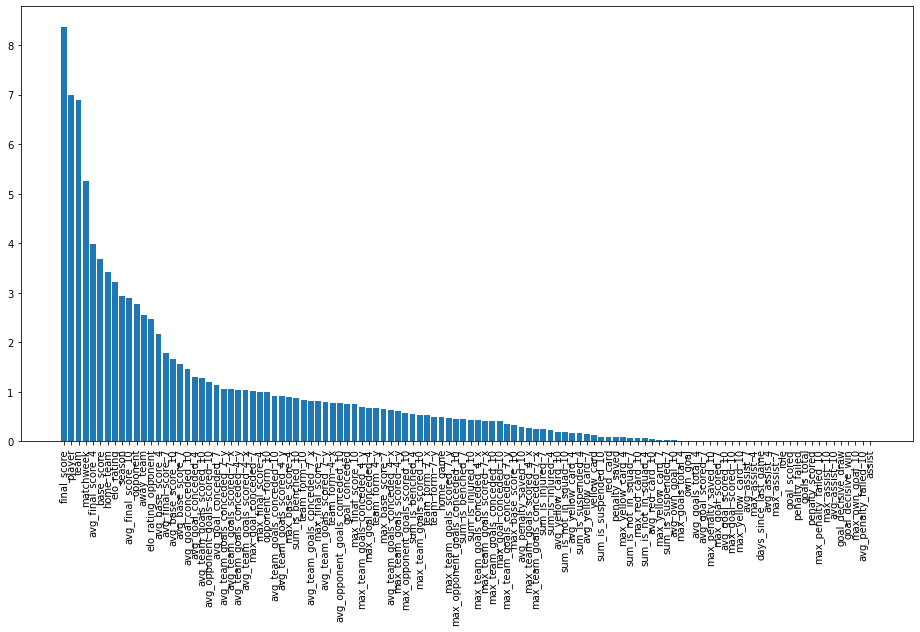

In [24]:
# Plot Feature Importance as barchart

features = X_train.columns
importances = catboost_gk.feature_importances_
indices = np.flip(np.argsort(importances))

plt.figure(figsize=(16,8))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), features[indices], rotation=90)
plt.show()

### Final Score for Goalkeepers

In [25]:
# Validate the model

predictions = catboost_gk.predict(pool_test)

mae = mean_absolute_error(y_cv, predictions)
rmse = mean_squared_error(y_cv, predictions, squared=False)
r2 = r2_score(y_cv, predictions)

print("Metrics in predicting Final Score\n")
print("MAE:  {}".format(mae))
print("RMSE: {}".format(rmse))
print("R^2:  {}".format(r2))

Metrics in predicting Final Score

MAE:  1.1473733230609164
RMSE: 1.7176259335700519
R^2:  0.6030514577868185


### ROI for Goalkeepers

In [26]:
# Compute predicted ROI and report metrics w.r.t to real ROI
# ROI is computed using log(price + 1) because prices do not grow linearly with the score

def ROI (prices, X_test, y_test, preds):
    
    data = pd.merge(X_test, prices, right_on=["player", "season", "matchweek"], left_on=["player", "season", "matchweek"])
    data["final_score_next_week"] = y_test.reset_index(drop=True)
    data["ROI"] = data["final_score_next_week"] / np.log(data["price"] + 1)
    data["final_score_predicted"] = preds
    data["predicted_ROI"] = data["final_score_predicted"] / np.log(data["price"] + 1)
    
    mae = mean_absolute_error(np.array(data["ROI"]), np.array(data["predicted_ROI"]))
    rmse = mean_squared_error(np.array(data["ROI"]), np.array(data["predicted_ROI"]), squared=True)
    r2 = r2_score(np.array(data["ROI"]), np.array(data["predicted_ROI"]))
    
    print("Metrics in predicting ROI\n")
    print("MAE:  {}".format(mae))
    print("RMSE: {}".format(rmse))
    print("R^2:  {}".format(r2))
    
    return data

In [27]:
goal_keepers = ROI(prices, X_cv, y_cv, predictions)

Metrics in predicting ROI

MAE:  0.7552304792624459
RMSE: 1.5279666935434568
R^2:  0.45066613599232463


## Outfield Players

In [28]:
outfield_players = data[data.role != "G"]

In [29]:
outfield_players

,player,season,matchweek,team,home_team,away_team,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,price,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,final_score_next_week,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4
0,AARONS,2017,23,VERONA,VERONA,ROMA,M,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,ROMA,1771.0,2114.0,0.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.3,4.0,1.571429,4.0,0.75,2.0,1.6,4.0,1.571429,4.0,2.00,4.0,-3.0,-1.0,-2.0,0.9,3.0,0.714286,1.0,0.50,1.0,0.8,2.0,0.857143,2.0,1.25,2.0,0.0,-1.0,-3.0,1,5.0,5.5,5.000000,5.0,5.000000,5.0,5.000000,5.0
1,AARONS,2017,24,VERONA,SAMPDORIA,VERONA,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,SAMPDORIA,1767.0,1935.0,0.0,5.250000,5.5,5.250000,5.5,5.250000,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.5,4.0,1.428571,4.0,0.75,2.0,1.4,4.0,1.571429,4.0,2.00,4.0,-1.0,-1.0,-2.0,1.7,3.0,2.000000,3.0,1.50,3.0,1.2,2.0,1.000000,2.0,0.75,1.0,2.0,4.0,1.0,0,5.5,5.5,5.250000,5.5,5.250000,5.5,5.250000,5.5
2,AARONS,2017,25,VERONA,LAZIO,VERONA,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,LAZIO,1762.0,2032.0,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.7,4.0,1.142857,2.0,1.25,2.0,1.3,4.0,1.571429,4.0,1.25,4.0,1.0,-1.0,0.0,2.4,5.0,2.285714,5.0,2.25,4.0,1.6,5.0,1.428571,5.0,1.00,2.0,2.0,2.0,2.0,0,5.5,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5
3,AARONS,2017,26,VERONA,VERONA,TORINO,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,TORINO,1759.0,1975.0,0.0,4.000000,5.5,4.000000,5.5,4.000000,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [30]:
# Split in Train and Test data

train_df = outfield_players[(outfield_players.season == 2016) | (outfield_players.season == 2017) | ((outfield_players.season == 2018) & (outfield_players.matchweek < 19))]
test_df = outfield_players[(outfield_players.season == 2018) & (outfield_players.matchweek >= 19)]

In [31]:
# Split Train data into Train (80%) and Validation (20%)
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y = train_df["final_score_next_week"]
X = train_df.drop(["final_score_next_week", "price"], axis=1)
prices = train_df[["player", "season", "matchweek", "price"]]

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 42)

pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_cv, cat_features=cat_features)

In [32]:
# Train the model

catboost_op = CatBoostRegressor(depth=7, learning_rate=0.1, l2_leaf_reg=7, random_state=42)
catboost_op.fit(pool_train)

0:	learn: 3.2381246	total: 64.2ms	remaining: 1m 4s
1:	learn: 3.1575163	total: 117ms	remaining: 58.5s
2:	learn: 3.0887106	total: 233ms	remaining: 1m 17s
3:	learn: 3.0318954	total: 294ms	remaining: 1m 13s
4:	learn: 2.9833230	total: 369ms	remaining: 1m 13s
5:	learn: 2.9401009	total: 432ms	remaining: 1m 11s
6:	learn: 2.9037133	total: 542ms	remaining: 1m 16s
7:	learn: 2.8716262	total: 615ms	remaining: 1m 16s
8:	learn: 2.8453352	total: 680ms	remaining: 1m 14s
9:	learn: 2.8248585	total: 737ms	remaining: 1m 12s
10:	learn: 2.8056494	total: 814ms	remaining: 1m 13s
11:	learn: 2.7887140	total: 878ms	remaining: 1m 12s
12:	learn: 2.7758105	total: 958ms	remaining: 1m 12s
13:	learn: 2.7635895	total: 1.01s	remaining: 1m 11s
14:	learn: 2.7530150	total: 1.1s	remaining: 1m 12s
15:	learn: 2.7427265	total: 1.18s	remaining: 1m 12s
16:	learn: 2.7347551	total: 1.25s	remaining: 1m 12s
17:	learn: 2.7276074	total: 1.32s	remaining: 1m 12s
18:	learn: 2.7191574	total: 1.45s	remaining: 1m 14s
19:	learn: 2.7141395	tot

159:	learn: 2.5664976	total: 13.1s	remaining: 1m 8s
160:	learn: 2.5656287	total: 13.1s	remaining: 1m 8s
161:	learn: 2.5639694	total: 13.2s	remaining: 1m 8s
162:	learn: 2.5630740	total: 13.3s	remaining: 1m 8s
163:	learn: 2.5626078	total: 13.3s	remaining: 1m 7s
164:	learn: 2.5613449	total: 13.4s	remaining: 1m 7s
165:	learn: 2.5597987	total: 13.5s	remaining: 1m 7s
166:	learn: 2.5596182	total: 13.6s	remaining: 1m 7s
167:	learn: 2.5594263	total: 13.6s	remaining: 1m 7s
168:	learn: 2.5588590	total: 13.7s	remaining: 1m 7s
169:	learn: 2.5583350	total: 13.7s	remaining: 1m 7s
170:	learn: 2.5575085	total: 13.9s	remaining: 1m 7s
171:	learn: 2.5566043	total: 13.9s	remaining: 1m 7s
172:	learn: 2.5560960	total: 14s	remaining: 1m 6s
173:	learn: 2.5560861	total: 14.1s	remaining: 1m 6s
174:	learn: 2.5558694	total: 14.1s	remaining: 1m 6s
175:	learn: 2.5551297	total: 14.2s	remaining: 1m 6s
176:	learn: 2.5546653	total: 14.3s	remaining: 1m 6s
177:	learn: 2.5543930	total: 14.3s	remaining: 1m 6s
178:	learn: 2.

321:	learn: 2.4886575	total: 24.7s	remaining: 52s
322:	learn: 2.4884800	total: 24.8s	remaining: 52s
323:	learn: 2.4880799	total: 25s	remaining: 52.1s
324:	learn: 2.4871174	total: 25.2s	remaining: 52.2s
325:	learn: 2.4865570	total: 25.3s	remaining: 52.3s
326:	learn: 2.4861485	total: 25.4s	remaining: 52.4s
327:	learn: 2.4860294	total: 25.5s	remaining: 52.3s
328:	learn: 2.4855024	total: 25.6s	remaining: 52.2s
329:	learn: 2.4853709	total: 25.7s	remaining: 52.1s
330:	learn: 2.4852255	total: 25.7s	remaining: 52s
331:	learn: 2.4847627	total: 25.8s	remaining: 52s
332:	learn: 2.4844070	total: 25.9s	remaining: 51.9s
333:	learn: 2.4831123	total: 26.1s	remaining: 52.1s
334:	learn: 2.4827451	total: 26.3s	remaining: 52.2s
335:	learn: 2.4826193	total: 26.4s	remaining: 52.2s
336:	learn: 2.4822370	total: 26.6s	remaining: 52.3s
337:	learn: 2.4818673	total: 26.7s	remaining: 52.4s
338:	learn: 2.4812993	total: 26.9s	remaining: 52.5s
339:	learn: 2.4812040	total: 27.1s	remaining: 52.6s
340:	learn: 2.4810147	

482:	learn: 2.4115464	total: 39.6s	remaining: 42.4s
483:	learn: 2.4113479	total: 39.7s	remaining: 42.3s
484:	learn: 2.4111213	total: 39.7s	remaining: 42.2s
485:	learn: 2.4105059	total: 39.9s	remaining: 42.2s
486:	learn: 2.4102331	total: 39.9s	remaining: 42.1s
487:	learn: 2.4100140	total: 40s	remaining: 42s
488:	learn: 2.4099644	total: 40s	remaining: 41.8s
489:	learn: 2.4085157	total: 40.1s	remaining: 41.8s
490:	learn: 2.4081628	total: 40.3s	remaining: 41.7s
491:	learn: 2.4080868	total: 40.3s	remaining: 41.6s
492:	learn: 2.4076701	total: 40.4s	remaining: 41.5s
493:	learn: 2.4074280	total: 40.5s	remaining: 41.4s
494:	learn: 2.4070564	total: 40.5s	remaining: 41.3s
495:	learn: 2.4065391	total: 40.6s	remaining: 41.3s
496:	learn: 2.4061956	total: 40.7s	remaining: 41.2s
497:	learn: 2.4056981	total: 40.8s	remaining: 41.1s
498:	learn: 2.4048339	total: 40.9s	remaining: 41s
499:	learn: 2.4045460	total: 40.9s	remaining: 40.9s
500:	learn: 2.4040280	total: 41s	remaining: 40.8s
501:	learn: 2.4033436	

643:	learn: 2.3446435	total: 52.2s	remaining: 28.9s
644:	learn: 2.3443684	total: 52.3s	remaining: 28.8s
645:	learn: 2.3440000	total: 52.4s	remaining: 28.7s
646:	learn: 2.3429976	total: 52.5s	remaining: 28.7s
647:	learn: 2.3428379	total: 52.6s	remaining: 28.6s
648:	learn: 2.3425117	total: 52.6s	remaining: 28.5s
649:	learn: 2.3413168	total: 52.7s	remaining: 28.4s
650:	learn: 2.3406249	total: 52.8s	remaining: 28.3s
651:	learn: 2.3398604	total: 52.9s	remaining: 28.2s
652:	learn: 2.3392496	total: 53s	remaining: 28.1s
653:	learn: 2.3384307	total: 53.1s	remaining: 28.1s
654:	learn: 2.3380650	total: 53.1s	remaining: 28s
655:	learn: 2.3371806	total: 53.2s	remaining: 27.9s
656:	learn: 2.3363869	total: 53.3s	remaining: 27.8s
657:	learn: 2.3362167	total: 53.3s	remaining: 27.7s
658:	learn: 2.3357640	total: 53.5s	remaining: 27.7s
659:	learn: 2.3353535	total: 53.5s	remaining: 27.6s
660:	learn: 2.3350763	total: 53.6s	remaining: 27.5s
661:	learn: 2.3346573	total: 53.7s	remaining: 27.4s
662:	learn: 2.33

805:	learn: 2.2808295	total: 1m 7s	remaining: 16.1s
806:	learn: 2.2805061	total: 1m 7s	remaining: 16.1s
807:	learn: 2.2800846	total: 1m 7s	remaining: 16s
808:	learn: 2.2797664	total: 1m 7s	remaining: 15.9s
809:	learn: 2.2794273	total: 1m 7s	remaining: 15.8s
810:	learn: 2.2789575	total: 1m 7s	remaining: 15.7s
811:	learn: 2.2789532	total: 1m 7s	remaining: 15.6s
812:	learn: 2.2780084	total: 1m 7s	remaining: 15.5s
813:	learn: 2.2779972	total: 1m 7s	remaining: 15.4s
814:	learn: 2.2776413	total: 1m 7s	remaining: 15.4s
815:	learn: 2.2771360	total: 1m 7s	remaining: 15.3s
816:	learn: 2.2769177	total: 1m 7s	remaining: 15.2s
817:	learn: 2.2766034	total: 1m 7s	remaining: 15.1s
818:	learn: 2.2763732	total: 1m 7s	remaining: 15s
819:	learn: 2.2758219	total: 1m 7s	remaining: 14.9s
820:	learn: 2.2756573	total: 1m 8s	remaining: 14.9s
821:	learn: 2.2750769	total: 1m 8s	remaining: 14.8s
822:	learn: 2.2748083	total: 1m 8s	remaining: 14.7s
823:	learn: 2.2739893	total: 1m 8s	remaining: 14.6s
824:	learn: 2.27

962:	learn: 2.2220529	total: 1m 21s	remaining: 3.14s
963:	learn: 2.2217889	total: 1m 21s	remaining: 3.05s
964:	learn: 2.2212737	total: 1m 21s	remaining: 2.97s
965:	learn: 2.2209124	total: 1m 21s	remaining: 2.88s
966:	learn: 2.2207181	total: 1m 22s	remaining: 2.8s
967:	learn: 2.2202842	total: 1m 22s	remaining: 2.71s
968:	learn: 2.2200020	total: 1m 22s	remaining: 2.63s
969:	learn: 2.2196745	total: 1m 22s	remaining: 2.54s
970:	learn: 2.2195766	total: 1m 22s	remaining: 2.46s
971:	learn: 2.2193040	total: 1m 22s	remaining: 2.37s
972:	learn: 2.2185807	total: 1m 22s	remaining: 2.29s
973:	learn: 2.2185501	total: 1m 22s	remaining: 2.2s
974:	learn: 2.2184006	total: 1m 22s	remaining: 2.12s
975:	learn: 2.2182978	total: 1m 22s	remaining: 2.03s
976:	learn: 2.2177392	total: 1m 22s	remaining: 1.95s
977:	learn: 2.2174309	total: 1m 22s	remaining: 1.86s
978:	learn: 2.2172325	total: 1m 23s	remaining: 1.78s
979:	learn: 2.2169184	total: 1m 23s	remaining: 1.7s
980:	learn: 2.2167042	total: 1m 23s	remaining: 1.

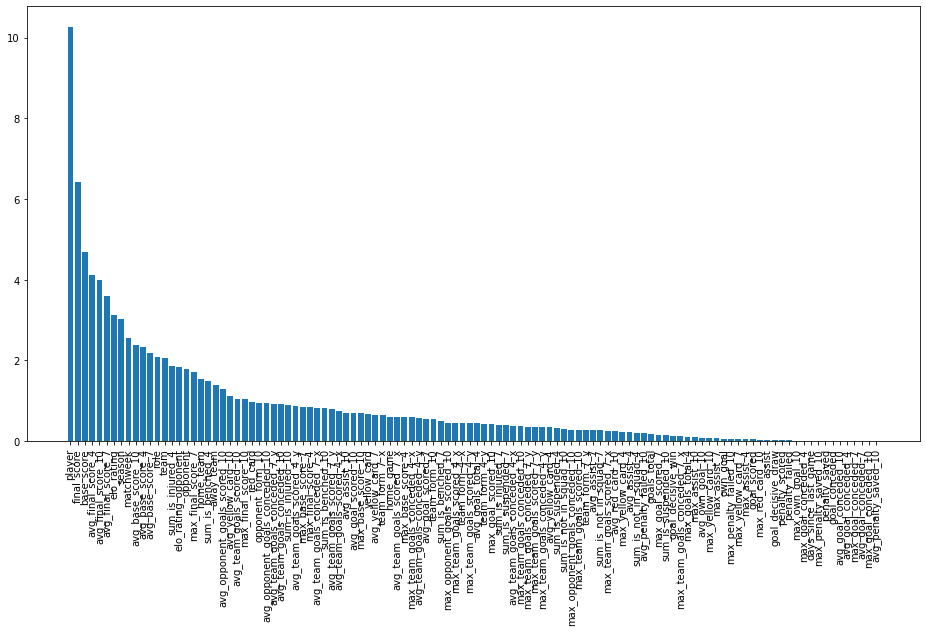

In [33]:
# Plot Feature Importance as barchart

features = X_train.columns
importances = catboost_op.feature_importances_
indices = np.flip(np.argsort(importances))

plt.figure(figsize=(16,8))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), features[indices], rotation=90)
plt.show()

### Final Score for Outfield Players

In [34]:
# Validate the model

predictions = catboost_op.predict(pool_test)

mae = mean_absolute_error(y_cv, predictions)
rmse = mean_squared_error(y_cv, predictions, squared=False)
r2 = r2_score(y_cv, predictions)

print("Metrics in predicting Final Score\n")
print("MAE:  {}".format(mae))
print("RMSE: {}".format(rmse))
print("R^2:  {}".format(r2))

Metrics in predicting Final Score

MAE:  1.9813048183327988
RMSE: 2.561857685169723
R^2:  0.4046940062807235


### ROI for Outfield Players

In [35]:
outfield_players = ROI(prices, X_cv, y_cv, predictions)

Metrics in predicting ROI

MAE:  1.1460892088625663
RMSE: 2.4776299036740324
R^2:  0.2200874681858388


# Test on second half of Season 2018-19

## Goalkeepers

In [36]:
goal_keepers = data[data.role == "G"]

In [37]:
goal_keepers

,player,season,matchweek,team,home_team,away_team,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,price,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,final_score_next_week,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4
1725,ALISSON,2017,1,ROMA,ATALANTA,ROMA,G,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,ATALANTA,2151.0,2018.0,0.0,0.60,6.0,0.857143,6.0,1.500,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,7,1.5,3.0,1.714286,3.0,2.25,3.0,2.4,5.0,2.857143,5.0,2.25,5.0,-3.0,-3.0,0.0,1.0,3.0,1.142857,3.0,0.50,1.0,1.5,5.0,1.142857,2.0,0.75,1.0,-1.0,0.0,-1.0,0,6.0,3.0,0.60,6.0,0.857143,6.0,1.500,6.0
1726,ALISSON,2017,2,ROMA,ROMA,INTER,G,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,INTER,2160.0,2001.0,0.0,1.20,6.0,1.714286,6.0,3.000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,3.0,0.428571,3.0,0.75,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,2.0,0.0,0.0,0.0,7,1.4,3.0,1.714286,3.0,1.75,3.0,2.7,5.0,2.714286,5.0,2.75,5.0,-5.0,-3.0,-2.0,2.1,5.0,1.714286,5.0,2.50,5.0,1.8,4.0,1.571429,3.0,2.00,3.0,1.0,-1.0,0.0,1,3.0,6.0,0.90,6.0,1.285714,6.0,2.250,6.0
1727,ALISSON,2017,3,ROMA,SAMPDORIA,ROMA,G,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,SAMPDORIA,2134.0,1917.0,0.0,1.90,7.0,2.714286,7.0,4.750,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,3.0,0.571429,3.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,0.0,0.0,0.0,7,1.5,3.0,1.714286,3.0,1.25,3.0,2.5,5.0,2.428571,5.0,1.75,3.0,-4.0,-2.0,-1.0,1.9,7.0,2.142857,7.0,1.50,2.0,1.7,4.0,1.857143,4.0,2.00,4.0,0.0,0.0,-1.0,0,6.0,6.0,1.50,6.0,2.142857,6.0,3.750,6.0
1728,ALISSON,2017,4,ROMA,ROMA,VERONA,G,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,VERONA,2135.0,1769.0,0.0,2.50,7.0,3.571429,7.0,6.250,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,3.0,0.571429,3.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,7,

In [38]:
# Split in Train and Test data

train_df = goal_keepers[(goal_keepers.season == 2016) | (goal_keepers.season == 2017) | ((goal_keepers.season == 2018) & (goal_keepers.matchweek < 19))]
test_df = goal_keepers[(goal_keepers.season == 2018) & (goal_keepers.matchweek >= 19)]

In [39]:
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y_train = train_df["final_score_next_week"]
X_train = train_df.drop(["final_score_next_week", "price"], axis=1)

y_test = test_df["final_score_next_week"]
X_test = test_df.drop(["final_score_next_week", "price"], axis=1)
prices = test_df[["player", "season", "matchweek", "price"]]

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, cat_features=cat_features)

In [40]:
# Train the model

catboost_gk = CatBoostRegressor(depth=7, learning_rate=0.1, l2_leaf_reg=3, random_state=42)
catboost_gk.fit(pool_train)

0:	learn: 2.5683689	total: 31.7ms	remaining: 31.7s
1:	learn: 2.4611504	total: 69ms	remaining: 34.4s
2:	learn: 2.3648576	total: 113ms	remaining: 37.6s
3:	learn: 2.2812394	total: 205ms	remaining: 51.1s
4:	learn: 2.2114056	total: 292ms	remaining: 58.1s
5:	learn: 2.1529258	total: 388ms	remaining: 1m 4s
6:	learn: 2.0987370	total: 490ms	remaining: 1m 9s
7:	learn: 2.0583841	total: 557ms	remaining: 1m 9s
8:	learn: 2.0230786	total: 685ms	remaining: 1m 15s
9:	learn: 1.9932149	total: 800ms	remaining: 1m 19s
10:	learn: 1.9707065	total: 865ms	remaining: 1m 17s
11:	learn: 1.9490755	total: 906ms	remaining: 1m 14s
12:	learn: 1.9279307	total: 940ms	remaining: 1m 11s
13:	learn: 1.9099809	total: 1.02s	remaining: 1m 11s
14:	learn: 1.8940267	total: 1.08s	remaining: 1m 11s
15:	learn: 1.8813652	total: 1.16s	remaining: 1m 11s
16:	learn: 1.8706492	total: 1.25s	remaining: 1m 12s
17:	learn: 1.8598977	total: 1.33s	remaining: 1m 12s
18:	learn: 1.8520494	total: 1.43s	remaining: 1m 13s
19:	learn: 1.8416611	total: 1.

161:	learn: 1.3873619	total: 9.27s	remaining: 47.9s
162:	learn: 1.3871577	total: 9.31s	remaining: 47.8s
163:	learn: 1.3853186	total: 9.35s	remaining: 47.6s
164:	learn: 1.3840620	total: 9.39s	remaining: 47.5s
165:	learn: 1.3824564	total: 9.45s	remaining: 47.5s
166:	learn: 1.3800439	total: 9.48s	remaining: 47.3s
167:	learn: 1.3792204	total: 9.53s	remaining: 47.2s
168:	learn: 1.3766101	total: 9.59s	remaining: 47.1s
169:	learn: 1.3736654	total: 9.67s	remaining: 47.2s
170:	learn: 1.3711282	total: 9.71s	remaining: 47.1s
171:	learn: 1.3668064	total: 9.75s	remaining: 46.9s
172:	learn: 1.3625390	total: 9.78s	remaining: 46.8s
173:	learn: 1.3619101	total: 9.83s	remaining: 46.7s
174:	learn: 1.3617802	total: 9.9s	remaining: 46.7s
175:	learn: 1.3609520	total: 9.96s	remaining: 46.6s
176:	learn: 1.3592431	total: 10s	remaining: 46.5s
177:	learn: 1.3584046	total: 10s	remaining: 46.4s
178:	learn: 1.3559765	total: 10.1s	remaining: 46.3s
179:	learn: 1.3538975	total: 10.1s	remaining: 46.2s
180:	learn: 1.353

324:	learn: 1.1467397	total: 16.1s	remaining: 33.5s
325:	learn: 1.1459588	total: 16.1s	remaining: 33.4s
326:	learn: 1.1458526	total: 16.2s	remaining: 33.3s
327:	learn: 1.1451927	total: 16.3s	remaining: 33.3s
328:	learn: 1.1429687	total: 16.3s	remaining: 33.2s
329:	learn: 1.1416931	total: 16.3s	remaining: 33.1s
330:	learn: 1.1404768	total: 16.4s	remaining: 33.1s
331:	learn: 1.1395439	total: 16.4s	remaining: 33.1s
332:	learn: 1.1384416	total: 16.5s	remaining: 33.1s
333:	learn: 1.1369960	total: 16.5s	remaining: 33s
334:	learn: 1.1362649	total: 16.6s	remaining: 32.9s
335:	learn: 1.1354831	total: 16.6s	remaining: 32.8s
336:	learn: 1.1343714	total: 16.6s	remaining: 32.7s
337:	learn: 1.1333673	total: 16.7s	remaining: 32.7s
338:	learn: 1.1319660	total: 16.7s	remaining: 32.6s
339:	learn: 1.1277099	total: 16.7s	remaining: 32.5s
340:	learn: 1.1262075	total: 16.8s	remaining: 32.5s
341:	learn: 1.1244441	total: 16.8s	remaining: 32.4s
342:	learn: 1.1236687	total: 16.9s	remaining: 32.4s
343:	learn: 1.

484:	learn: 0.9566685	total: 22.5s	remaining: 23.8s
485:	learn: 0.9555150	total: 22.5s	remaining: 23.8s
486:	learn: 0.9548749	total: 22.5s	remaining: 23.8s
487:	learn: 0.9535474	total: 22.6s	remaining: 23.7s
488:	learn: 0.9520899	total: 22.6s	remaining: 23.7s
489:	learn: 0.9508636	total: 22.7s	remaining: 23.7s
490:	learn: 0.9504765	total: 22.8s	remaining: 23.6s
491:	learn: 0.9493131	total: 22.8s	remaining: 23.6s
492:	learn: 0.9482860	total: 22.9s	remaining: 23.5s
493:	learn: 0.9469918	total: 22.9s	remaining: 23.5s
494:	learn: 0.9454340	total: 23s	remaining: 23.4s
495:	learn: 0.9442970	total: 23s	remaining: 23.4s
496:	learn: 0.9437803	total: 23.1s	remaining: 23.3s
497:	learn: 0.9430070	total: 23.1s	remaining: 23.3s
498:	learn: 0.9417484	total: 23.2s	remaining: 23.3s
499:	learn: 0.9406778	total: 23.3s	remaining: 23.3s
500:	learn: 0.9390487	total: 23.3s	remaining: 23.2s
501:	learn: 0.9352220	total: 23.4s	remaining: 23.2s
502:	learn: 0.9337918	total: 23.4s	remaining: 23.1s
503:	learn: 0.93

643:	learn: 0.7974624	total: 29.3s	remaining: 16.2s
644:	learn: 0.7967728	total: 29.4s	remaining: 16.2s
645:	learn: 0.7956411	total: 29.4s	remaining: 16.1s
646:	learn: 0.7952248	total: 29.4s	remaining: 16.1s
647:	learn: 0.7944776	total: 29.5s	remaining: 16s
648:	learn: 0.7936782	total: 29.5s	remaining: 16s
649:	learn: 0.7936631	total: 29.5s	remaining: 15.9s
650:	learn: 0.7924177	total: 29.6s	remaining: 15.9s
651:	learn: 0.7920732	total: 29.6s	remaining: 15.8s
652:	learn: 0.7917178	total: 29.6s	remaining: 15.8s
653:	learn: 0.7906030	total: 29.7s	remaining: 15.7s
654:	learn: 0.7894805	total: 29.8s	remaining: 15.7s
655:	learn: 0.7894369	total: 29.8s	remaining: 15.6s
656:	learn: 0.7878620	total: 29.9s	remaining: 15.6s
657:	learn: 0.7874381	total: 29.9s	remaining: 15.5s
658:	learn: 0.7867871	total: 29.9s	remaining: 15.5s
659:	learn: 0.7860674	total: 30s	remaining: 15.4s
660:	learn: 0.7857185	total: 30s	remaining: 15.4s
661:	learn: 0.7844991	total: 30s	remaining: 15.3s
662:	learn: 0.7836143	

804:	learn: 0.6871450	total: 35.7s	remaining: 8.64s
805:	learn: 0.6865560	total: 35.7s	remaining: 8.59s
806:	learn: 0.6861922	total: 35.7s	remaining: 8.55s
807:	learn: 0.6858105	total: 35.8s	remaining: 8.5s
808:	learn: 0.6848536	total: 35.8s	remaining: 8.46s
809:	learn: 0.6840847	total: 35.8s	remaining: 8.41s
810:	learn: 0.6828406	total: 35.9s	remaining: 8.36s
811:	learn: 0.6817810	total: 36s	remaining: 8.32s
812:	learn: 0.6815352	total: 36s	remaining: 8.28s
813:	learn: 0.6809341	total: 36s	remaining: 8.23s
814:	learn: 0.6805777	total: 36.1s	remaining: 8.19s
815:	learn: 0.6796905	total: 36.1s	remaining: 8.14s
816:	learn: 0.6796739	total: 36.1s	remaining: 8.1s
817:	learn: 0.6790148	total: 36.2s	remaining: 8.05s
818:	learn: 0.6780665	total: 36.2s	remaining: 8.01s
819:	learn: 0.6780532	total: 36.3s	remaining: 7.96s
820:	learn: 0.6778358	total: 36.3s	remaining: 7.91s
821:	learn: 0.6769928	total: 36.3s	remaining: 7.87s
822:	learn: 0.6768812	total: 36.4s	remaining: 7.82s
823:	learn: 0.676541

968:	learn: 0.5960196	total: 42.1s	remaining: 1.35s
969:	learn: 0.5956660	total: 42.1s	remaining: 1.3s
970:	learn: 0.5949553	total: 42.2s	remaining: 1.26s
971:	learn: 0.5946508	total: 42.2s	remaining: 1.22s
972:	learn: 0.5942186	total: 42.2s	remaining: 1.17s
973:	learn: 0.5939060	total: 42.3s	remaining: 1.13s
974:	learn: 0.5935920	total: 42.3s	remaining: 1.08s
975:	learn: 0.5926024	total: 42.4s	remaining: 1.04s
976:	learn: 0.5922624	total: 42.4s	remaining: 998ms
977:	learn: 0.5918444	total: 42.4s	remaining: 954ms
978:	learn: 0.5916306	total: 42.5s	remaining: 911ms
979:	learn: 0.5913054	total: 42.5s	remaining: 867ms
980:	learn: 0.5911379	total: 42.5s	remaining: 824ms
981:	learn: 0.5906836	total: 42.6s	remaining: 780ms
982:	learn: 0.5903715	total: 42.6s	remaining: 737ms
983:	learn: 0.5895824	total: 42.6s	remaining: 693ms
984:	learn: 0.5893570	total: 42.7s	remaining: 650ms
985:	learn: 0.5889813	total: 42.7s	remaining: 607ms
986:	learn: 0.5888734	total: 42.8s	remaining: 563ms
987:	learn: 0

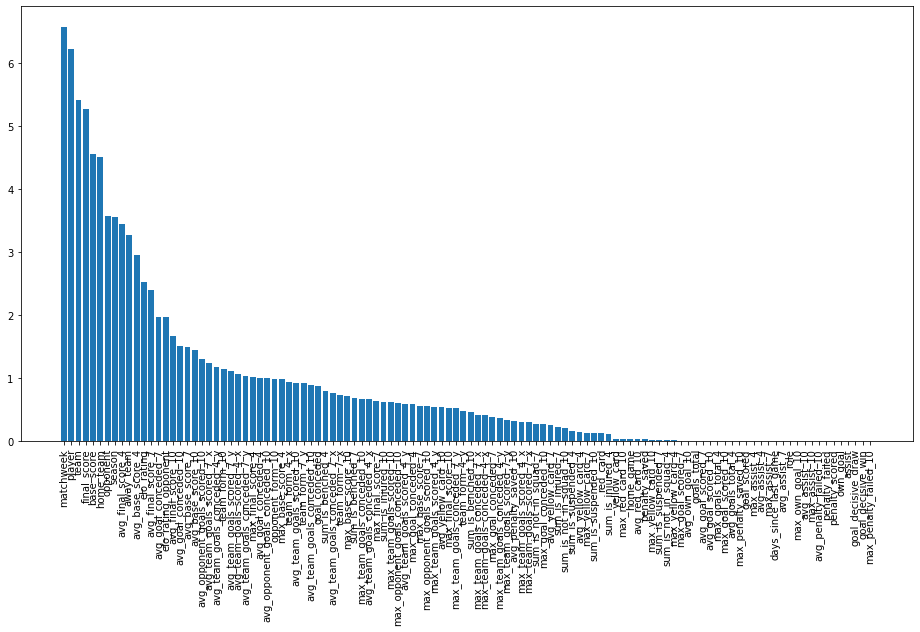

In [41]:
# Plot Feature Importance as barchart

features = X_train.columns
importances = catboost_gk.feature_importances_
indices = np.flip(np.argsort(importances))

plt.figure(figsize=(16,8))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), features[indices], rotation=90)
plt.show()

### Final Score for Goalkeepers

In [42]:
# Validate the model

predictions = catboost_gk.predict(pool_test)

mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print("Metrics in predicting Final Score\n")
print("MAE:  {}".format(mae))
print("RMSE: {}".format(rmse))
print("R^2:  {}".format(r2))

Metrics in predicting Final Score

MAE:  1.487927700438743
RMSE: 2.00301791244157
R^2:  0.4393015385929545


### ROI for Goalkeepers

In [43]:
goal_keepers = ROI(prices, X_test, y_test, predictions)

Metrics in predicting ROI

MAE:  0.8821690284974417
RMSE: 1.7103800455070668
R^2:  0.22529785290634374


In [44]:
goal_keepers.head()

,player,season,matchweek,team,home_team,away_team,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4,price,final_score_next_week,ROI,final_score_predicted,predicted_ROI
0,AUDERO,2018,19,SAMPDORIA,JUVENTUS,SAMPDORIA,G,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JUVENTUS,1938.0,2315.0,0.0,6.00,7.0,6.214286,7.0,6.000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,4.0,1.142857,2.0,1.00,2.0,0.2,1.0,0.285714,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2.3,4.0,2.142857,4.0,2.00,2.0,1.6,4.0,1.285714,4.0,1.25,4.0,4.0,3.0,2.0,1.2,3.0,1.142857,2.0,1.25,2.0,1.2,3.0,1.000000,3.0,1.00,2.0,1.0,2.0,1.0,0,4.0,4.00,6.0,4.928571,6.0,5.000,6.0,10.0,3.0,1.251097,4.071642,1.698007
1,AUDERO,2018,20,SAMPDORIA,FIORENTINA,SAMPDORIA,G,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIORENTINA,1920.0,1996.0,0.0,6.05,7.0,6.071429,6.5,6.000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,4.0,1.428571,3.0,1.75,3.0,0.2,1.0,0.142857,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2.3,4.0,2.428571,4.0,2.25,3.0,1.7,4.0,1.571429,4.0,2.00,4.0,3.0,3.0,1.0,1.1,3.0,1.285714,3.0,0.75,3.0,1.4,3.0,1.714286,3.0,1.25,3.0,-2.0,-2.0,-2.0,0,3.0,4.05,6.0,4.571429,6.0,4.250,6.0,10.0,5.5,2.293678,4.414055,1.840804
2,AUDERO,2018,21,SAMPDORIA,SAMPDORIA,UDINESE,G,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,UDINESE,1925.0,1805.0,0.0,6.10,7.0,6.071429,6.5,6.000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,4.0,1.285714,3.0,1.25,3.0,0.3,1.0,0.285714,1.0,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2.6,4.0,2.428571,4.0,2.75,4.0,1.3,4.0,1.428571,4.0,1.00,3.0,5.0,3.0,3.0,1.3,4.0,1.428571,4.0,1.75,4.0,0.7,3.0,0.857143,3.0,0.50,2.0,3.0,1.0,1.0,1,5.5,4.45,6.0,4.642857,6.0,4.625,6.0,10.0,3.5,1.459613,5.122762,2.136357
3,AUDERO,2018,22,SAMPDORIA,NAPOLI,SAMPDORIA,G,6.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NAPOLI,1933.0,2166.0,0.0,6.20,7.0,6.071429,6.5,6.125,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0

## Outfield Players

In [45]:
outfield_players = data[data.role != "G"]

In [46]:
outfield_players

,player,season,matchweek,team,home_team,away_team,role,base_score,goal_scored,goal_conceded,penalty_saved,penalty_failed,penalty_scored,own_goal,yellow_card,red_card,assist,goal_decisive_draw,goal_decisive_win,price,opponent,elo_rating,elo_rating_opponent,goals_total,avg_base_score_10,max_base_score_10,avg_base_score_7,max_base_score_7,avg_base_score_4,max_base_score_4,avg_goal_scored_10,max_goal_scored_10,avg_goal_scored_7,max_goal_scored_7,avg_goals_total_4,max_goals_total_4,avg_assist_10,max_assist_10,avg_assist_7,max_assist_7,avg_assist_4,max_assist_4,avg_goal_conceded_10,max_goal_conceded_10,avg_goal_conceded_7,max_goal_conceded_7,avg_goal_conceded_4,max_goal_conceded_4,avg_yellow_card_10,max_yellow_card_10,avg_yellow_card_7,max_yellow_card_7,avg_yellow_card_4,max_yellow_card_4,avg_penalty_failed_10,max_penalty_failed_10,avg_penalty_saved_10,max_penalty_saved_10,avg_own_goal_10,max_own_goal_10,avg_red_card_10,max_red_card_10,sum_is_injured_10,sum_is_injured_7,sum_is_injured_4,sum_is_not_in_squad_10,sum_is_not_in_squad_7,sum_is_not_in_squad_4,sum_is_benched_10,sum_is_benched_7,sum_is_benched_4,sum_is_suspended_10,sum_is_suspended_7,sum_is_suspended_4,days_since_last_game,avg_team_goals_scored_10,max_team_goals_scored_10,avg_team_goals_scored_7_x,max_team_goals_scored_7_x,avg_team_goals_scored_4_x,max_team_goals_scored_4_x,avg_team_goals_conceded_10,max_team_goals_conceded_10,avg_team_goals_conceded_7_x,max_team_goals_conceded_7_x,avg_team_goals_conceded_4_x,max_team_goals_conceded_4_x,team_form_10,team_form_7_x,team_form_4_x,avg_opponent_goals_scored_10,max_opponent_goals_scored_10,avg_team_goals_scored_7_y,max_team_goals_scored_7_y,avg_team_goals_scored_4_y,max_team_goals_scored_4_y,avg_opponent_goals_conceded_10,max_opponent_goals_conceded_10,avg_team_goals_conceded_7_y,max_team_goals_conceded_7_y,avg_team_goals_conceded_4_y,max_team_goals_conceded_4_y,opponent_form_10,team_form_7_y,team_form_4_y,home_game,final_score,final_score_next_week,avg_final_score_10,max_final_score_10,avg_final_score_7,max_final_score_7,avg_final_score_4,max_final_score_4
0,AARONS,2017,23,VERONA,VERONA,ROMA,M,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,ROMA,1771.0,2114.0,0.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.3,4.0,1.571429,4.0,0.75,2.0,1.6,4.0,1.571429,4.0,2.00,4.0,-3.0,-1.0,-2.0,0.9,3.0,0.714286,1.0,0.50,1.0,0.8,2.0,0.857143,2.0,1.25,2.0,0.0,-1.0,-3.0,1,5.0,5.5,5.000000,5.0,5.000000,5.0,5.000000,5.0
1,AARONS,2017,24,VERONA,SAMPDORIA,VERONA,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,SAMPDORIA,1767.0,1935.0,0.0,5.250000,5.5,5.250000,5.5,5.250000,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.5,4.0,1.428571,4.0,0.75,2.0,1.4,4.0,1.571429,4.0,2.00,4.0,-1.0,-1.0,-2.0,1.7,3.0,2.000000,3.0,1.50,3.0,1.2,2.0,1.000000,2.0,0.75,1.0,2.0,4.0,1.0,0,5.5,5.5,5.250000,5.5,5.250000,5.5,5.250000,5.5
2,AARONS,2017,25,VERONA,LAZIO,VERONA,M,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,LAZIO,1762.0,2032.0,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.7,4.0,1.142857,2.0,1.25,2.0,1.3,4.0,1.571429,4.0,1.25,4.0,1.0,-1.0,0.0,2.4,5.0,2.285714,5.0,2.25,4.0,1.6,5.0,1.428571,5.0,1.00,2.0,2.0,2.0,2.0,0,5.5,0.0,5.333333,5.5,5.333333,5.5,5.333333,5.5
3,AARONS,2017,26,VERONA,VERONA,TORINO,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,TORINO,1759.0,1975.0,0.0,4.000000,5.5,4.000000,5.5,4.000000,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [47]:
# Split in Train and Test data

train_df = outfield_players[(outfield_players.season == 2016) | (outfield_players.season == 2017) | ((outfield_players.season == 2018) & (outfield_players.matchweek < 19))]
test_df = outfield_players[(outfield_players.season == 2018) & (outfield_players.matchweek >= 19)]

In [48]:
# Declare categorical features and transform dataset into pool to make CatBoost work properly

y_train = train_df["final_score_next_week"]
X_train = train_df.drop(["final_score_next_week", "price"], axis=1)

y_test = test_df["final_score_next_week"]
X_test = test_df.drop(["final_score_next_week", "price"], axis=1)
prices = test_df[["player", "season", "matchweek", "price"]]

# Declare as categorical features all those that are not numeric
cat_features = np.where((X.dtypes != float) & (X.dtypes != int))[0]

pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, cat_features=cat_features)

In [49]:
# Train the model

catboost_op = CatBoostRegressor(depth=7, learning_rate=0.1, l2_leaf_reg=7, random_state=42)
catboost_op.fit(pool_train)

0:	learn: 3.2377695	total: 85.2ms	remaining: 1m 25s
1:	learn: 3.1568517	total: 161ms	remaining: 1m 20s
2:	learn: 3.0885702	total: 245ms	remaining: 1m 21s
3:	learn: 3.0311778	total: 373ms	remaining: 1m 32s
4:	learn: 2.9825455	total: 493ms	remaining: 1m 38s
5:	learn: 2.9408801	total: 558ms	remaining: 1m 32s
6:	learn: 2.9072848	total: 636ms	remaining: 1m 30s
7:	learn: 2.8781685	total: 698ms	remaining: 1m 26s
8:	learn: 2.8543652	total: 767ms	remaining: 1m 24s
9:	learn: 2.8301784	total: 846ms	remaining: 1m 23s
10:	learn: 2.8082256	total: 937ms	remaining: 1m 24s
11:	learn: 2.7899119	total: 1.06s	remaining: 1m 27s
12:	learn: 2.7749050	total: 1.14s	remaining: 1m 26s
13:	learn: 2.7607814	total: 1.3s	remaining: 1m 31s
14:	learn: 2.7484961	total: 1.38s	remaining: 1m 30s
15:	learn: 2.7386721	total: 1.46s	remaining: 1m 29s
16:	learn: 2.7300755	total: 1.64s	remaining: 1m 34s
17:	learn: 2.7229438	total: 1.82s	remaining: 1m 39s
18:	learn: 2.7167223	total: 1.95s	remaining: 1m 40s
19:	learn: 2.7107997	t

159:	learn: 2.5369962	total: 15.8s	remaining: 1m 23s
160:	learn: 2.5362692	total: 16s	remaining: 1m 23s
161:	learn: 2.5359246	total: 16.1s	remaining: 1m 23s
162:	learn: 2.5352057	total: 16.2s	remaining: 1m 23s
163:	learn: 2.5350912	total: 16.3s	remaining: 1m 23s
164:	learn: 2.5346490	total: 16.4s	remaining: 1m 23s
165:	learn: 2.5340222	total: 16.6s	remaining: 1m 23s
166:	learn: 2.5335685	total: 16.7s	remaining: 1m 23s
167:	learn: 2.5330949	total: 16.8s	remaining: 1m 23s
168:	learn: 2.5326232	total: 16.9s	remaining: 1m 23s
169:	learn: 2.5323697	total: 17s	remaining: 1m 22s
170:	learn: 2.5306115	total: 17.1s	remaining: 1m 22s
171:	learn: 2.5299469	total: 17.2s	remaining: 1m 22s
172:	learn: 2.5294483	total: 17.2s	remaining: 1m 22s
173:	learn: 2.5289884	total: 17.3s	remaining: 1m 22s
174:	learn: 2.5279577	total: 17.4s	remaining: 1m 21s
175:	learn: 2.5269917	total: 17.5s	remaining: 1m 21s
176:	learn: 2.5265962	total: 17.6s	remaining: 1m 21s
177:	learn: 2.5261567	total: 17.6s	remaining: 1m 2

317:	learn: 2.4595399	total: 30.8s	remaining: 1m 6s
318:	learn: 2.4590406	total: 30.9s	remaining: 1m 6s
319:	learn: 2.4585657	total: 31s	remaining: 1m 5s
320:	learn: 2.4580170	total: 31.1s	remaining: 1m 5s
321:	learn: 2.4575314	total: 31.2s	remaining: 1m 5s
322:	learn: 2.4572426	total: 31.3s	remaining: 1m 5s
323:	learn: 2.4567898	total: 31.4s	remaining: 1m 5s
324:	learn: 2.4561576	total: 31.4s	remaining: 1m 5s
325:	learn: 2.4557047	total: 31.6s	remaining: 1m 5s
326:	learn: 2.4549775	total: 31.7s	remaining: 1m 5s
327:	learn: 2.4548178	total: 31.8s	remaining: 1m 5s
328:	learn: 2.4541315	total: 31.9s	remaining: 1m 4s
329:	learn: 2.4535474	total: 32s	remaining: 1m 4s
330:	learn: 2.4531086	total: 32.1s	remaining: 1m 4s
331:	learn: 2.4528977	total: 32.1s	remaining: 1m 4s
332:	learn: 2.4522706	total: 32.2s	remaining: 1m 4s
333:	learn: 2.4514232	total: 32.3s	remaining: 1m 4s
334:	learn: 2.4511056	total: 32.4s	remaining: 1m 4s
335:	learn: 2.4509930	total: 32.4s	remaining: 1m 4s
336:	learn: 2.45

479:	learn: 2.3953622	total: 46.4s	remaining: 50.2s
480:	learn: 2.3949788	total: 46.4s	remaining: 50.1s
481:	learn: 2.3943316	total: 46.5s	remaining: 50s
482:	learn: 2.3940304	total: 46.6s	remaining: 49.9s
483:	learn: 2.3937398	total: 46.6s	remaining: 49.7s
484:	learn: 2.3934018	total: 46.8s	remaining: 49.6s
485:	learn: 2.3925998	total: 46.9s	remaining: 49.6s
486:	learn: 2.3924656	total: 47.1s	remaining: 49.6s
487:	learn: 2.3921740	total: 47.2s	remaining: 49.6s
488:	learn: 2.3918463	total: 47.4s	remaining: 49.5s
489:	learn: 2.3906376	total: 47.6s	remaining: 49.6s
490:	learn: 2.3906168	total: 47.8s	remaining: 49.6s
491:	learn: 2.3903553	total: 48s	remaining: 49.5s
492:	learn: 2.3901418	total: 48.1s	remaining: 49.5s
493:	learn: 2.3901350	total: 48.3s	remaining: 49.5s
494:	learn: 2.3895286	total: 48.5s	remaining: 49.4s
495:	learn: 2.3891889	total: 48.7s	remaining: 49.5s
496:	learn: 2.3886333	total: 48.8s	remaining: 49.3s
497:	learn: 2.3885197	total: 48.8s	remaining: 49.2s
498:	learn: 2.38

640:	learn: 2.3397419	total: 1m	remaining: 34.1s
641:	learn: 2.3393749	total: 1m	remaining: 34s
642:	learn: 2.3393361	total: 1m	remaining: 33.9s
643:	learn: 2.3390831	total: 1m 1s	remaining: 33.8s
644:	learn: 2.3388485	total: 1m 1s	remaining: 33.7s
645:	learn: 2.3385799	total: 1m 1s	remaining: 33.6s
646:	learn: 2.3385103	total: 1m 1s	remaining: 33.5s
647:	learn: 2.3380061	total: 1m 1s	remaining: 33.3s
648:	learn: 2.3379175	total: 1m 1s	remaining: 33.2s
649:	learn: 2.3376633	total: 1m 1s	remaining: 33.1s
650:	learn: 2.3369061	total: 1m 1s	remaining: 33s
651:	learn: 2.3367127	total: 1m 1s	remaining: 32.9s
652:	learn: 2.3357413	total: 1m 1s	remaining: 32.8s
653:	learn: 2.3355128	total: 1m 1s	remaining: 32.7s
654:	learn: 2.3353407	total: 1m 1s	remaining: 32.6s
655:	learn: 2.3349774	total: 1m 2s	remaining: 32.5s
656:	learn: 2.3348507	total: 1m 2s	remaining: 32.4s
657:	learn: 2.3346941	total: 1m 2s	remaining: 32.3s
658:	learn: 2.3343965	total: 1m 2s	remaining: 32.2s
659:	learn: 2.3339675	tot

799:	learn: 2.2842179	total: 1m 13s	remaining: 18.5s
800:	learn: 2.2839901	total: 1m 14s	remaining: 18.4s
801:	learn: 2.2837755	total: 1m 14s	remaining: 18.3s
802:	learn: 2.2835572	total: 1m 14s	remaining: 18.2s
803:	learn: 2.2830133	total: 1m 14s	remaining: 18.1s
804:	learn: 2.2827926	total: 1m 14s	remaining: 18s
805:	learn: 2.2823482	total: 1m 14s	remaining: 17.9s
806:	learn: 2.2822032	total: 1m 14s	remaining: 17.8s
807:	learn: 2.2821866	total: 1m 14s	remaining: 17.7s
808:	learn: 2.2819863	total: 1m 14s	remaining: 17.6s
809:	learn: 2.2813953	total: 1m 14s	remaining: 17.5s
810:	learn: 2.2810971	total: 1m 14s	remaining: 17.4s
811:	learn: 2.2808700	total: 1m 14s	remaining: 17.3s
812:	learn: 2.2807917	total: 1m 14s	remaining: 17.2s
813:	learn: 2.2803107	total: 1m 15s	remaining: 17.2s
814:	learn: 2.2795940	total: 1m 15s	remaining: 17.1s
815:	learn: 2.2793577	total: 1m 15s	remaining: 17s
816:	learn: 2.2784927	total: 1m 15s	remaining: 16.9s
817:	learn: 2.2781183	total: 1m 15s	remaining: 16.

957:	learn: 2.2323012	total: 1m 26s	remaining: 3.81s
958:	learn: 2.2321442	total: 1m 26s	remaining: 3.71s
959:	learn: 2.2320074	total: 1m 26s	remaining: 3.62s
960:	learn: 2.2319757	total: 1m 27s	remaining: 3.53s
961:	learn: 2.2316872	total: 1m 27s	remaining: 3.44s
962:	learn: 2.2312738	total: 1m 27s	remaining: 3.35s
963:	learn: 2.2310599	total: 1m 27s	remaining: 3.26s
964:	learn: 2.2306633	total: 1m 27s	remaining: 3.17s
965:	learn: 2.2304848	total: 1m 27s	remaining: 3.08s
966:	learn: 2.2301336	total: 1m 27s	remaining: 2.99s
967:	learn: 2.2289884	total: 1m 27s	remaining: 2.9s
968:	learn: 2.2283391	total: 1m 27s	remaining: 2.81s
969:	learn: 2.2282384	total: 1m 27s	remaining: 2.72s
970:	learn: 2.2279424	total: 1m 27s	remaining: 2.63s
971:	learn: 2.2276962	total: 1m 28s	remaining: 2.54s
972:	learn: 2.2274346	total: 1m 28s	remaining: 2.45s
973:	learn: 2.2271999	total: 1m 28s	remaining: 2.35s
974:	learn: 2.2267412	total: 1m 28s	remaining: 2.26s
975:	learn: 2.2266939	total: 1m 28s	remaining: 

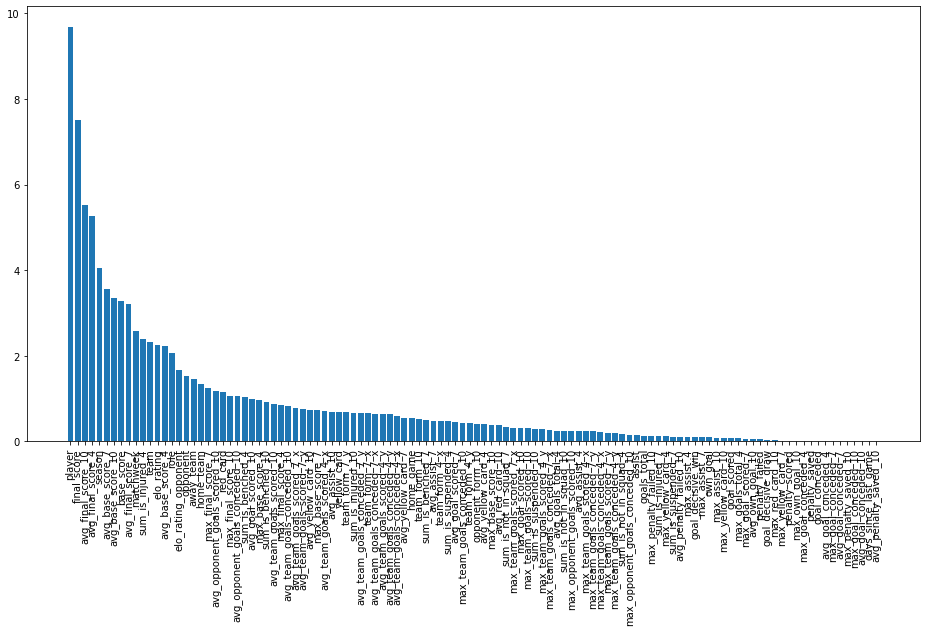

In [50]:
# Plot Feature Importance as barchart

features = X_train.columns
importances = catboost_op.feature_importances_
indices = np.flip(np.argsort(importances))

plt.figure(figsize=(16,8))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), features[indices], rotation=90)
plt.show()

### Final Score for Outfield Players

In [51]:
# Validate the model

predictions = catboost_op.predict(pool_test)

mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print("Metrics in predicting Final Score\n")
print("MAE:  {}".format(mae))
print("RMSE: {}".format(rmse))
print("R^2:  {}".format(r2))

Metrics in predicting Final Score

MAE:  2.5098548430868934
RMSE: 3.1072625556689966
R^2:  0.12215277936417845


### ROI for Outfield Players

In [52]:
outfield_players = ROI(prices, X_test, y_test, predictions)

Metrics in predicting ROI

MAE:  1.3251424515730952
RMSE: 2.9081951594212736
R^2:  -0.08096068150732516


# Recommendations based on ROI

In [53]:
# Sort by predicted ROI and retrieve best recommendations for matchweek and role

def best_x_players (d, role, x):
    
    r = d[d.role == role].reset_index(drop=True)
    
    for suggested in range(x):
        print(suggested+1, "-", r.loc[suggested, "player"], "-", r.loc[suggested, "team"] , "(vs", r.loc[suggested, "opponent"], ") - Final Score:", (round((r.loc[suggested, "final_score_predicted"])/0.5, 0))*0.5, "- Price:", r.loc[suggested, "price"])
        print("    Real Final Score:", round(r.loc[suggested, "final_score_next_week"], 2), "- Prediction Error:", (round((r.loc[suggested, "final_score_predicted"])/0.5, 0))*0.5 - r.loc[suggested, "final_score_next_week"])
    print("")
        
def best_ROI (data):

    data = data.sort_values(["predicted_ROI"], ascending=False)

    for matchweek in range(19,38):
        
        d = data[data.matchweek == matchweek+1]
        print("Best ROI Predicted for Matchweek {}\n".format(matchweek+1))
        
        print("GOALKEEPERS")
        best_x_players(d, "G", 3)
        
        print("DEFENDERS")
        best_x_players(d, "D", 8)
        
        print("MIDFIELDERS")
        best_x_players(d, "M", 8)
        
        print("ATTACKERS")
        best_x_players(d, "A", 6)
        
    print("-----------------------------------")

In [54]:
final_recommendations = pd.concat([goal_keepers, outfield_players])
final_recommendations.drop(final_recommendations[final_recommendations.price < 5].index, inplace=True)

In [55]:
best_ROI(final_recommendations)

Best ROI Predicted for Matchweek 20

GOALKEEPERS
1 - SIRIGU - TORINO (vs ROMA ) - Final Score: 5.0 - Price: 12.0
    Real Final Score: 6.5 - Prediction Error: -1.5
2 - SEPE - PARMA (vs UDINESE ) - Final Score: 5.0 - Price: 11.0
    Real Final Score: 3.0 - Prediction Error: 2.0
3 - STRAKOSHA - LAZIO (vs NAPOLI ) - Final Score: 5.0 - Price: 12.0
    Real Final Score: 3.5 - Prediction Error: 1.5

DEFENDERS
1 - MUSACCHIO - MILAN (vs GENOA ) - Final Score: 5.5 - Price: 5.0
    Real Final Score: 6.5 - Prediction Error: -1.0
2 - MAGNANI - SASSUOLO (vs INTER ) - Final Score: 5.5 - Price: 6.0
    Real Final Score: 7.0 - Prediction Error: -1.5
3 - DIJKS - BOLOGNA (vs SPAL ) - Final Score: 5.0 - Price: 5.0
    Real Final Score: 6.0 - Prediction Error: -1.0
4 - IACOPONI - PARMA (vs UDINESE ) - Final Score: 6.0 - Price: 7.0
    Real Final Score: 6.0 - Prediction Error: 0.0
5 - GAGLIOLO - PARMA (vs UDINESE ) - Final Score: 6.0 - Price: 8.0
    Real Final Score: 6.0 - Prediction Error: 0.0
6 - CRISCI

    Real Final Score: 5.0 - Prediction Error: 1.0
7 - BONUCCI - JUVENTUS (vs FROSINONE ) - Final Score: 7.5 - Price: 13.0
    Real Final Score: 6.5 - Prediction Error: 1.0
8 - FELIPE - SPAL (vs FIORENTINA ) - Final Score: 5.5 - Price: 6.0
    Real Final Score: 6.0 - Prediction Error: -0.5

MIDFIELDERS
1 - DZEMAILI - BOLOGNA (vs ROMA ) - Final Score: 6.5 - Price: 7.0
    Real Final Score: 0.0 - Prediction Error: 6.5
2 - BERENGUER - TORINO (vs NAPOLI ) - Final Score: 6.0 - Price: 6.0
    Real Final Score: -0.5 - Prediction Error: 6.5
3 - MEITE - TORINO (vs NAPOLI ) - Final Score: 7.0 - Price: 9.0
    Real Final Score: 7.5 - Prediction Error: -0.5
4 - MANDRAGORA - UDINESE (vs CHIEVO ) - Final Score: 6.0 - Price: 7.0
    Real Final Score: 5.5 - Prediction Error: 0.5
5 - BIGLIA - MILAN (vs ATALANTA ) - Final Score: 5.5 - Price: 6.0
    Real Final Score: 0.0 - Prediction Error: 5.5
6 - DE PAUL - UDINESE (vs CHIEVO ) - Final Score: 8.0 - Price: 19.0
    Real Final Score: 2.0 - Prediction Erro

1 - OLSEN - ROMA (vs SPAL ) - Final Score: 5.0 - Price: 10.0
    Real Final Score: 0.5 - Prediction Error: 4.5
2 - SEPE - PARMA (vs LAZIO ) - Final Score: 4.5 - Price: 7.0
    Real Final Score: 2.5 - Prediction Error: 2.0
3 - SPORTIELLO - FROSINONE (vs EMPOLI ) - Final Score: 3.5 - Price: 6.0
    Real Final Score: 5.0 - Prediction Error: -1.5

DEFENDERS
1 - SAMIR - UDINESE (vs NAPOLI ) - Final Score: 6.5 - Price: 5.0
    Real Final Score: 0.0 - Prediction Error: 6.5
2 - VICARI - SPAL (vs ROMA ) - Final Score: 6.5 - Price: 6.0
    Real Final Score: 10.0 - Prediction Error: -3.5
3 - MAIETTA - EMPOLI (vs FROSINONE ) - Final Score: 6.0 - Price: 5.0
    Real Final Score: 5.0 - Prediction Error: 1.0
4 - GAGLIOLO - PARMA (vs LAZIO ) - Final Score: 6.5 - Price: 7.0
    Real Final Score: 5.5 - Prediction Error: 1.0
5 - FELIPE - SPAL (vs ROMA ) - Final Score: 6.0 - Price: 6.0
    Real Final Score: 0.0 - Prediction Error: 6.0
6 - CACCIATORE - CAGLIARI (vs FIORENTINA ) - Final Score: 6.0 - Price: 

4 - SILVESTRE - EMPOLI (vs UDINESE ) - Final Score: 6.0 - Price: 8.0
    Real Final Score: 0.0 - Prediction Error: 6.0
5 - MILENKOVIC - FIORENTINA (vs FROSINONE ) - Final Score: 5.5 - Price: 7.0
    Real Final Score: 6.0 - Prediction Error: -0.5
6 - IACOPONI - PARMA (vs TORINO ) - Final Score: 5.0 - Price: 6.0
    Real Final Score: 6.5 - Prediction Error: -1.5
7 - WALLACE - LAZIO (vs SASSUOLO ) - Final Score: 5.0 - Price: 5.0
    Real Final Score: 0.0 - Prediction Error: 5.0
8 - GAGLIOLO - PARMA (vs TORINO ) - Final Score: 5.5 - Price: 7.0
    Real Final Score: 6.5 - Prediction Error: -1.0

MIDFIELDERS
1 - BRADARIC - CAGLIARI (vs SPAL ) - Final Score: 5.5 - Price: 6.0
    Real Final Score: 0.0 - Prediction Error: 5.5
2 - LAZOVIC - GENOA (vs NAPOLI ) - Final Score: 7.0 - Price: 12.0
    Real Final Score: 5.0 - Prediction Error: 2.0
3 - HILJEMARK - GENOA (vs NAPOLI ) - Final Score: 5.5 - Price: 7.0
    Real Final Score: 0.0 - Prediction Error: 5.5
4 - STULAC - PARMA (vs TORINO ) - Final 

1 - SPORTIELLO - FROSINONE (vs SASSUOLO ) - Final Score: 4.5 - Price: 6.0
    Real Final Score: 0.0 - Prediction Error: 4.5
2 - AUDERO - SAMPDORIA (vs PARMA ) - Final Score: 4.5 - Price: 9.0
    Real Final Score: 8.0 - Prediction Error: -3.5
3 - SKORUPSKI - BOLOGNA (vs MILAN ) - Final Score: 4.5 - Price: 11.0
    Real Final Score: 5.0 - Prediction Error: -0.5

DEFENDERS
1 - NUYTINCK - UDINESE (vs INTER ) - Final Score: 7.5 - Price: 7.0
    Real Final Score: 6.0 - Prediction Error: 1.5
2 - ZAMPANO - FROSINONE (vs SASSUOLO ) - Final Score: 7.0 - Price: 7.0
    Real Final Score: 6.0 - Prediction Error: 1.0
3 - BERESZYNSKI - SAMPDORIA (vs PARMA ) - Final Score: 6.0 - Price: 6.0
    Real Final Score: 0.0 - Prediction Error: 6.0
4 - VITOR HUGO - FIORENTINA (vs EMPOLI ) - Final Score: 6.5 - Price: 7.0
    Real Final Score: 6.0 - Prediction Error: 0.5
5 - ARIAUDO - FROSINONE (vs SASSUOLO ) - Final Score: 5.5 - Price: 6.0
    Real Final Score: 4.5 - Prediction Error: 1.0
6 - BIRASCHI - GENOA (v